# Connect to Google Sheets

This workspace contains example code snippets and instructions for connecting to data in Google sheets from inside Workspace.
For a detailed walkthrough, you can consult [this comprehensive tutorial on connecting to Google Sheets](https://www.datacamp.com/tutorial/how-to-analyze-data-in-google-sheets-with-python-a-step-by-step-guide).

## Read Google Sheets data

### Install and import the right package


In [1]:
%%capture
!pip install gspread
import pandas as pd
import gspread
from google.oauth2 import service_account
import json
import os

### Set up a client with scoped credentials

For this code to work, you need to have an environment variable `GOOGLE_JSON` available in your workspace that contains a Google service account JSON with the right permissions. The steps to configure such a service account and securely store it in Workspace are described in [this documentation article](https://workspace-docs.datacamp.com/connect-to-data/google-sheets).

In [2]:
google_json = os.environ["GOOGLE_JSON"]
service_account_info = json.loads(google_json)
credentials = service_account.Credentials.from_service_account_info(service_account_info)
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds_with_scope = credentials.with_scopes(scope)
client = gspread.authorize(creds_with_scope)

### Read spreadsheets data into a DataFrame

Make sure to update the spreadsheet URL with the URL of your own spreadsheet!

In [4]:
spreadsheet = client.open_by_url('https://docs.google.com/spreadsheets/d/15ywHFsRA4_fccL4RDJrAn7TfHp_BrKWa_oveIyVP8UM/edit?usp=sharing')
worksheet = spreadsheet.get_worksheet(0)
records_data = worksheet.get_all_records()
data = pd.DataFrame.from_dict(records_data)
data.head()

Timestamp            User  ... Location  Quantity
0  12/22/2023 12:09 PM  Warehouse No.1  ...     N3-6         1
1  12/22/2023 11:34 AM  Warehouse No.2  ...     N2-7         2
2  12/22/2023 11:32 AM  Warehouse No.2  ...     F2-5         1
3  12/22/2023 11:30 AM  Warehouse No.2  ...     B2-2         1
4  12/22/2023 11:30 AM  Warehouse No.2  ...     F2-5         3

[5 rows x 7 columns]

## Analyze the spreadsheets data in Python 

In [5]:
# Convert 'Timestamp' to datetime format and extract date and month
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['Date'] = data['Timestamp'].dt.strftime('%Y-%m-%d')
data['Month'] = data['Timestamp'].dt.month

# Grouping by month, date, and user to calculate the daily metrics for each employee
# Transactions: Counting the number of transactions per employee per day
transactions = data.groupby(['Month', 'Date', 'User']).size().reset_index(name='Transactions')

# Quantity: Summing up the total quantity of products scanned per day by each employee
quantity = data.groupby(['Month', 'Date', 'User'])['Quantity'].sum().reset_index(name='Quantity')

# Sales Orders: Counting the number of unique sales orders handled by each employee per day
sales_orders = data.groupby(['Month', 'Date', 'User'])['Sale ID'].nunique().reset_index(name='SalesOrders')

# Merging the metrics into a single dataframe
merged_data = pd.merge(pd.merge(transactions, quantity, on=['Month', 'Date', 'User']), 
                       sales_orders, on=['Month', 'Date', 'User'])

# Preview the merged data
merged_data.head()


Month        Date            User  Transactions  Quantity  SalesOrders
0      1  2023-01-03  Warehouse No.1           290       300           44
1      1  2023-01-03  Warehouse No.2            94       385           34
2      1  2023-01-04  Warehouse No.1            69       290           16
3      1  2023-01-04  Warehouse No.2            40       426           18
4      1  2023-01-05  Warehouse No.1             2         2            1

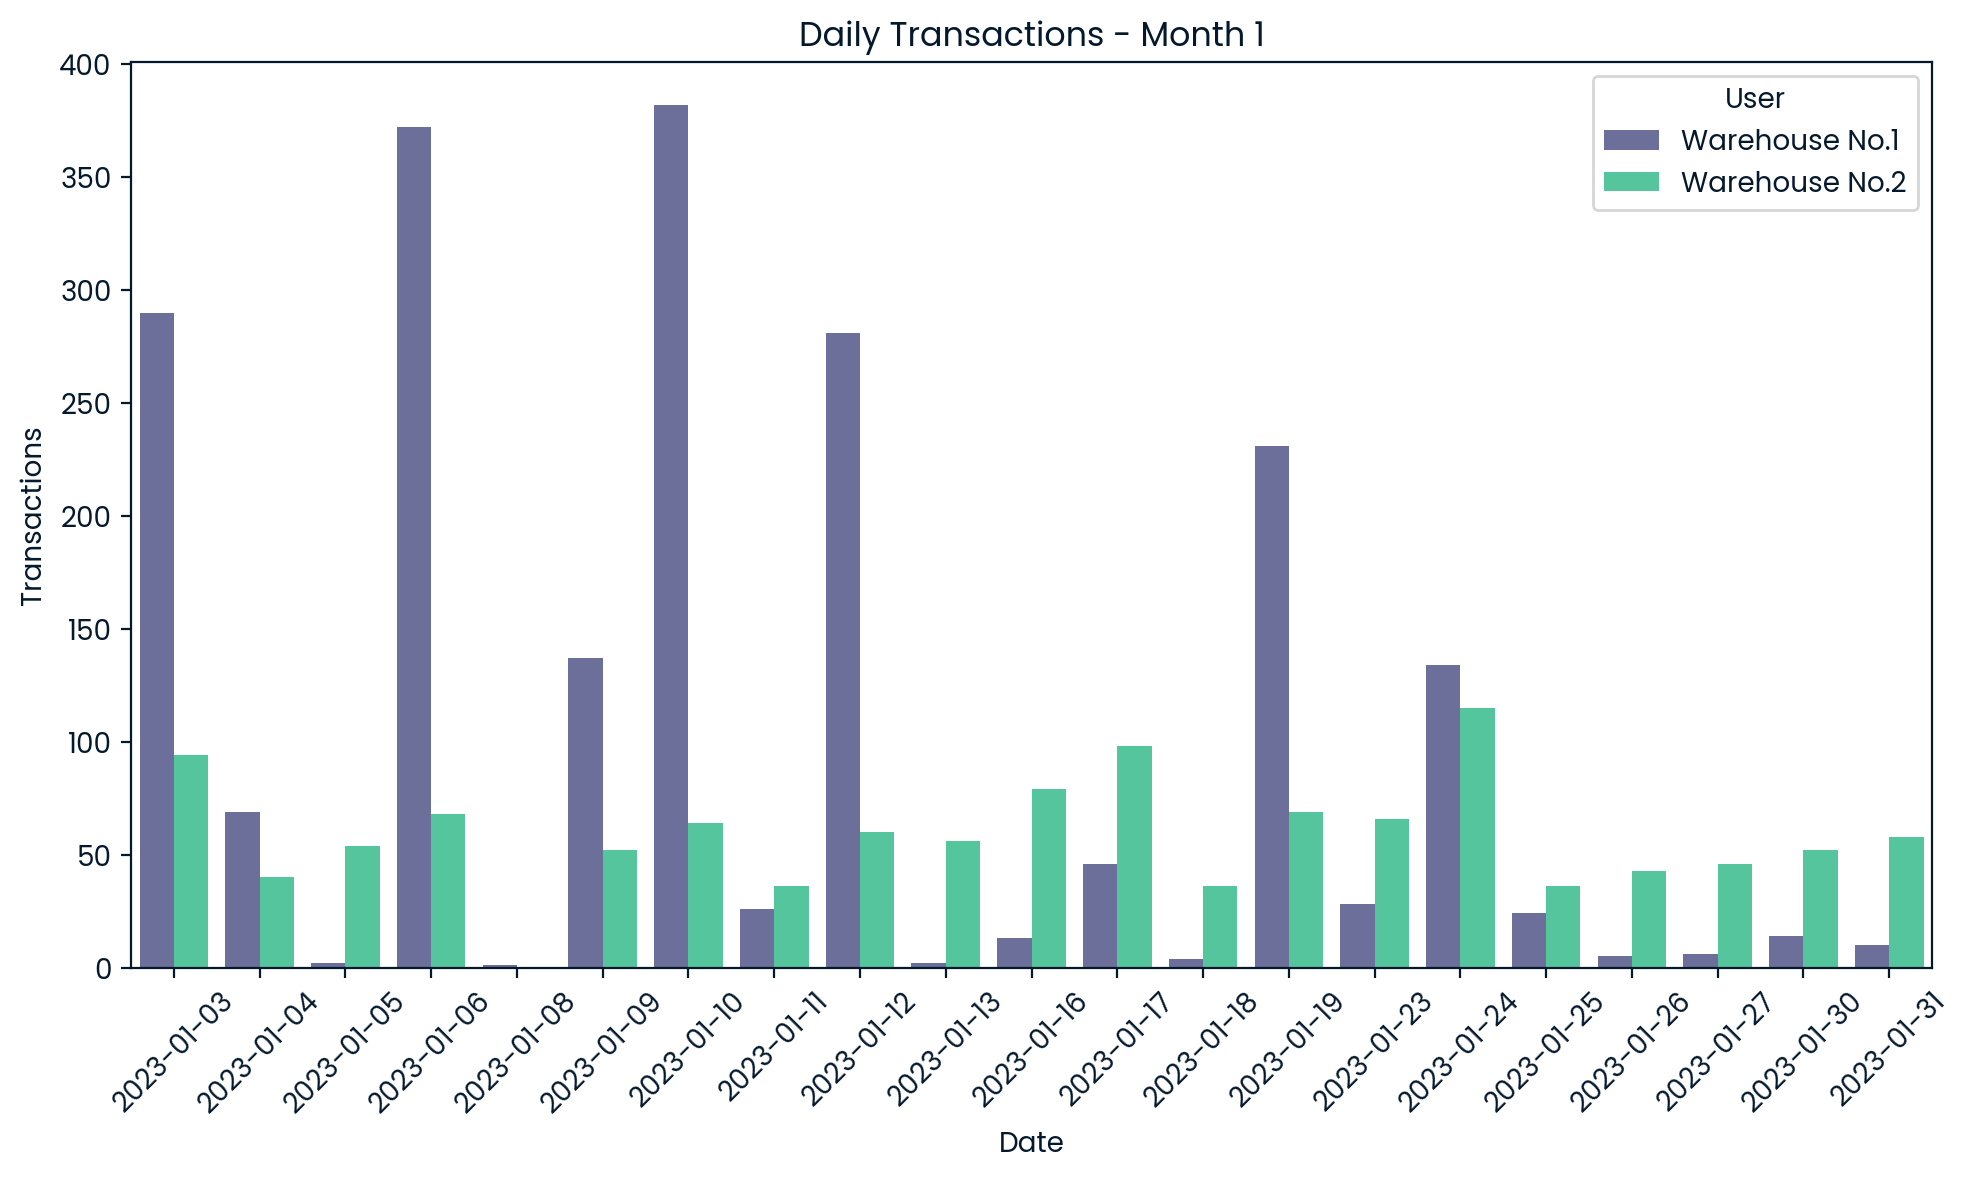

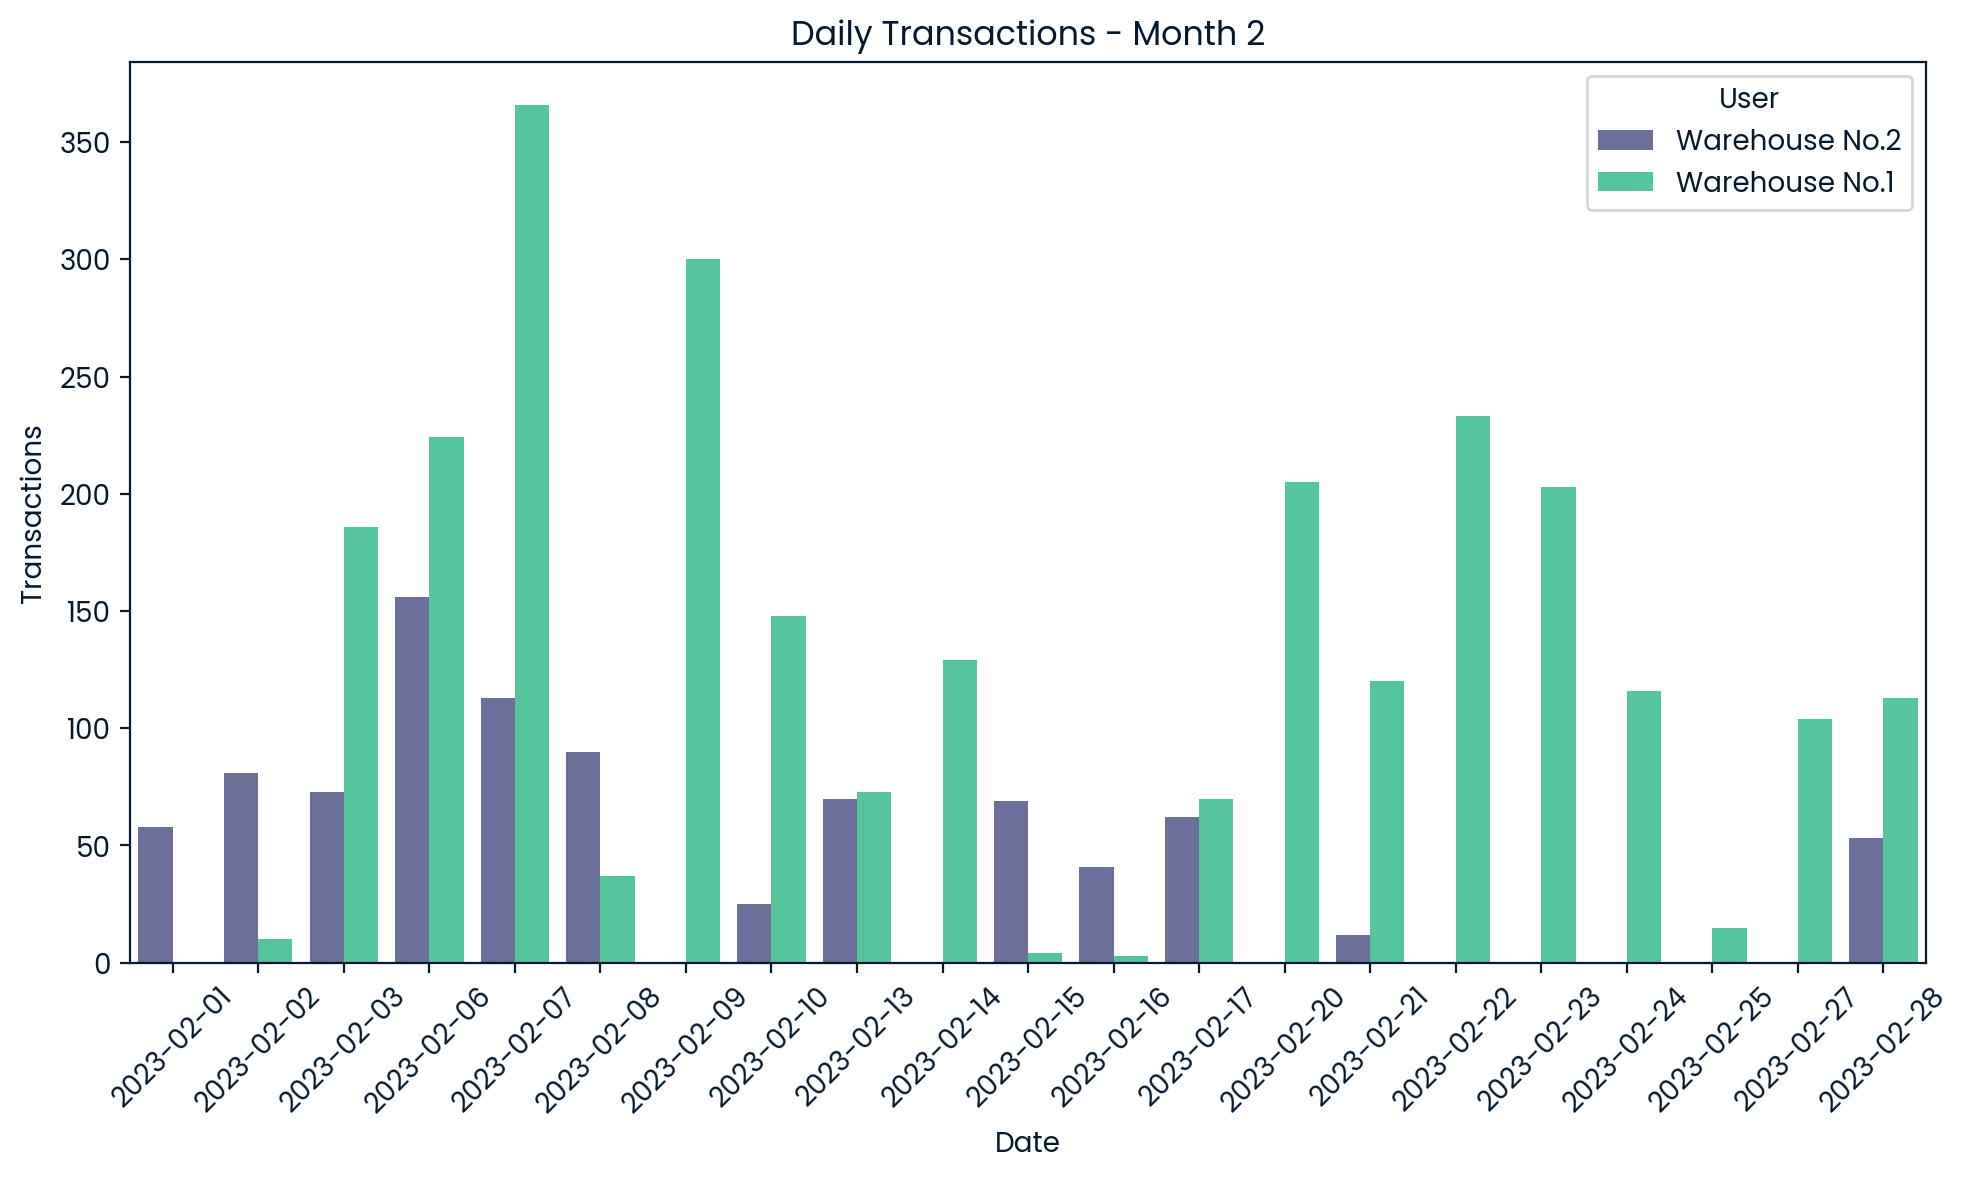

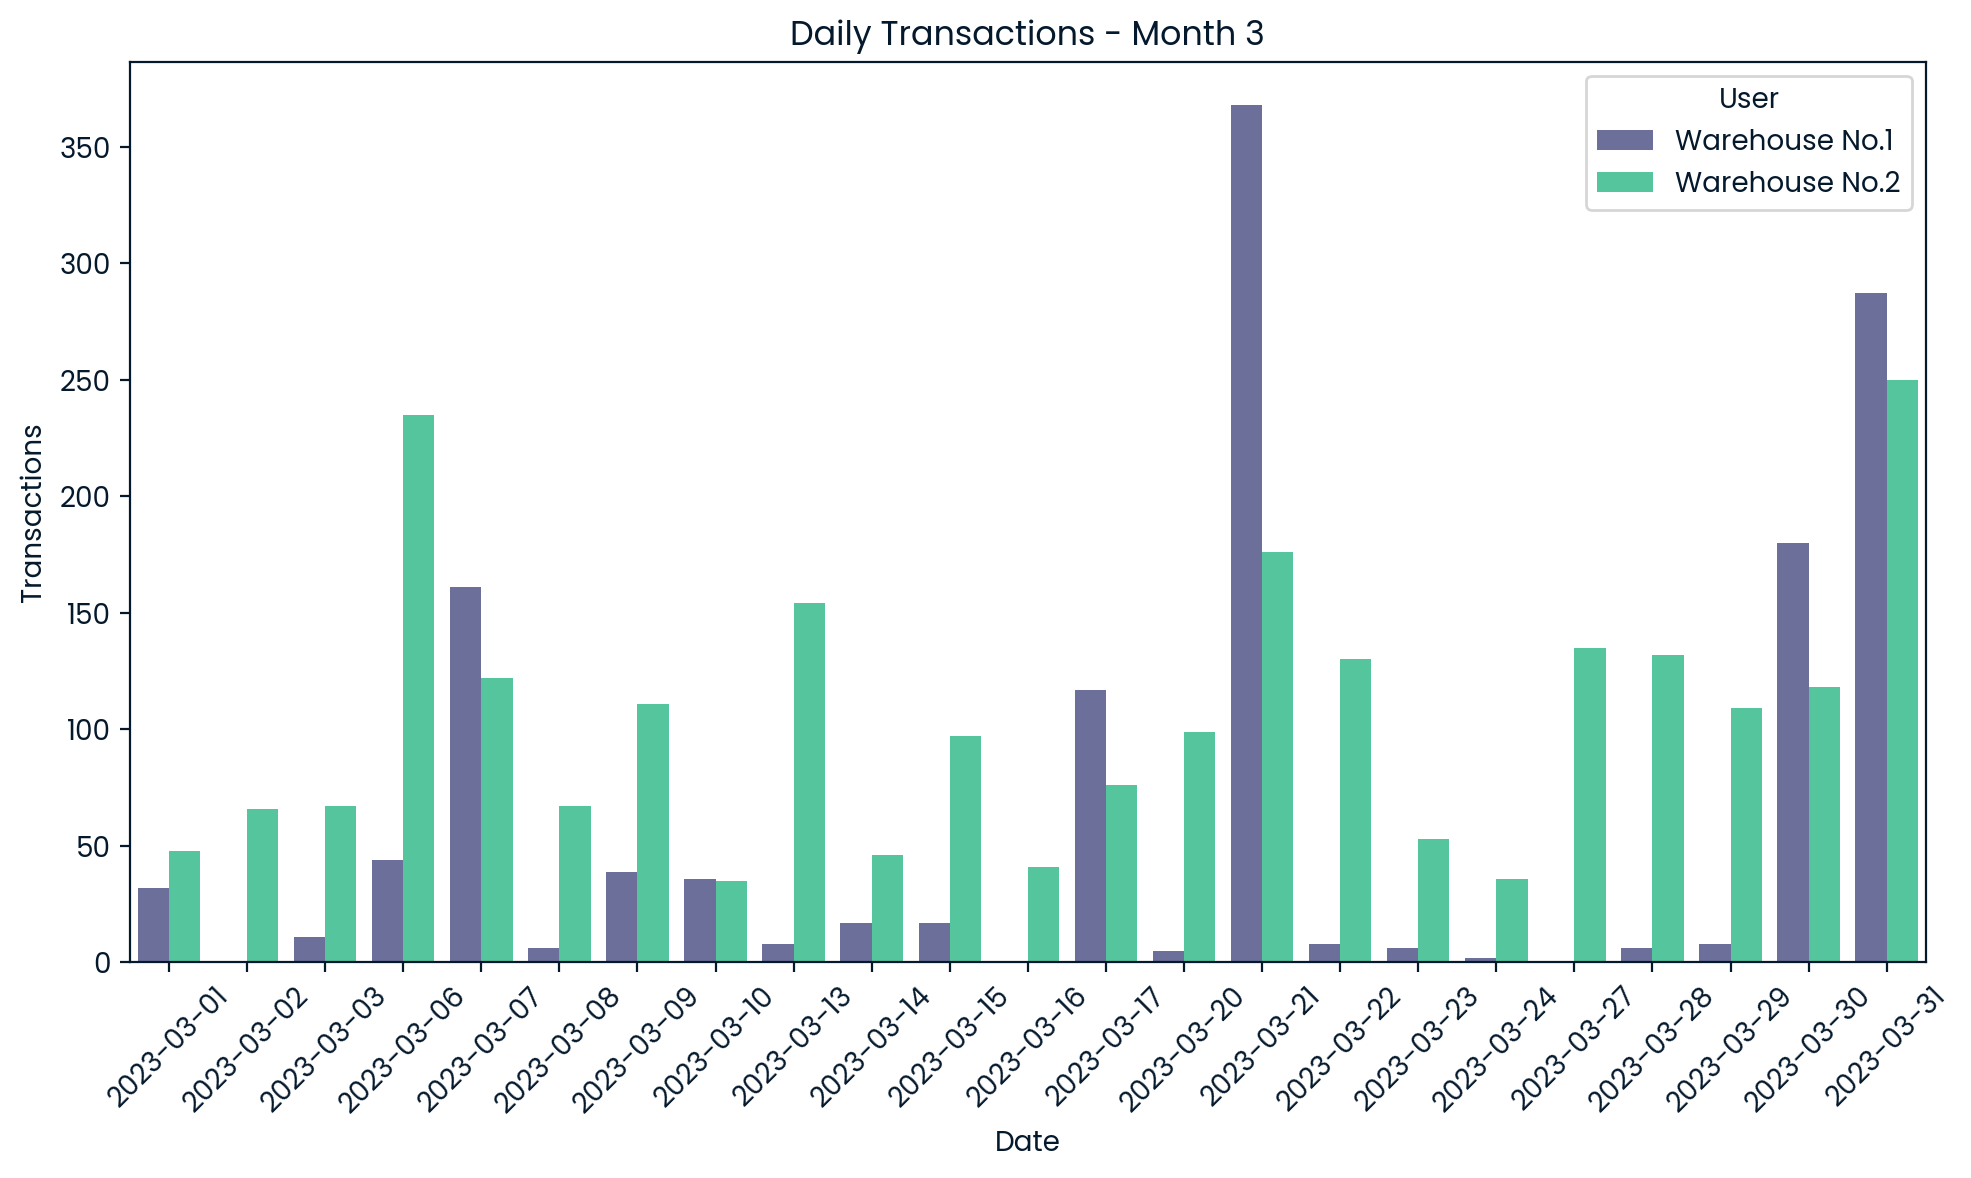

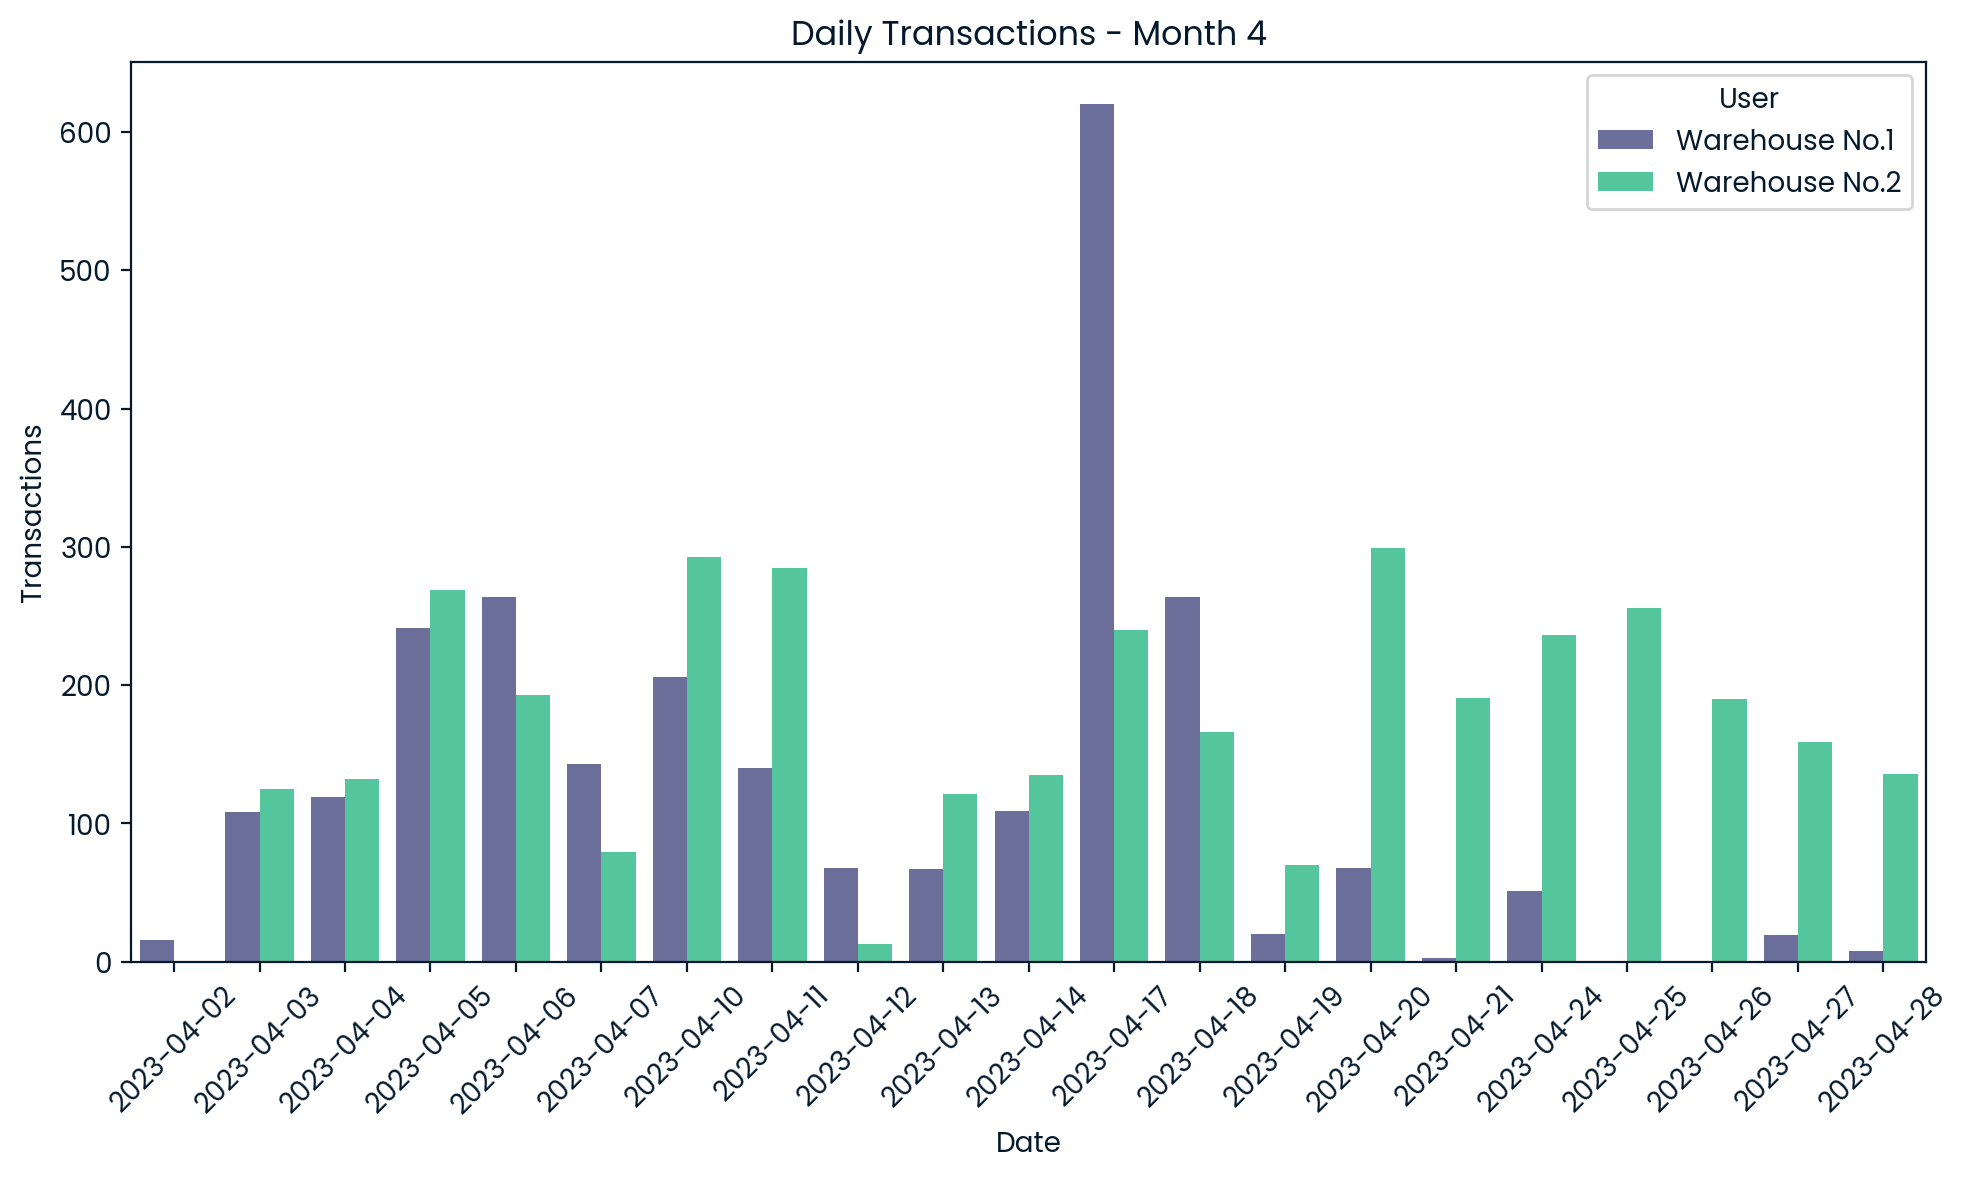

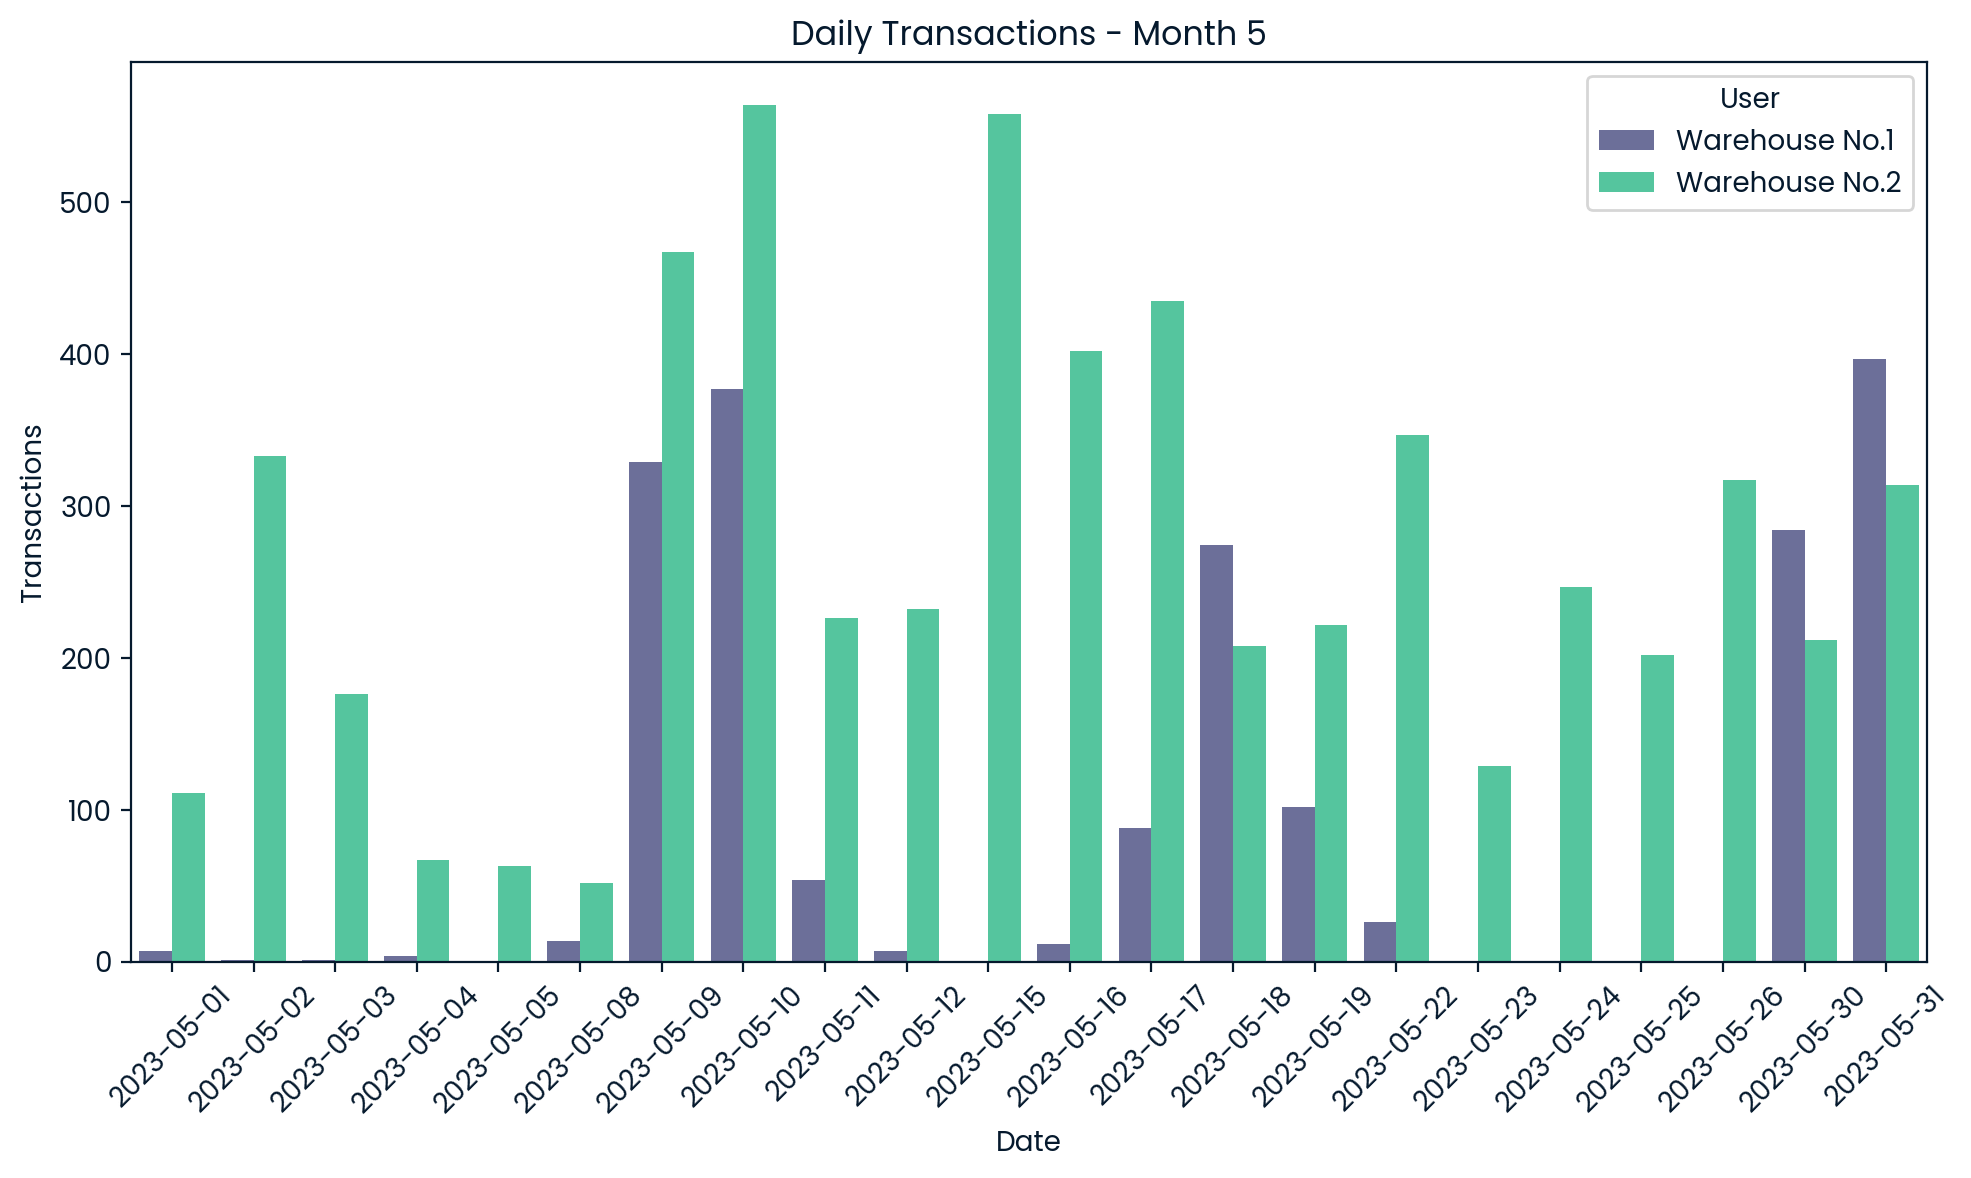

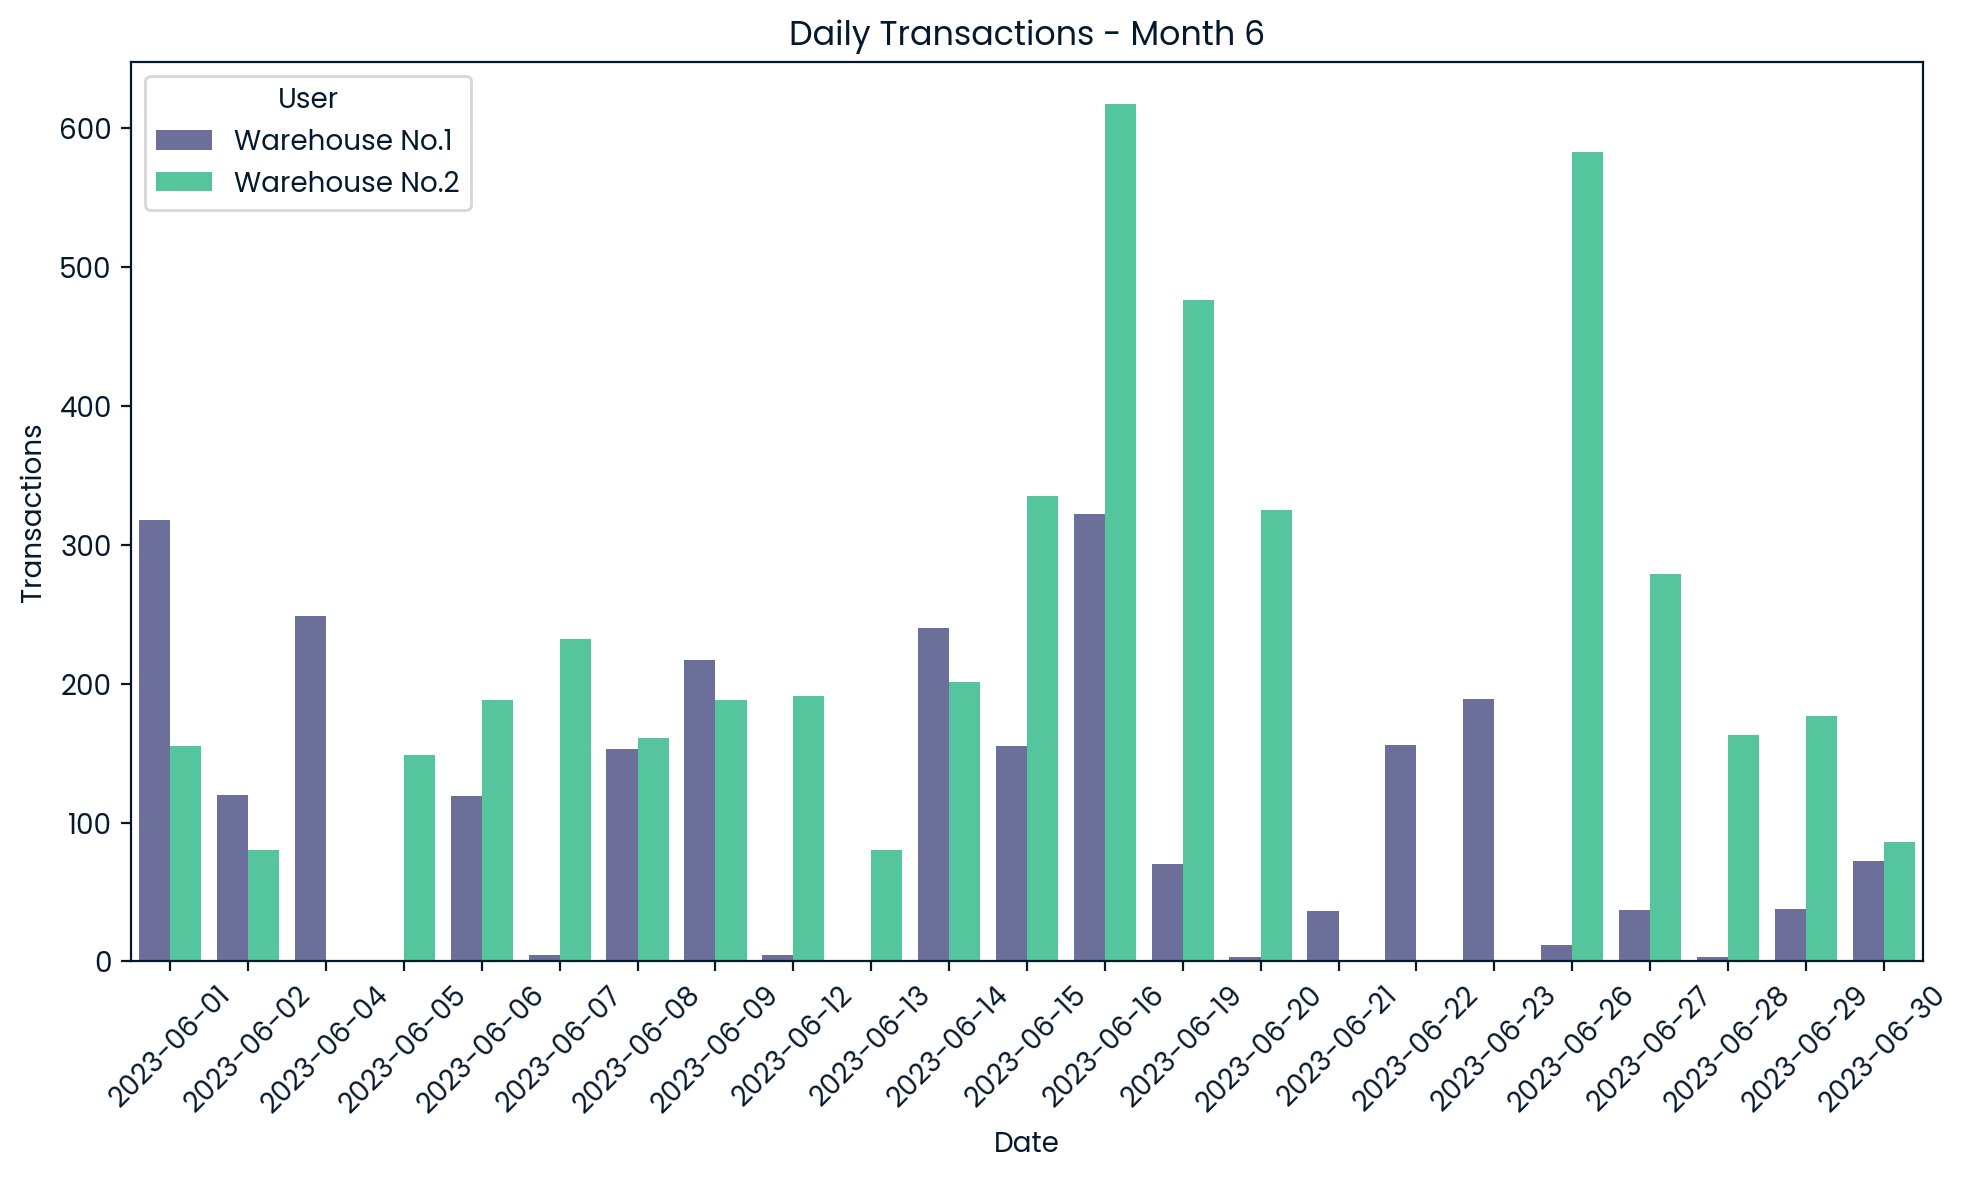

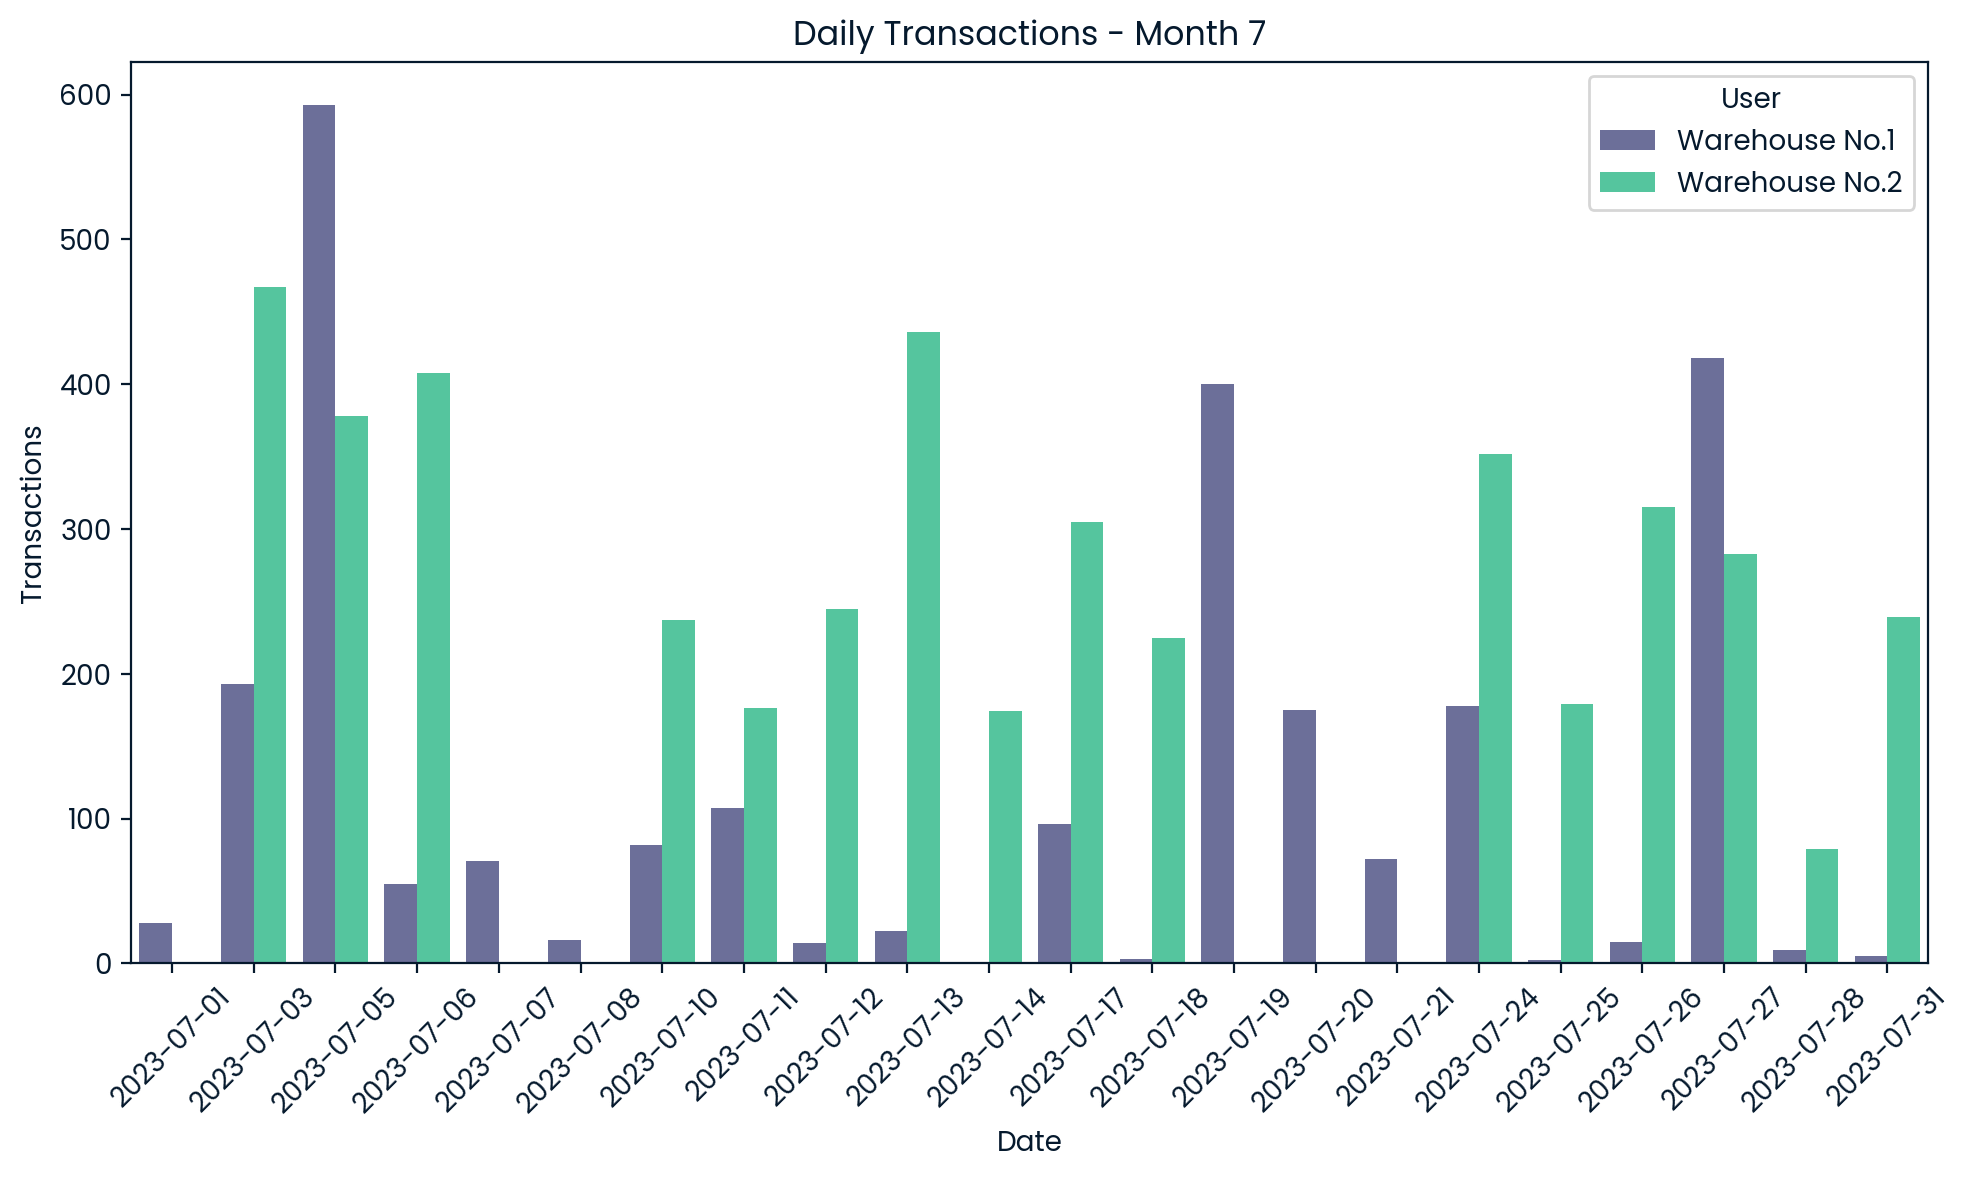

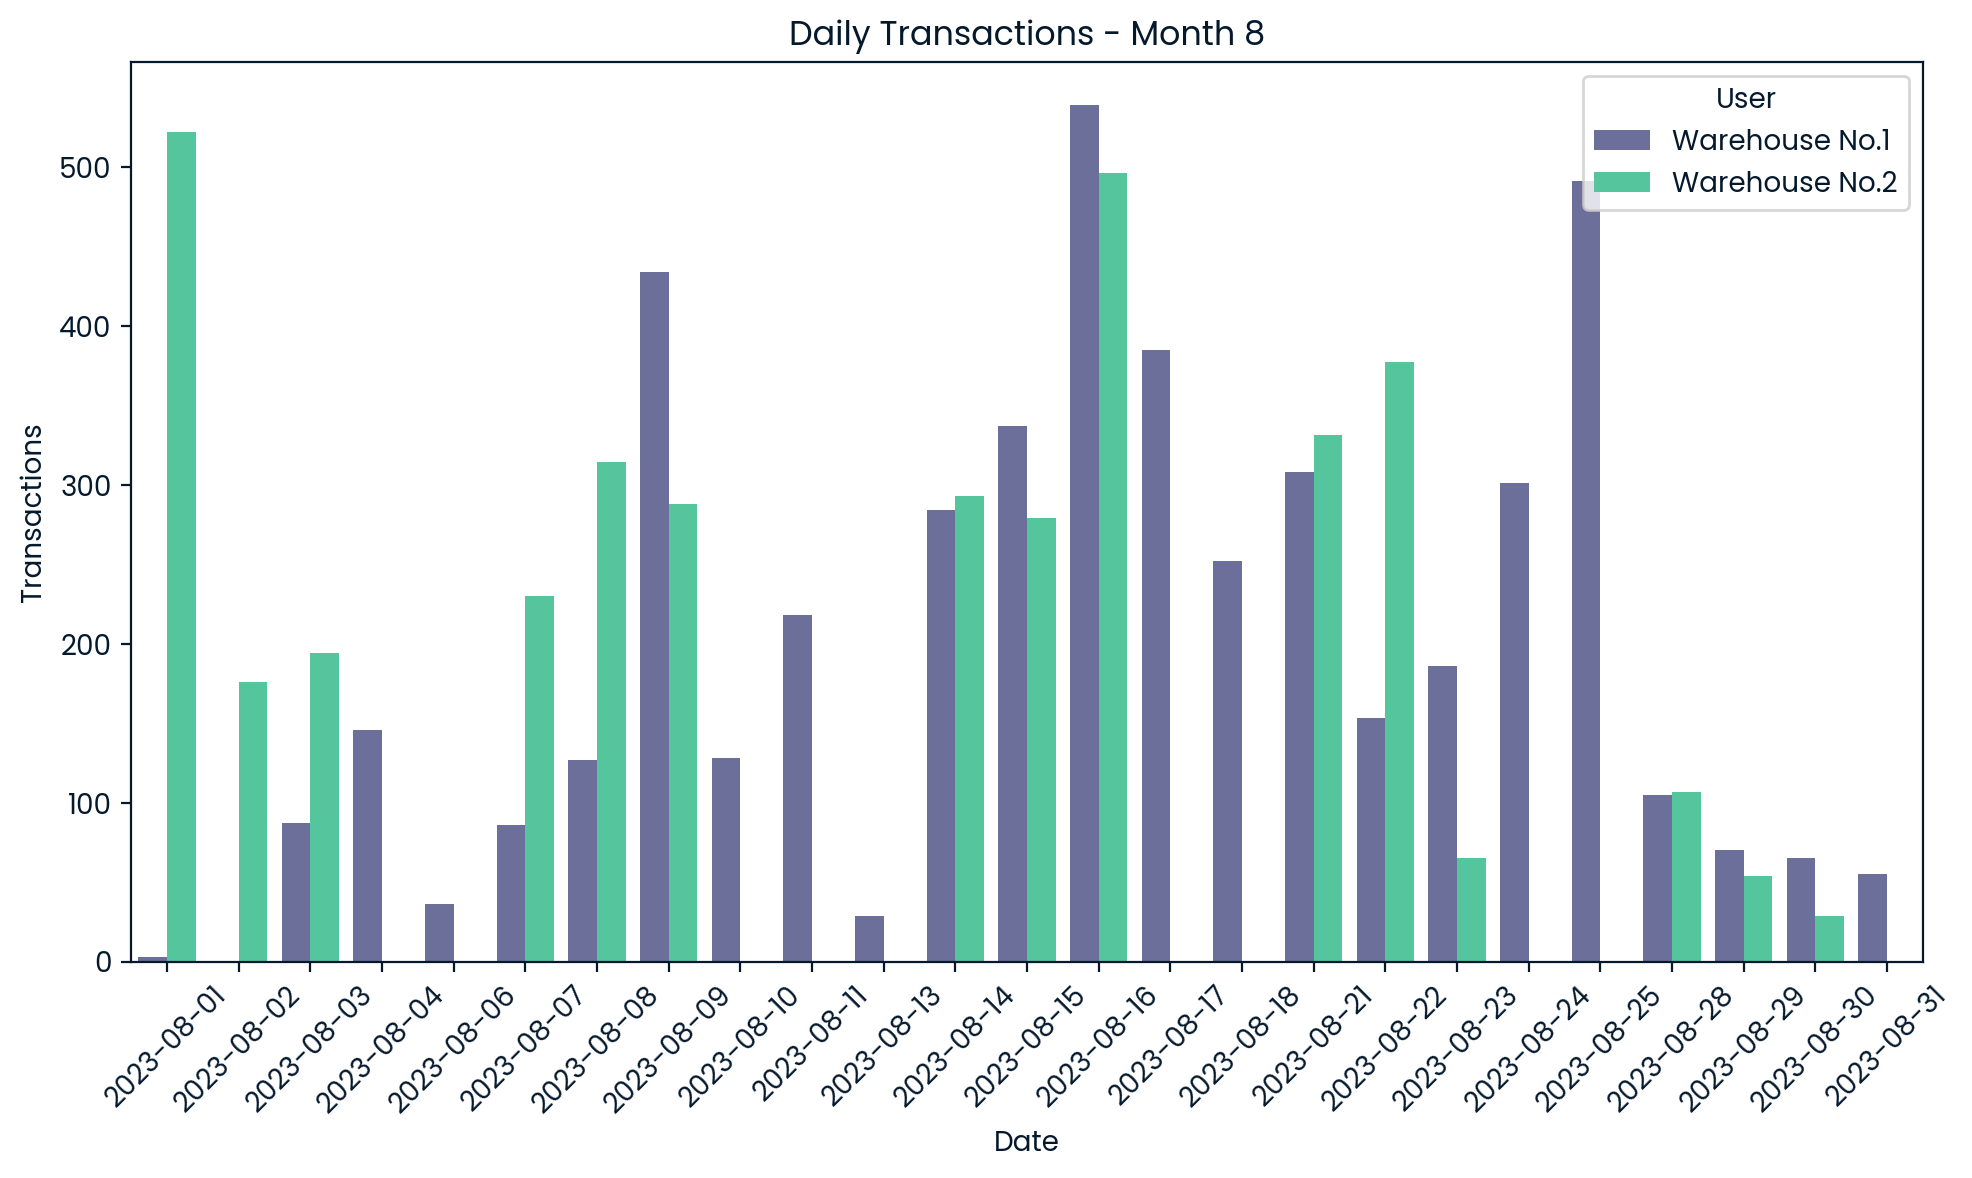

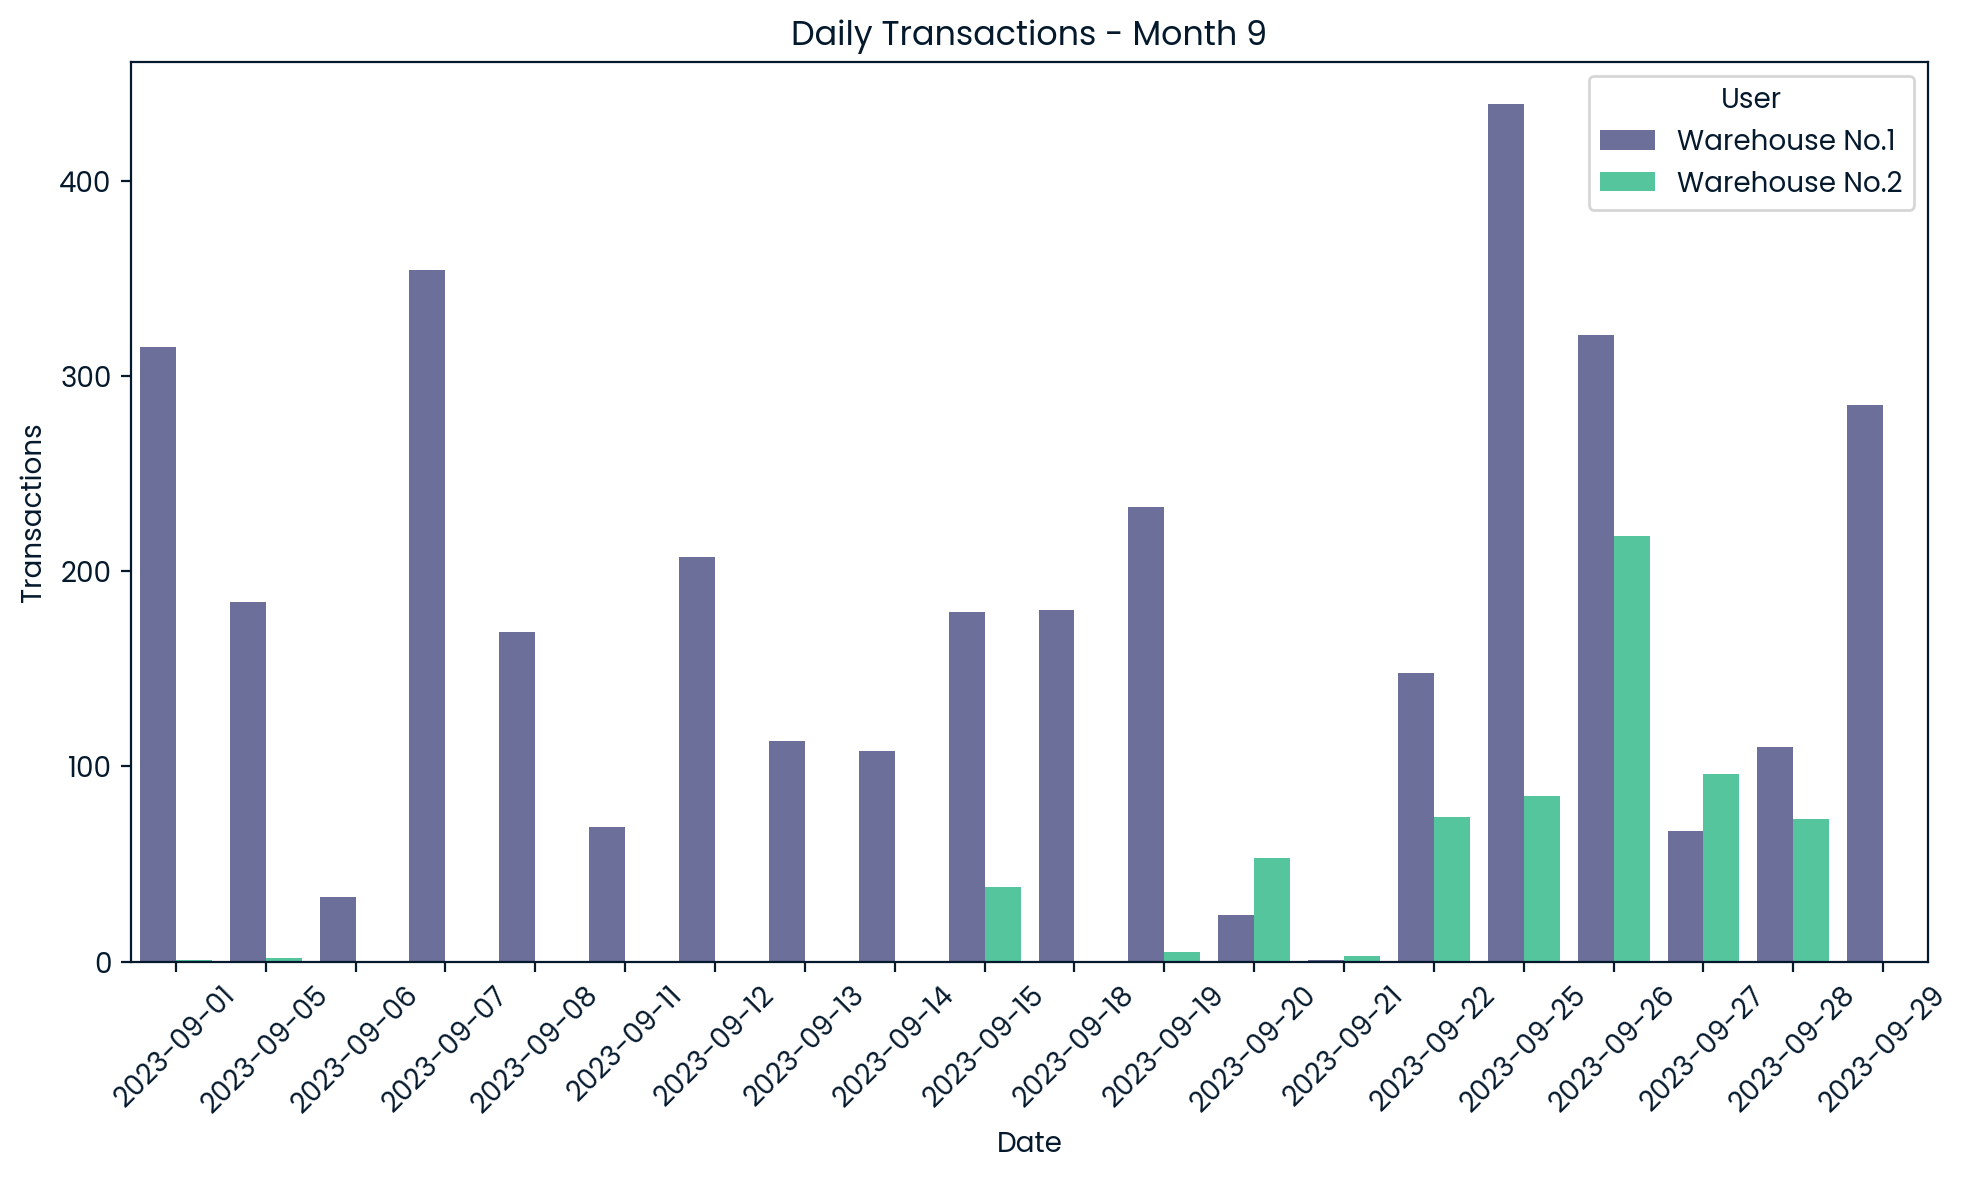

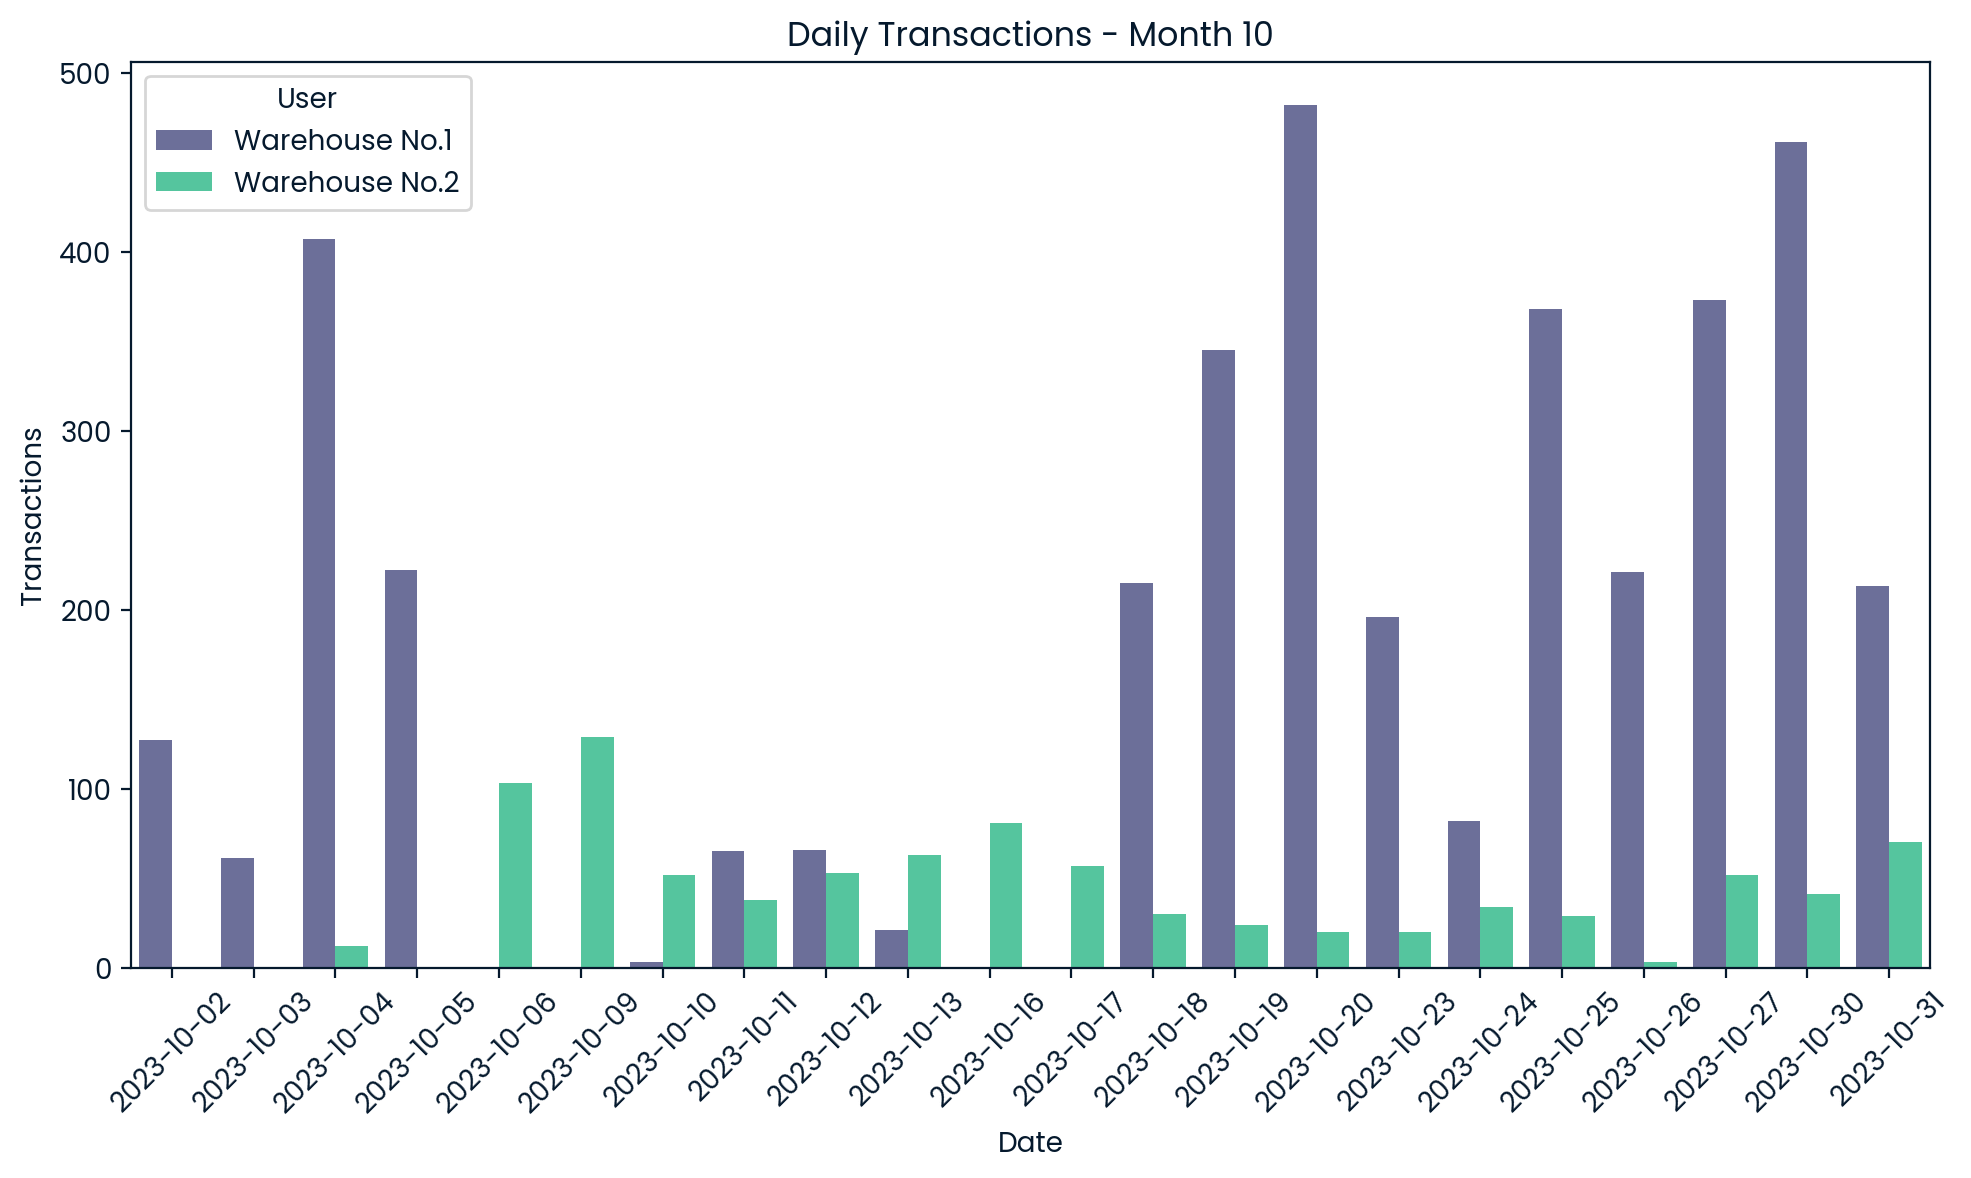

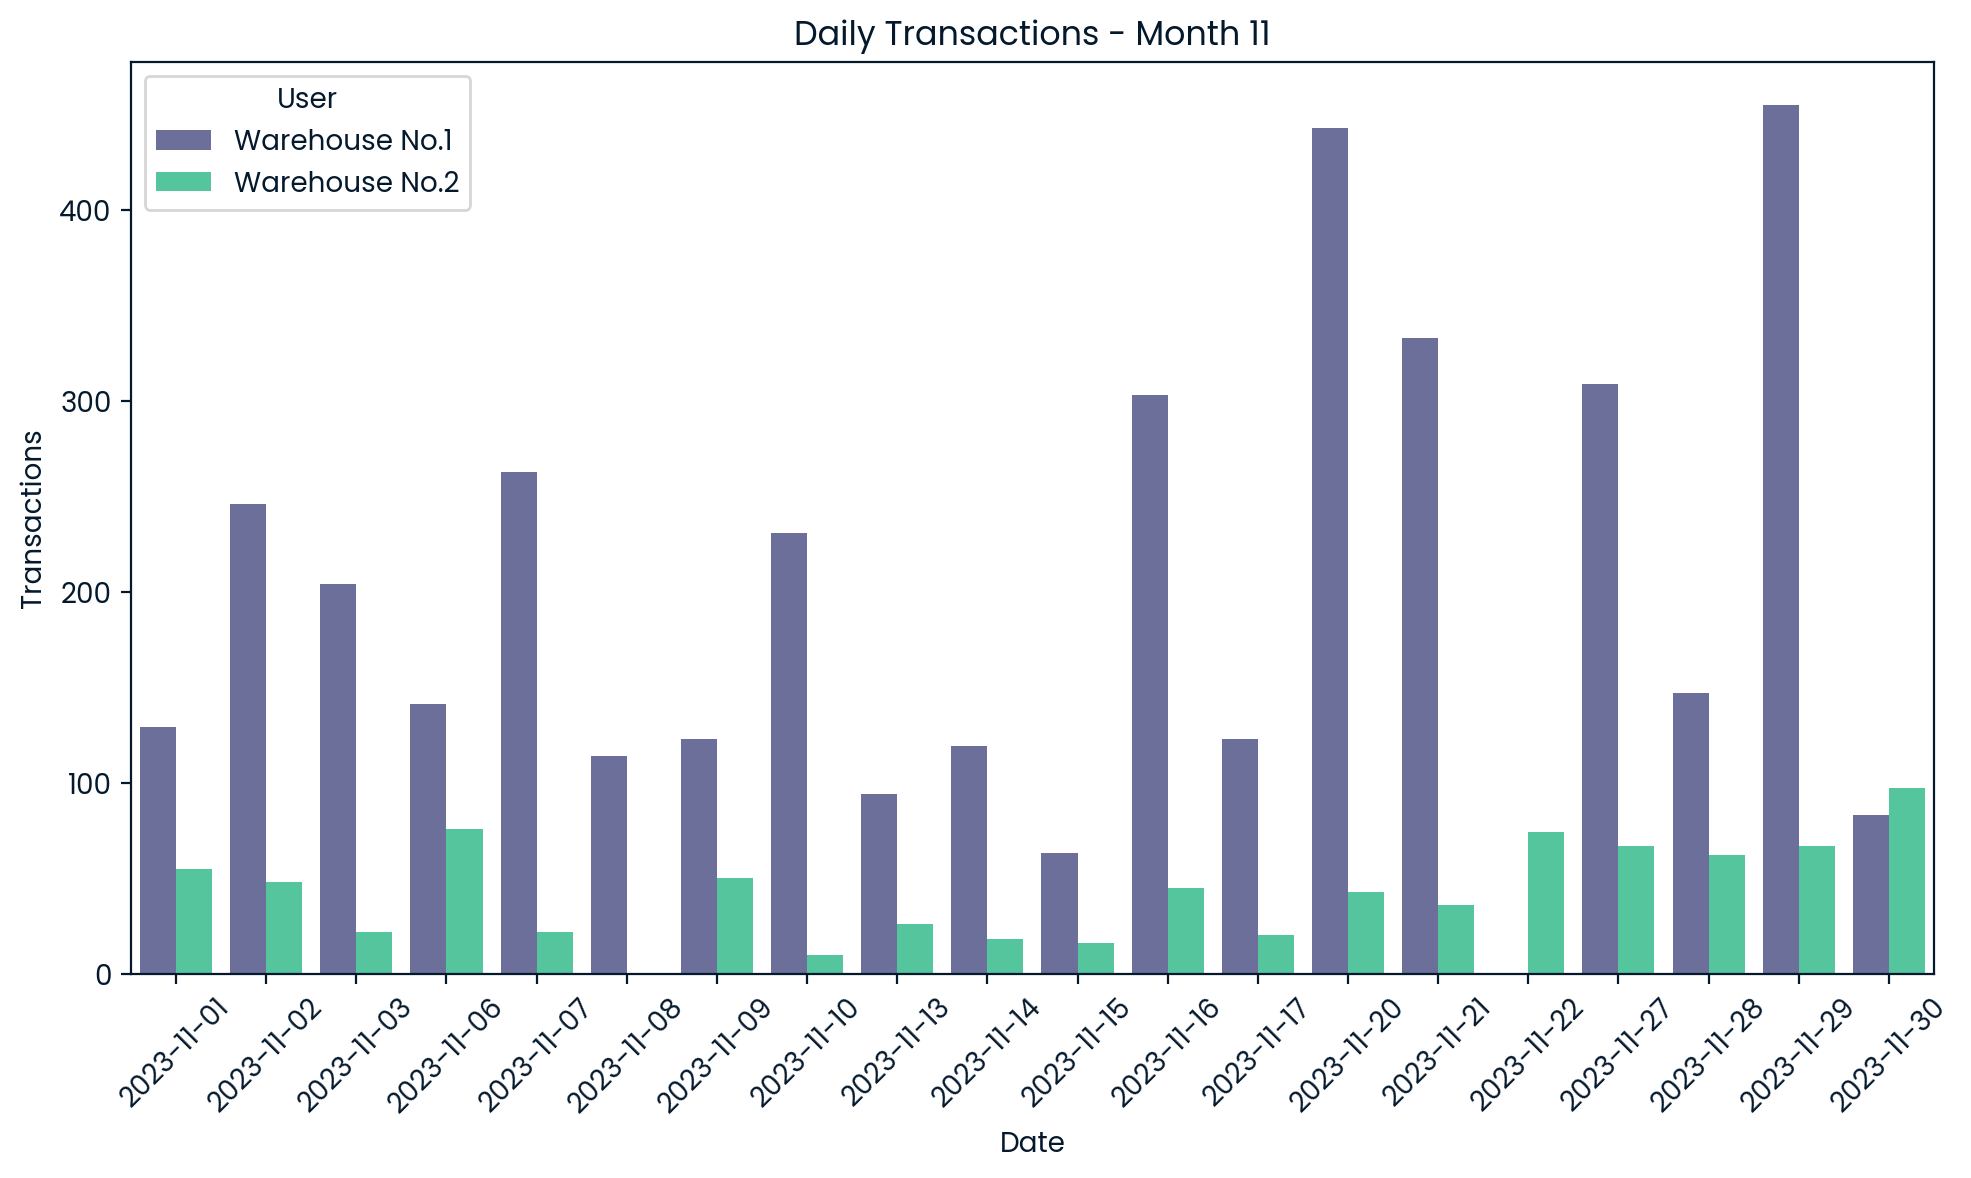

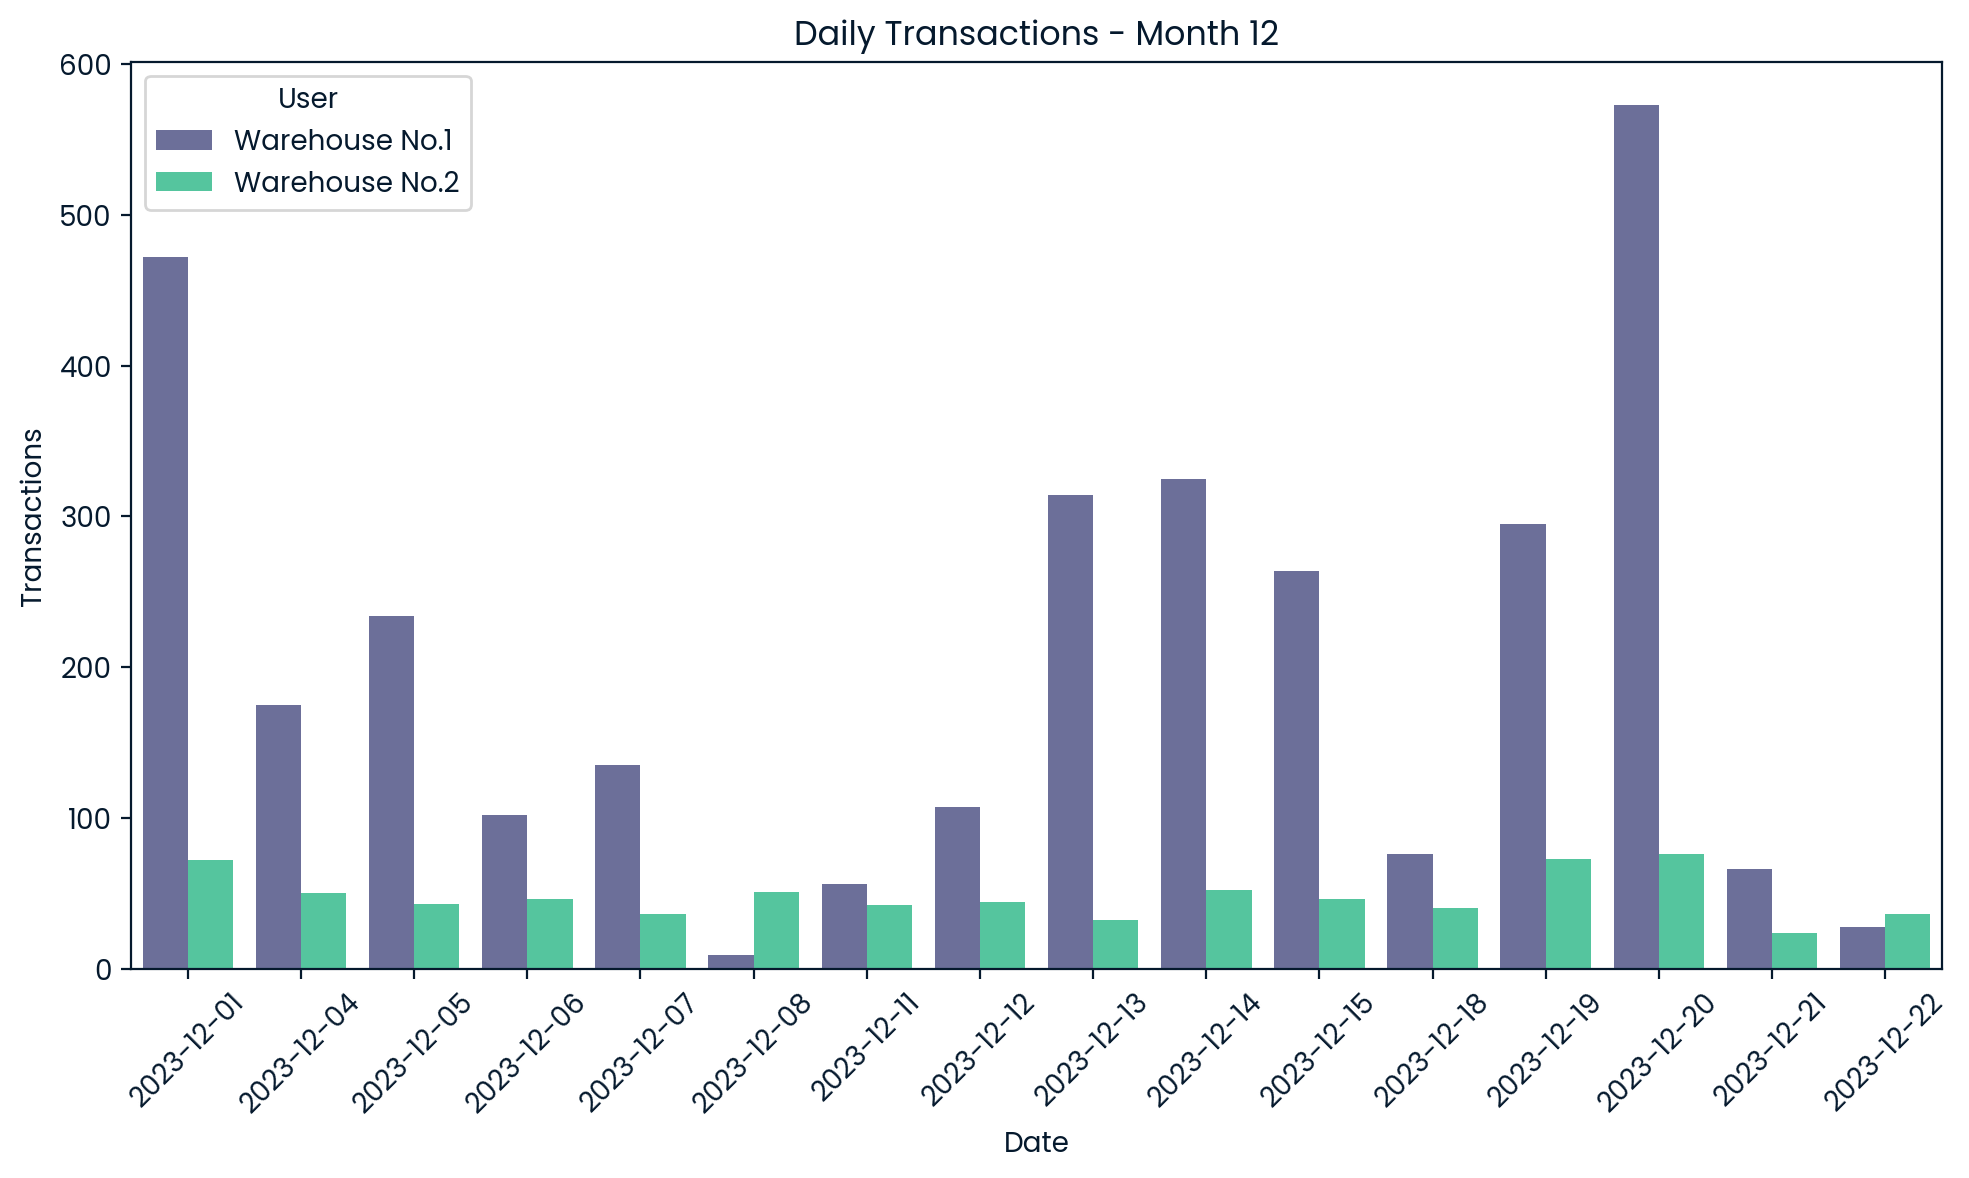

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create bar plots for a given metric
def plot_monthly_metric(data, metric, months, title):
    for month in months:
        # Filter data for the specific month
        monthly_data = data[data['Month'] == month]

        # Create the plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Date', y=metric, hue='User', data=monthly_data)
        plt.title(f'{title} - Month {month}')
        plt.xlabel('Date')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.legend(title='User')
        plt.tight_layout()
        plt.show()

# List of unique months in the dataset
unique_months = merged_data['Month'].unique()

# Plotting Transactions for each month
plot_monthly_metric(merged_data, 'Transactions', unique_months, 'Daily Transactions')


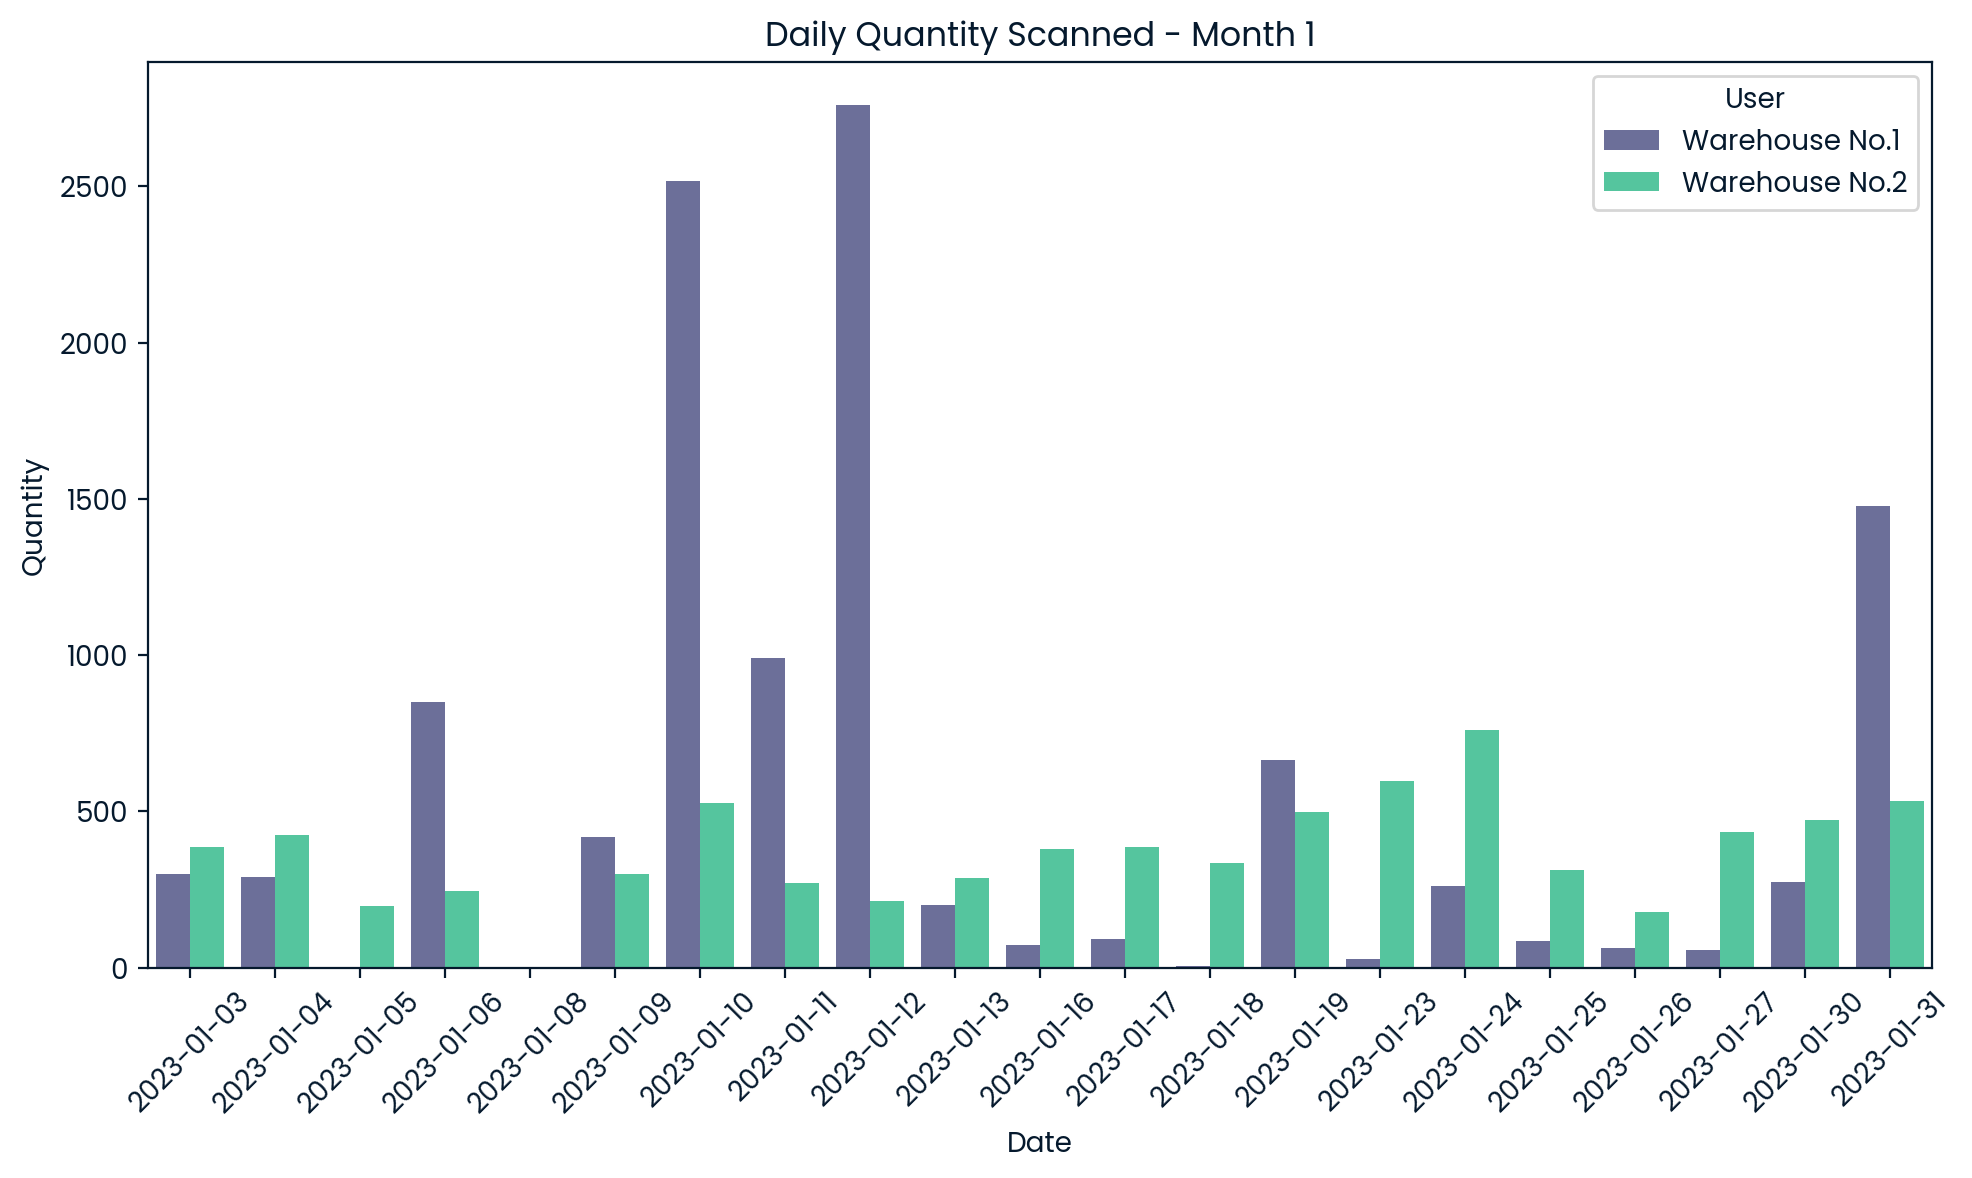

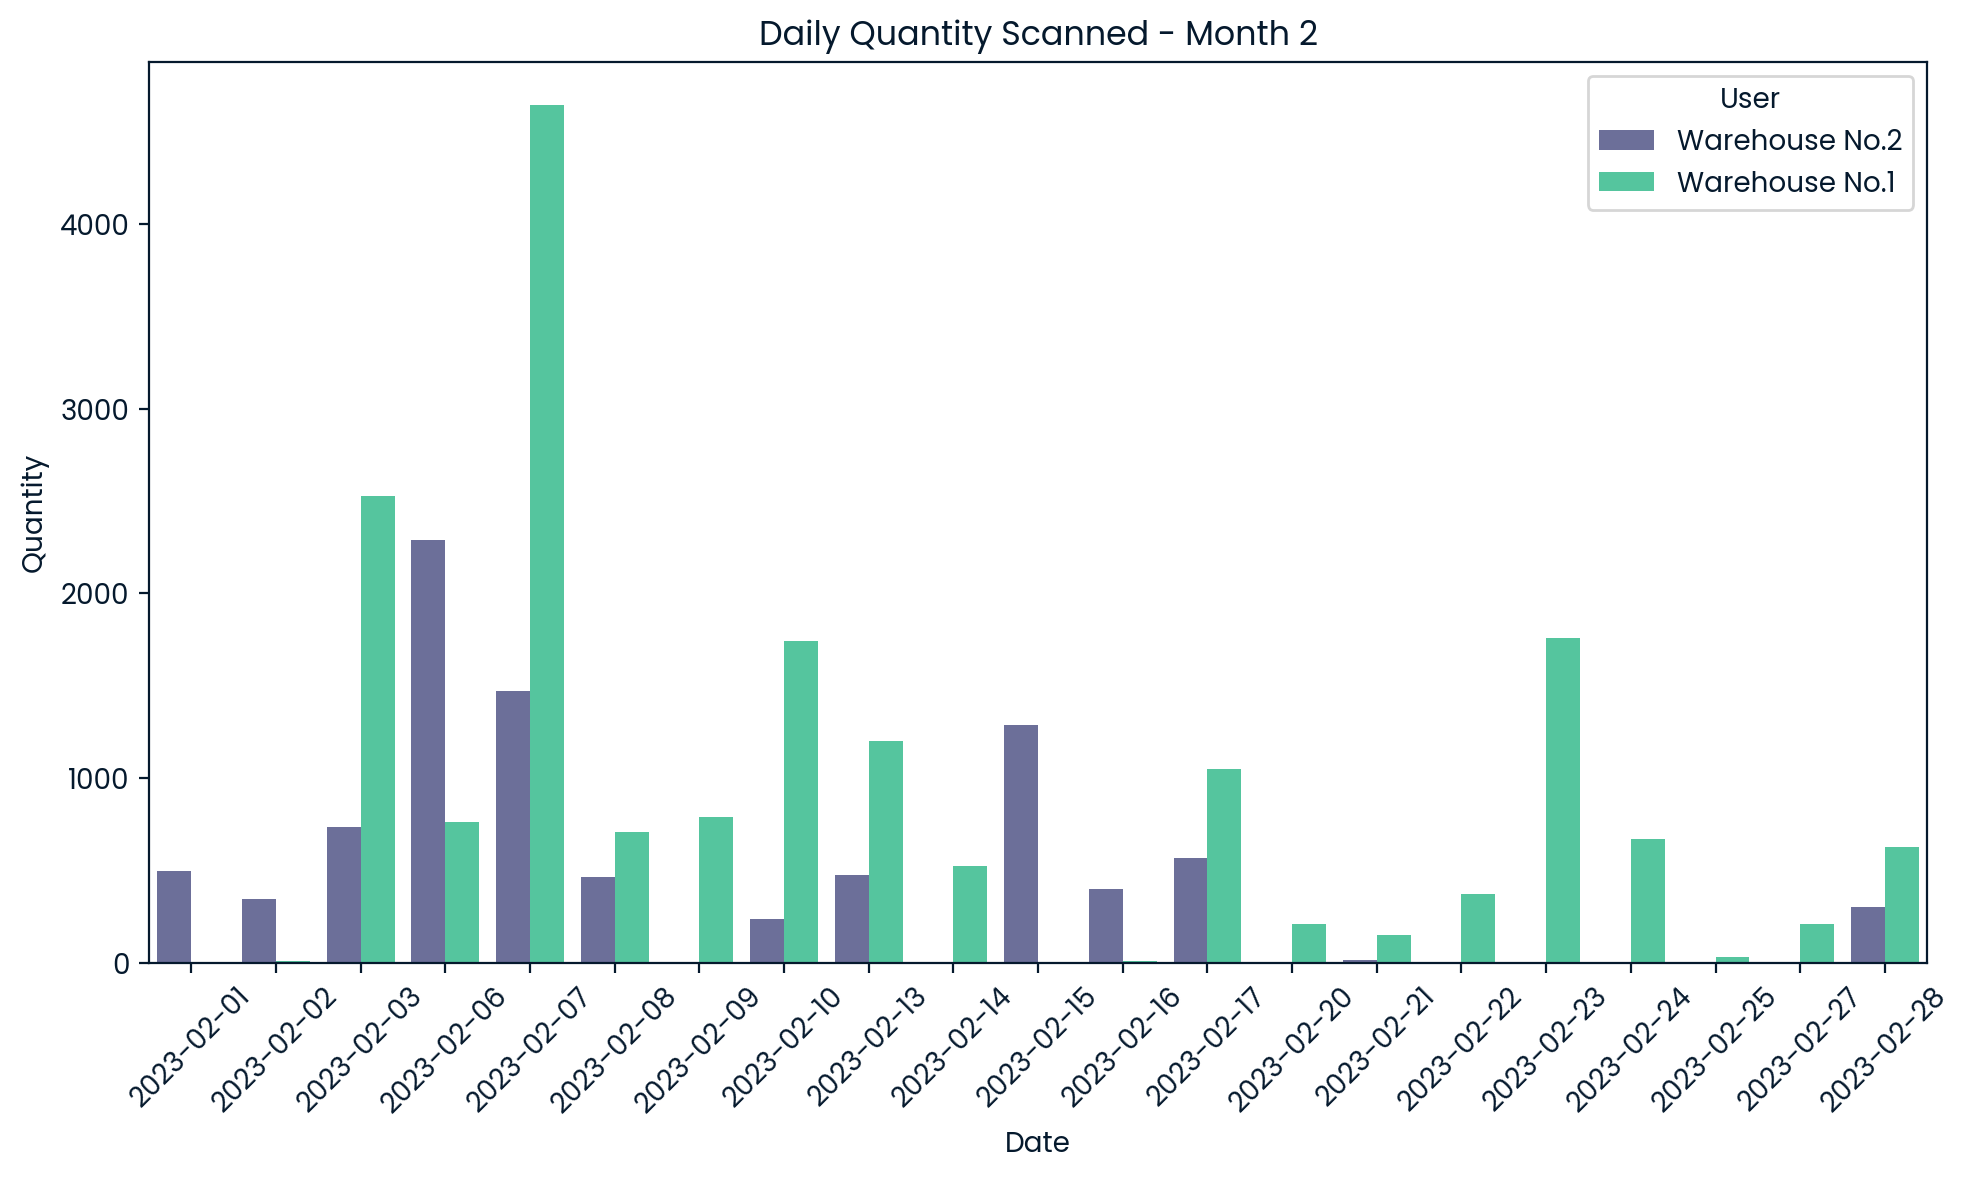

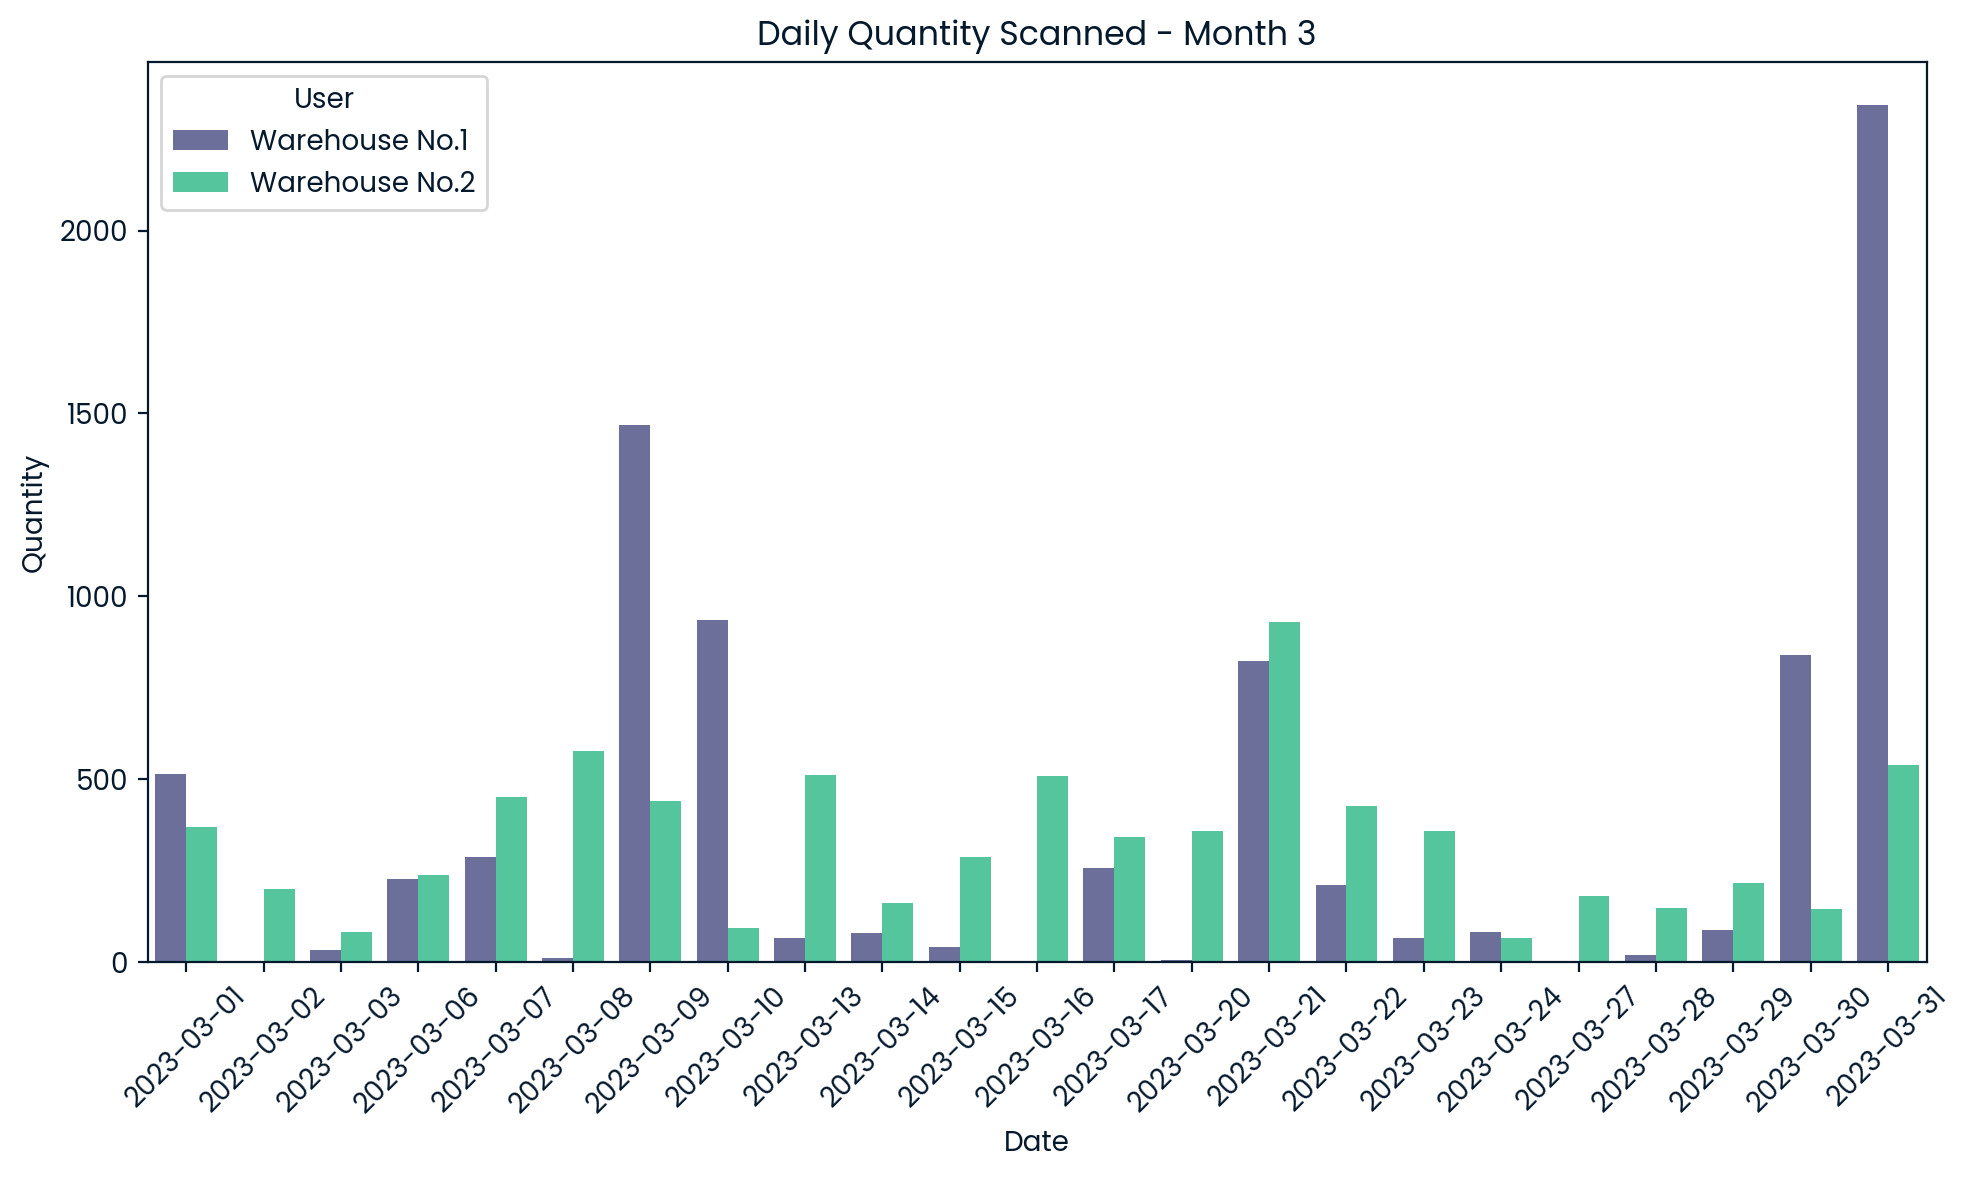

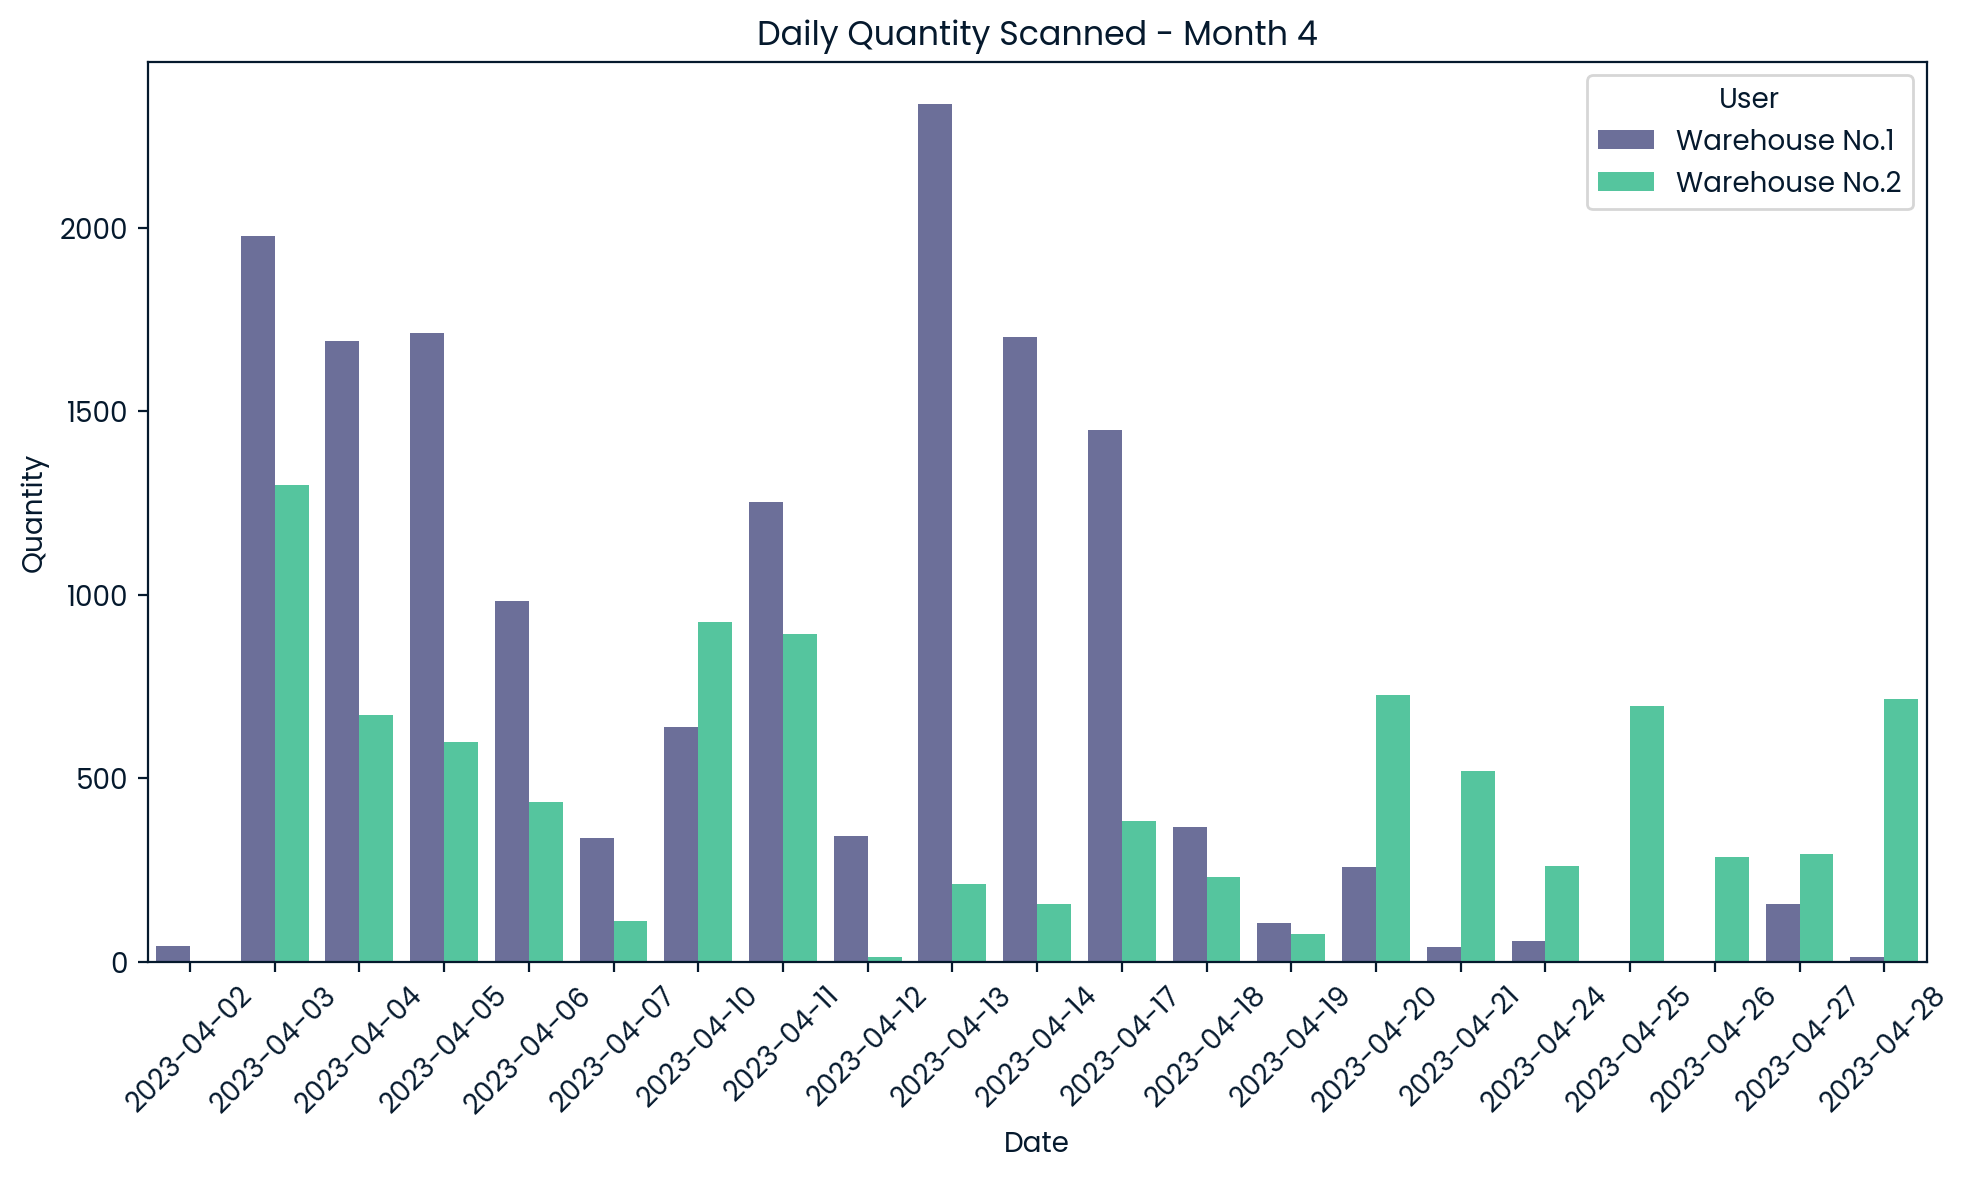

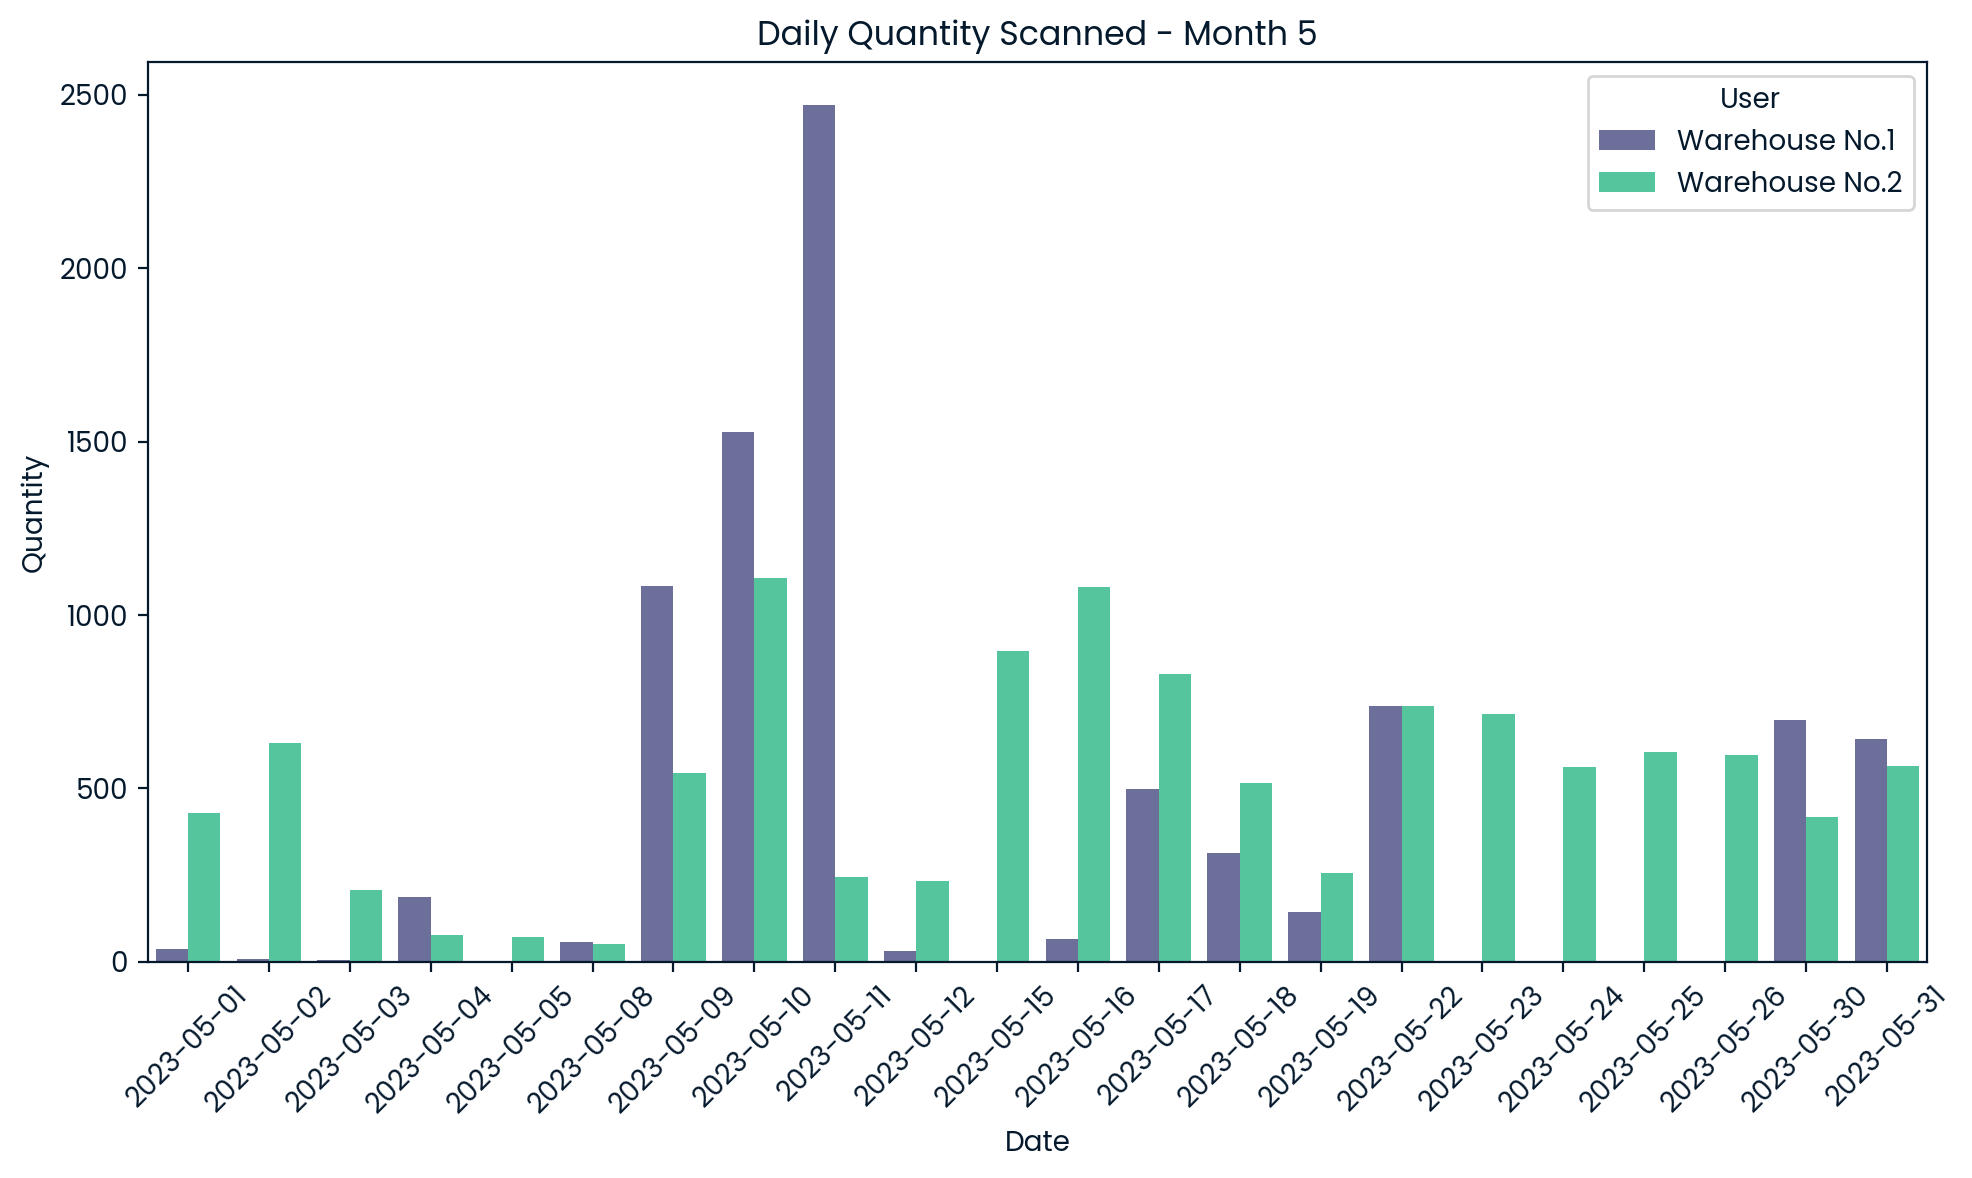

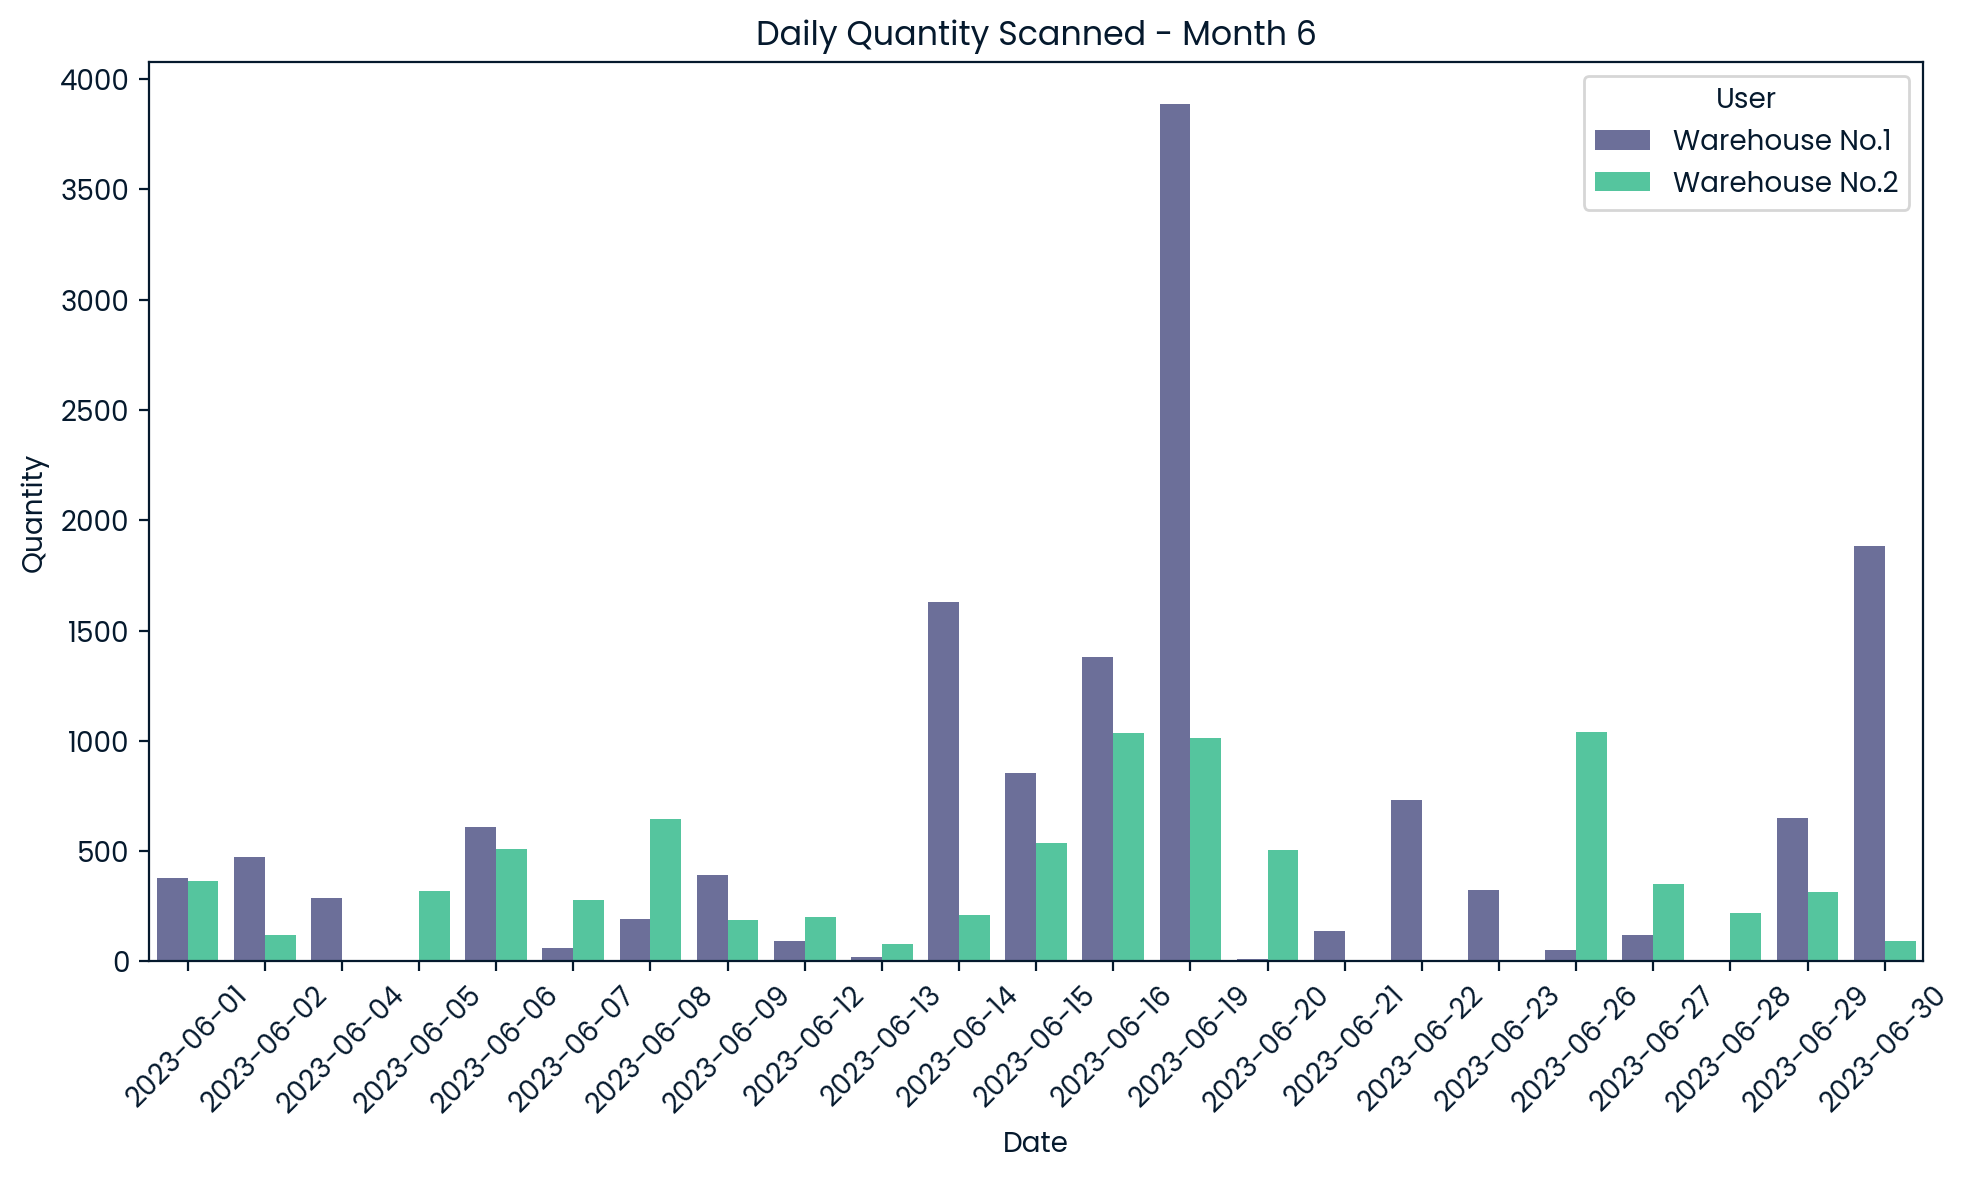

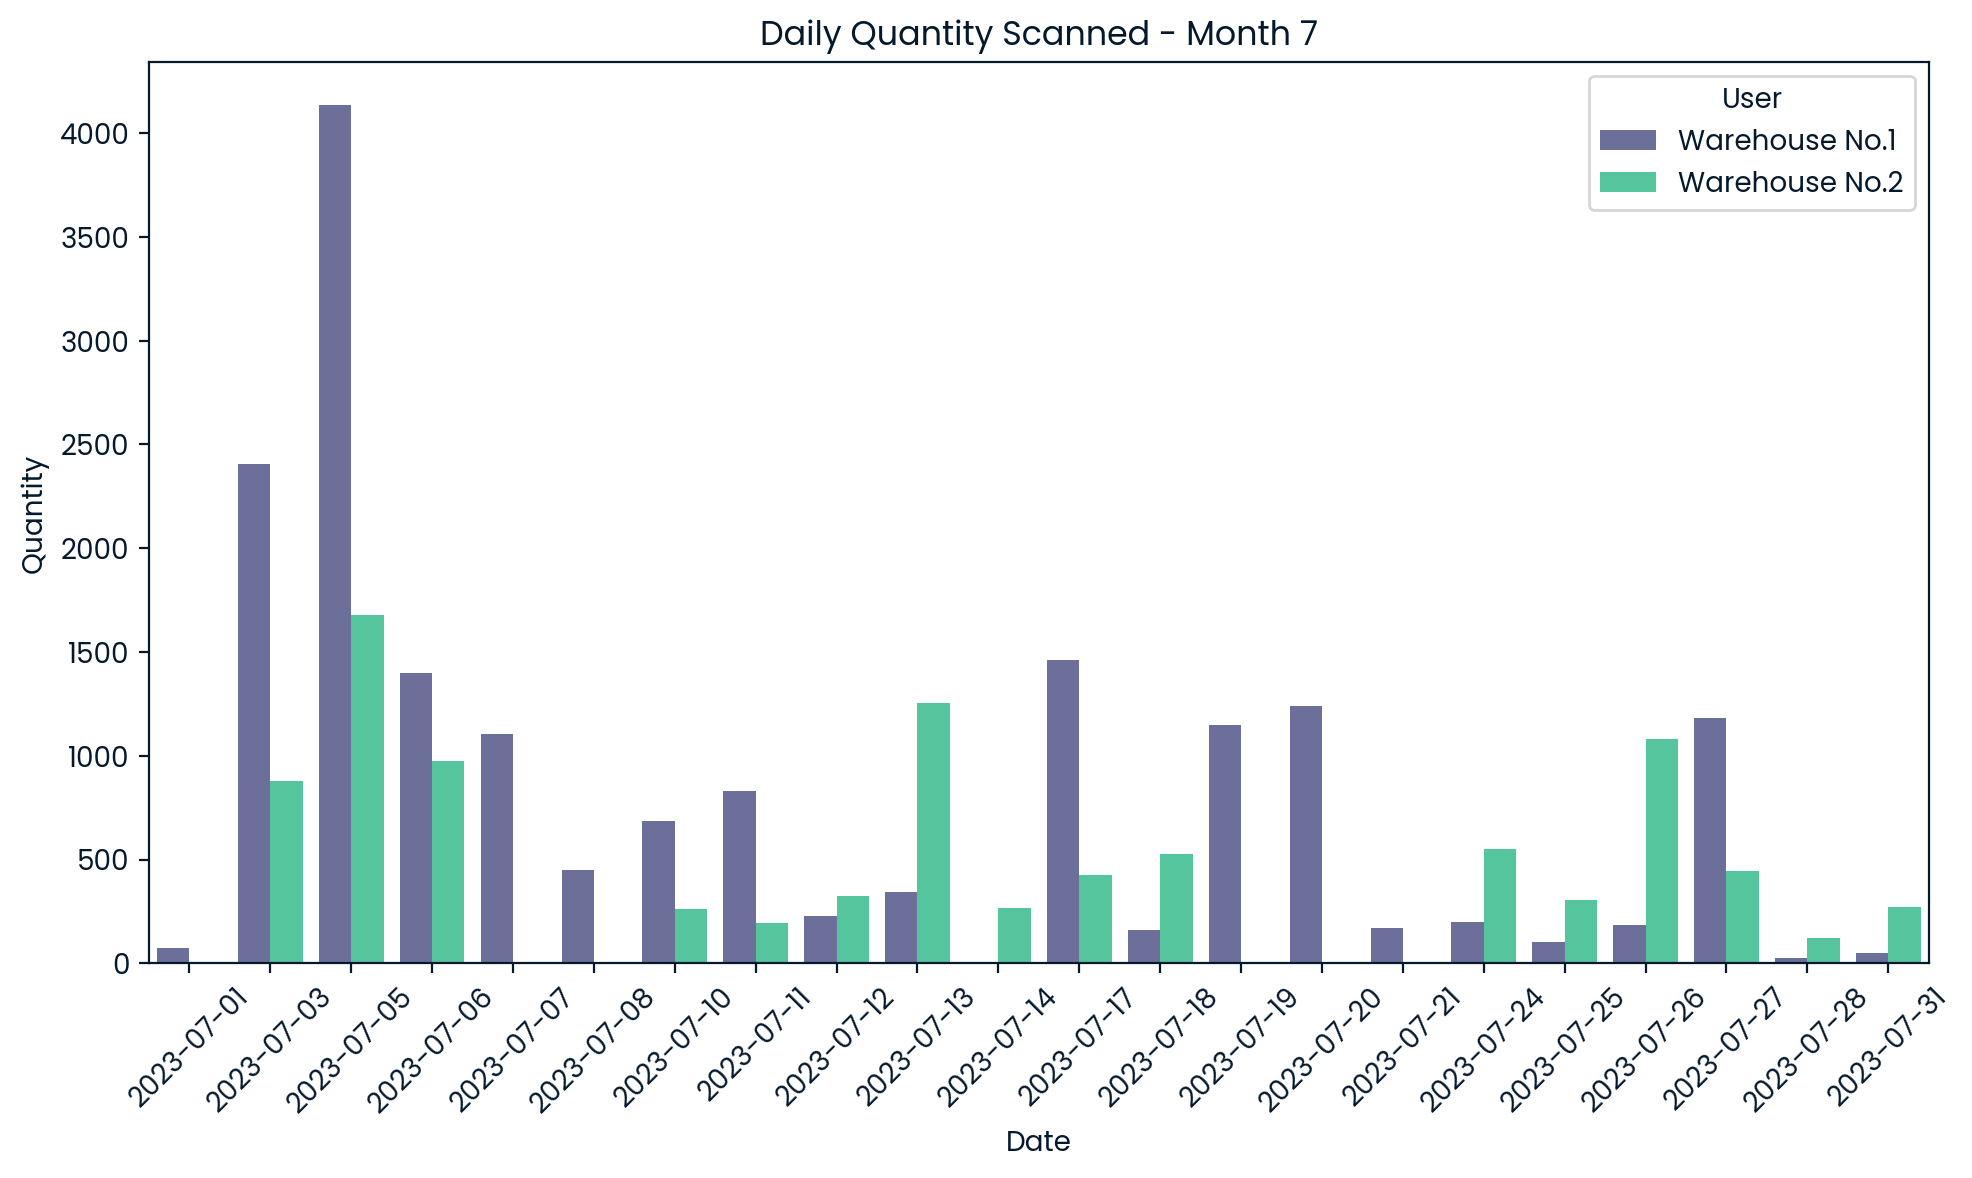

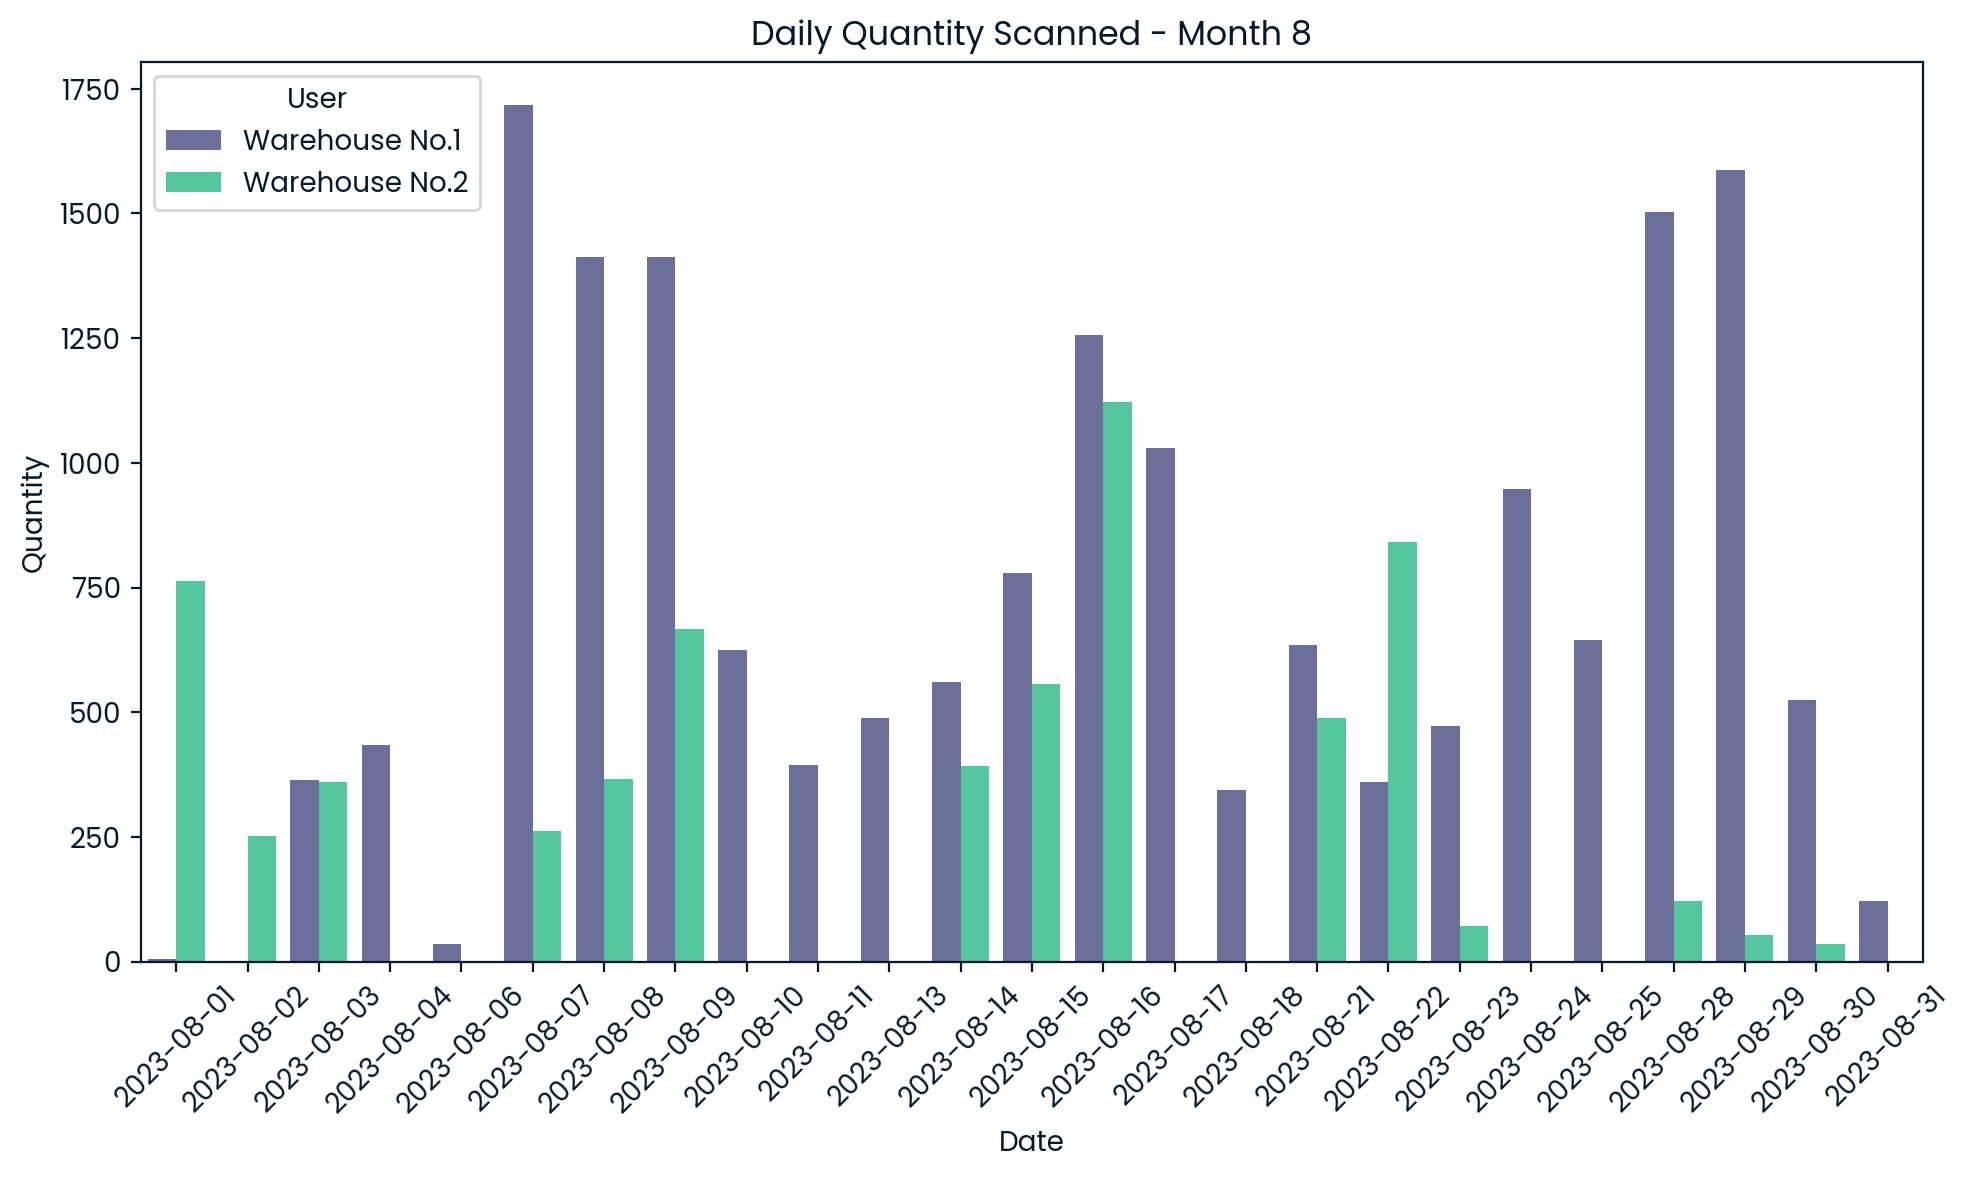

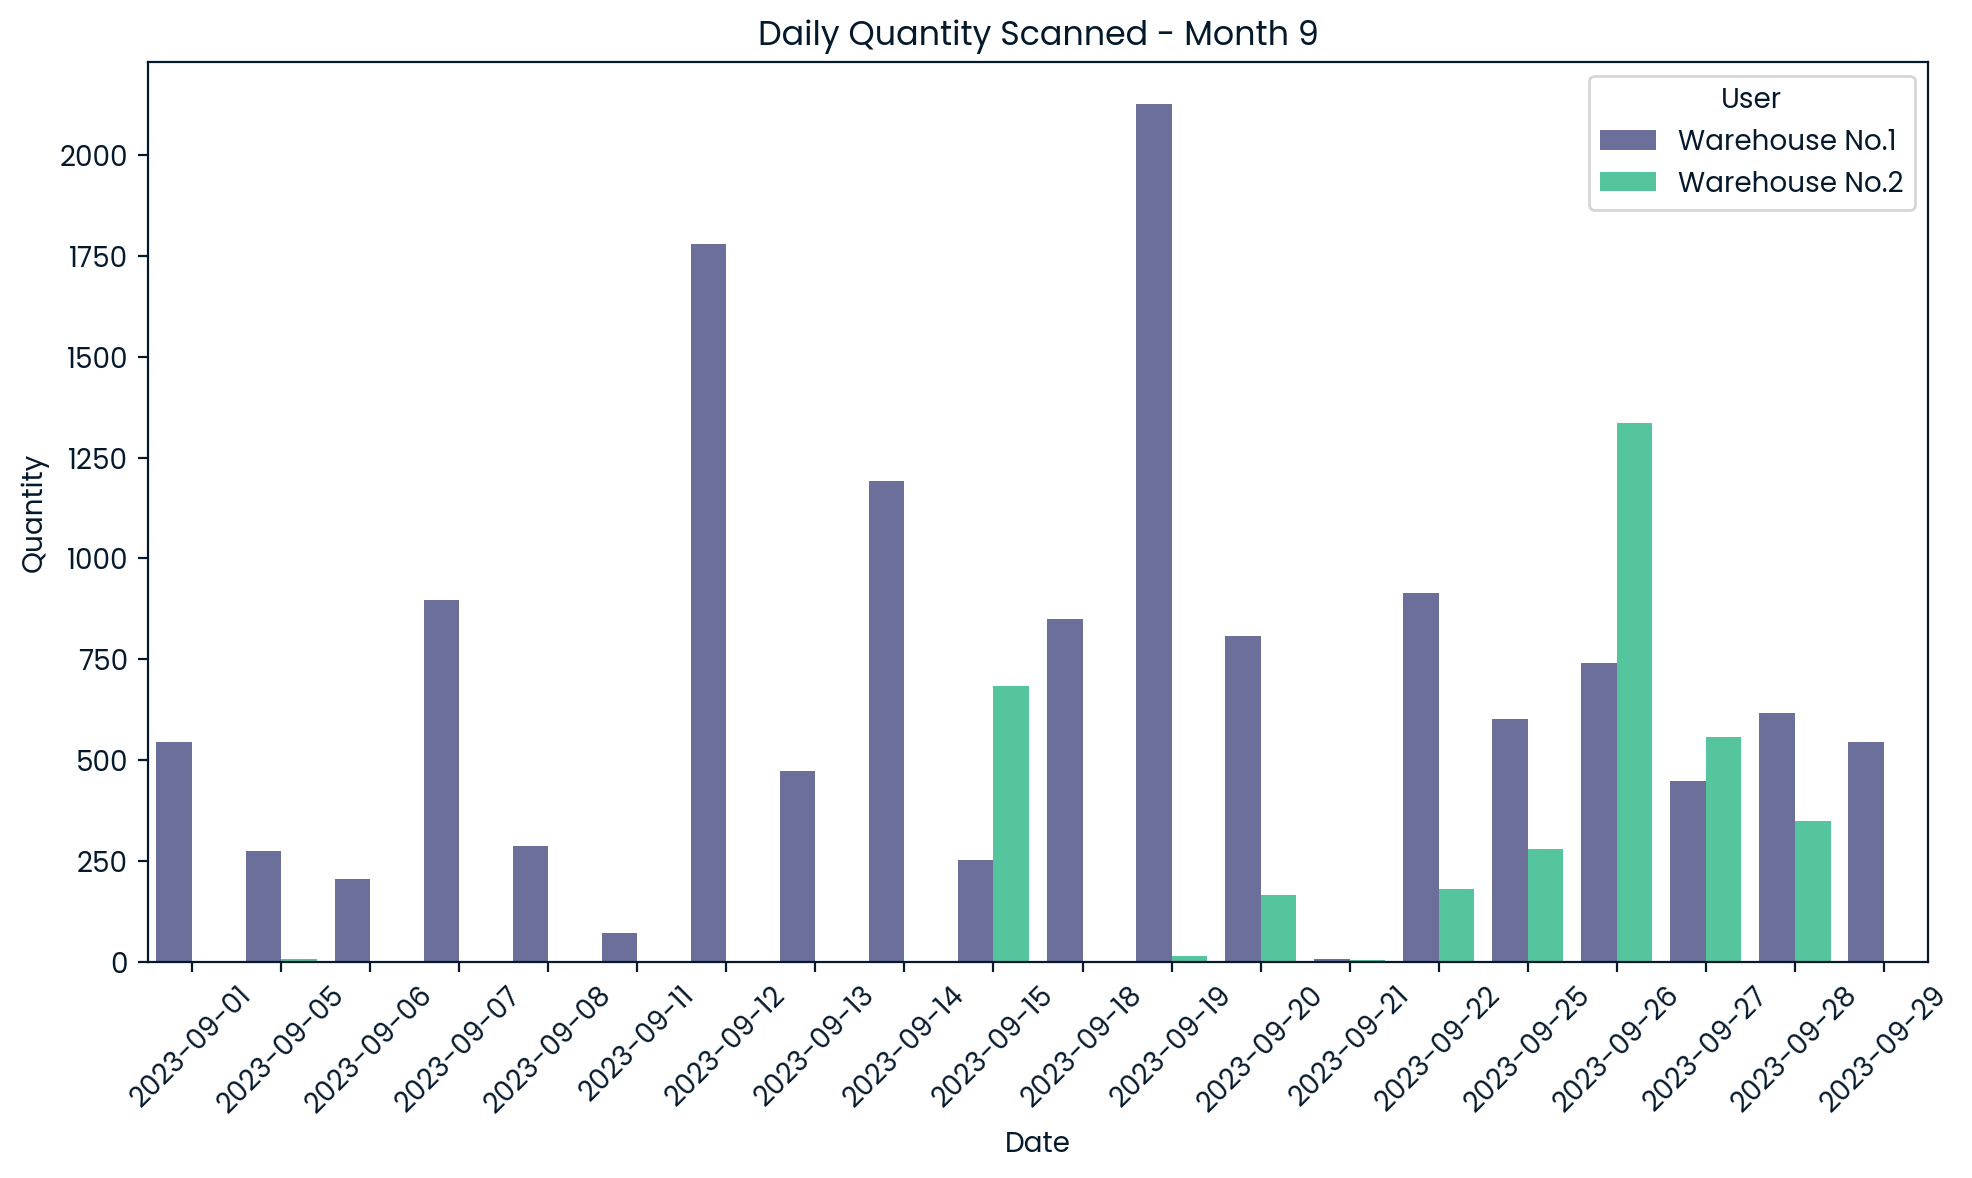

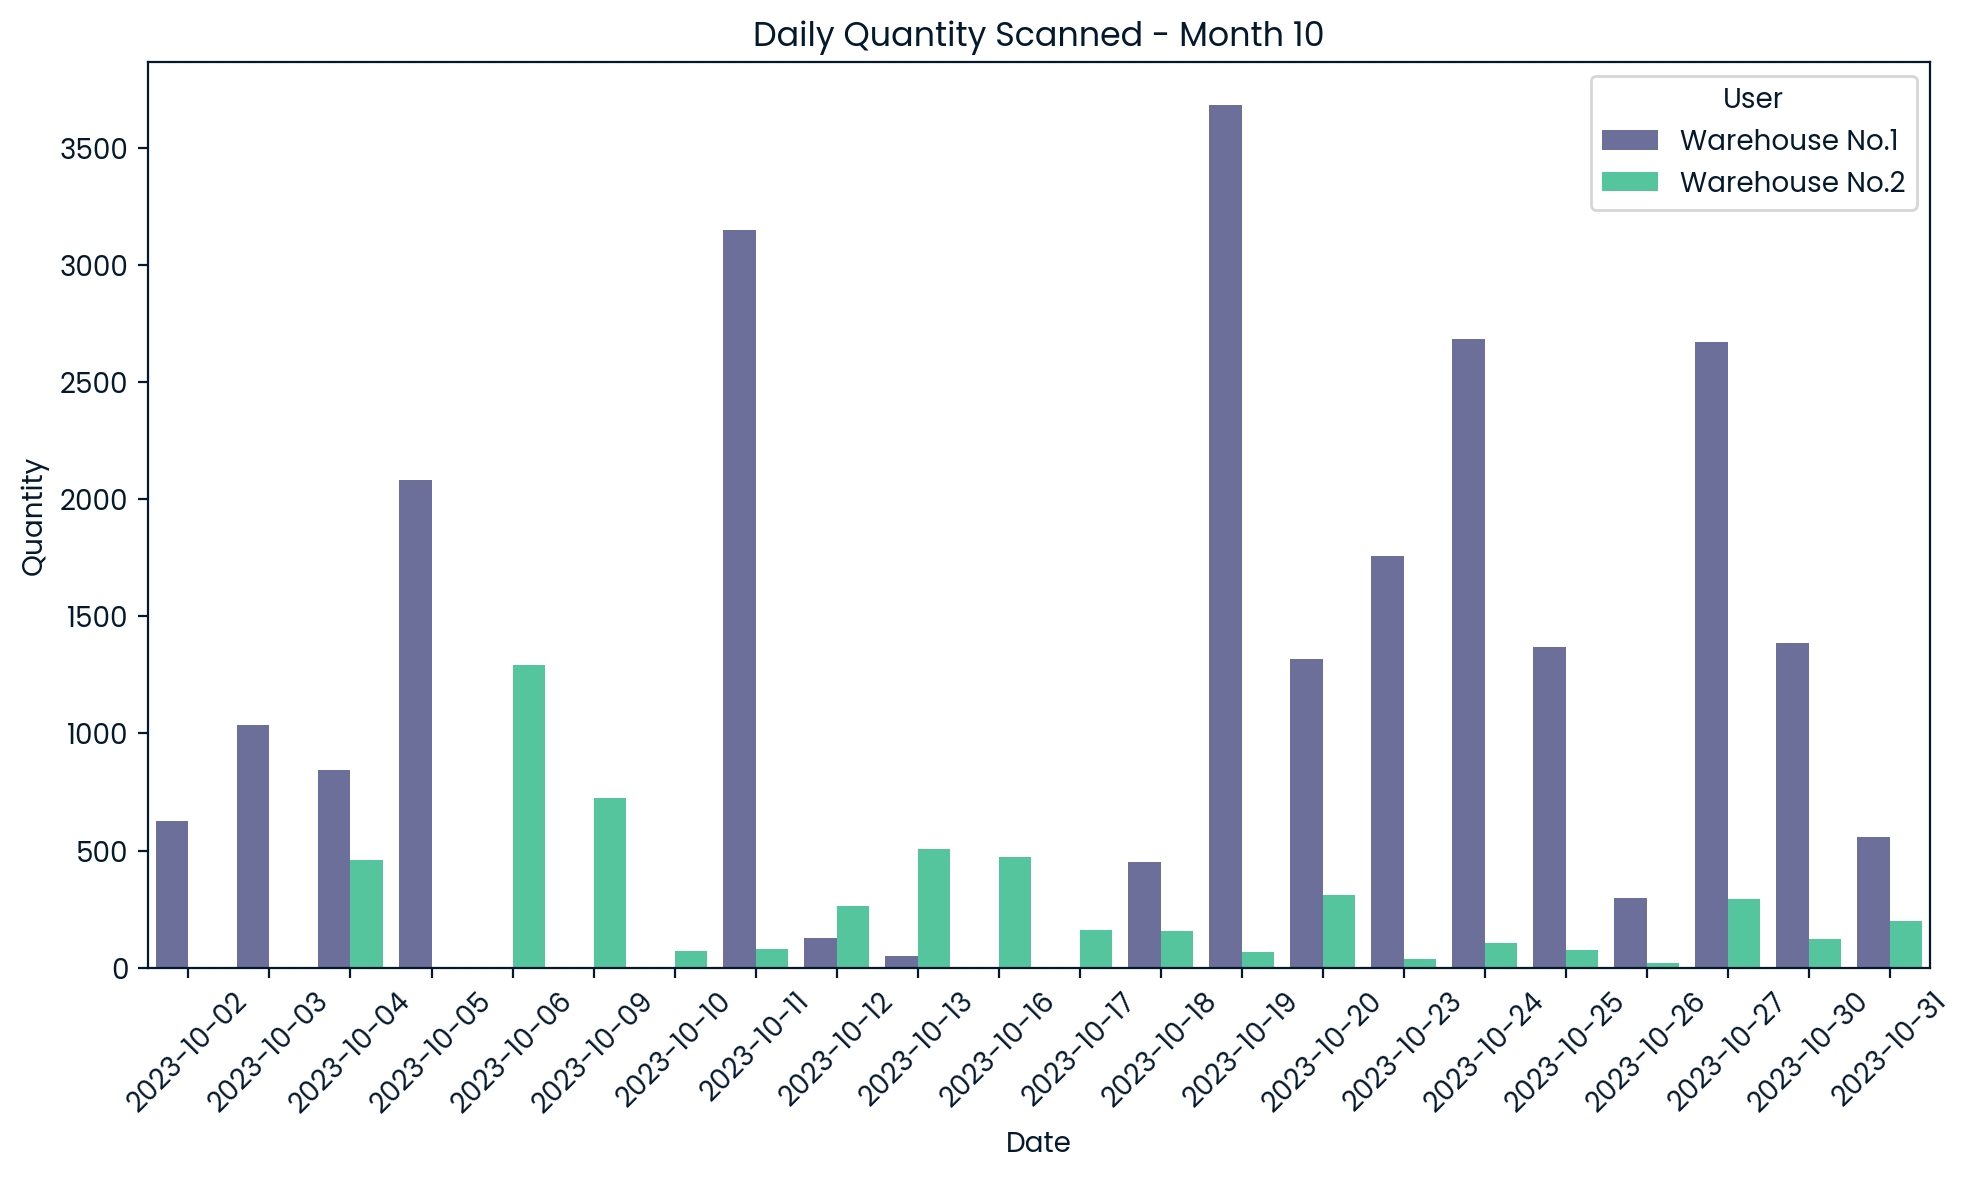

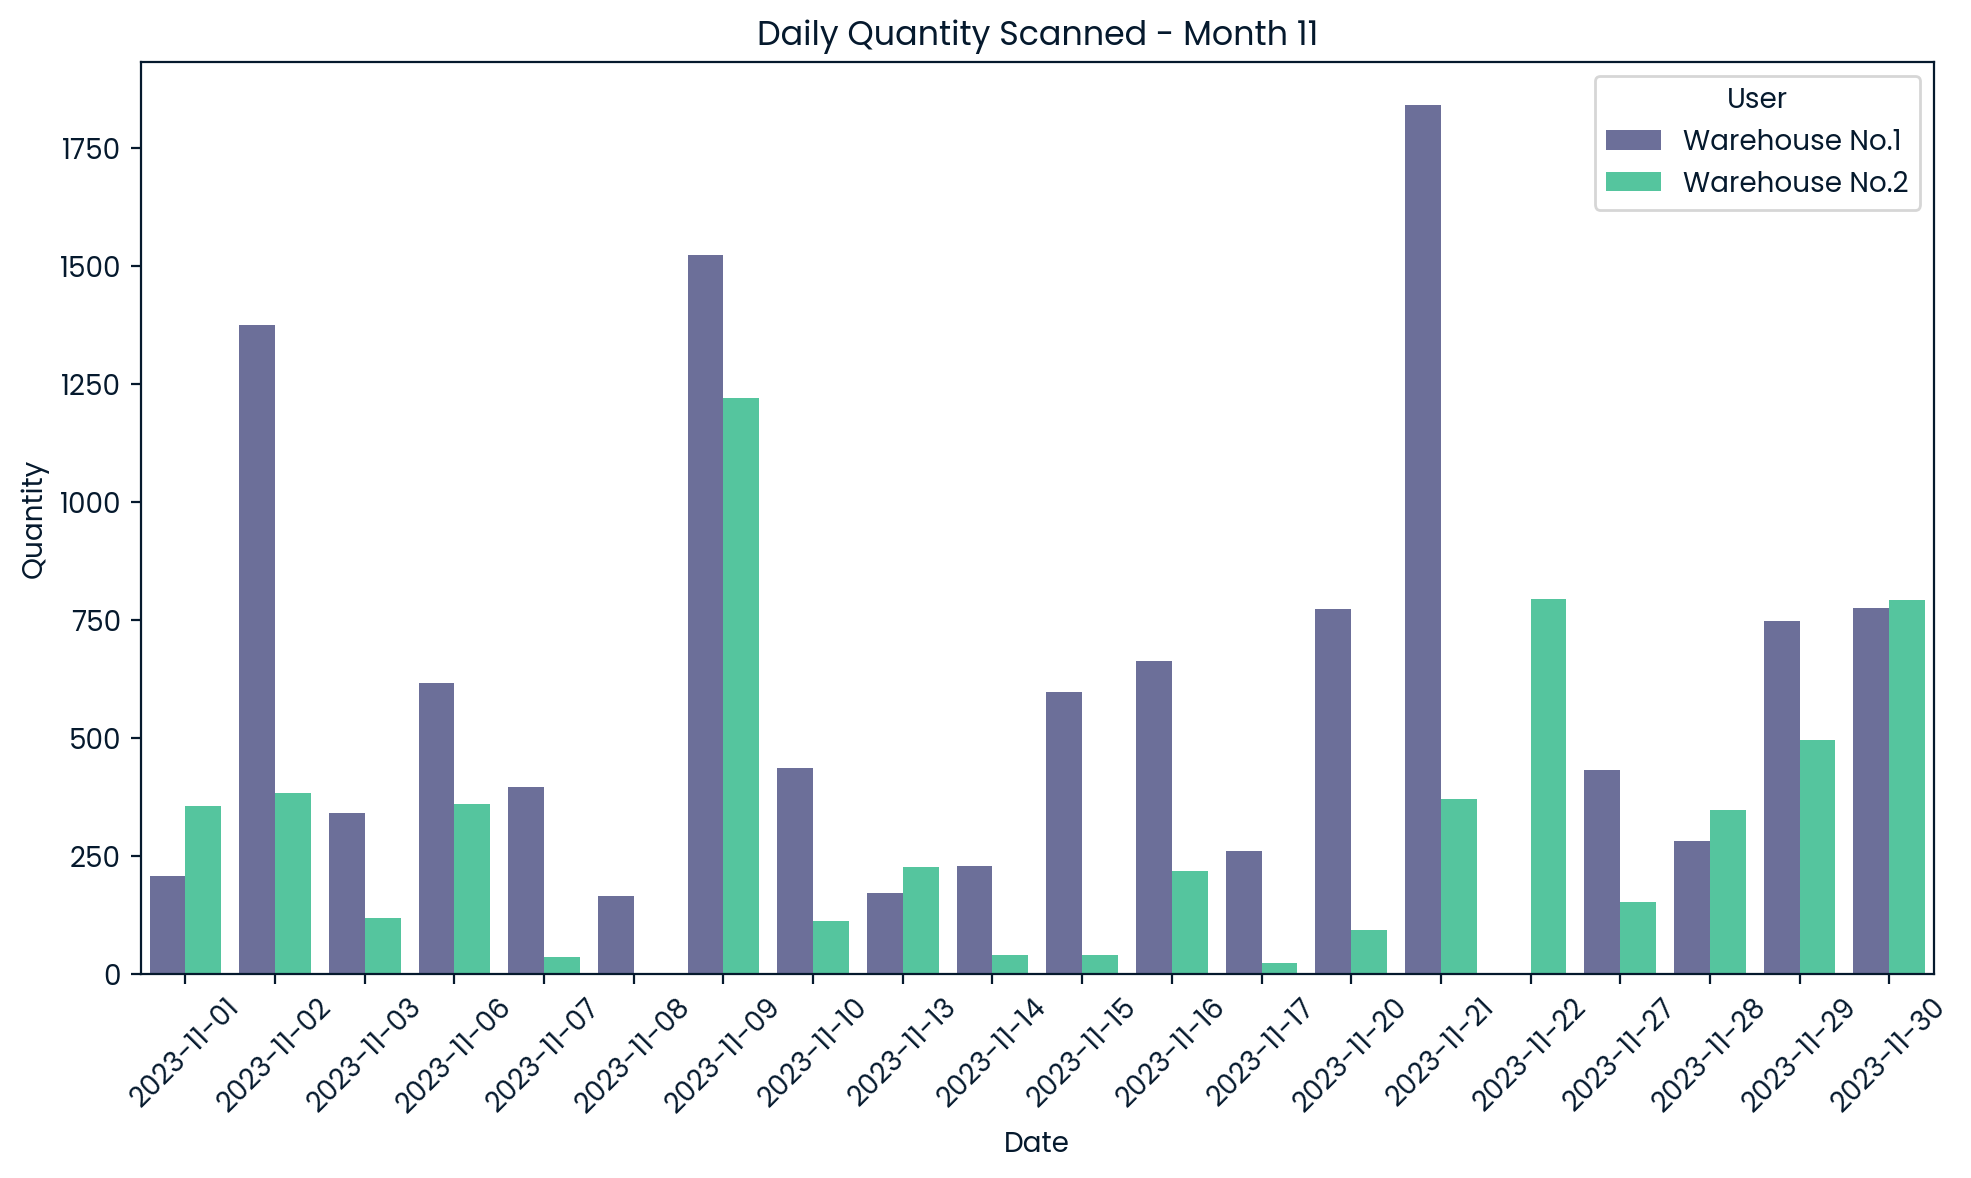

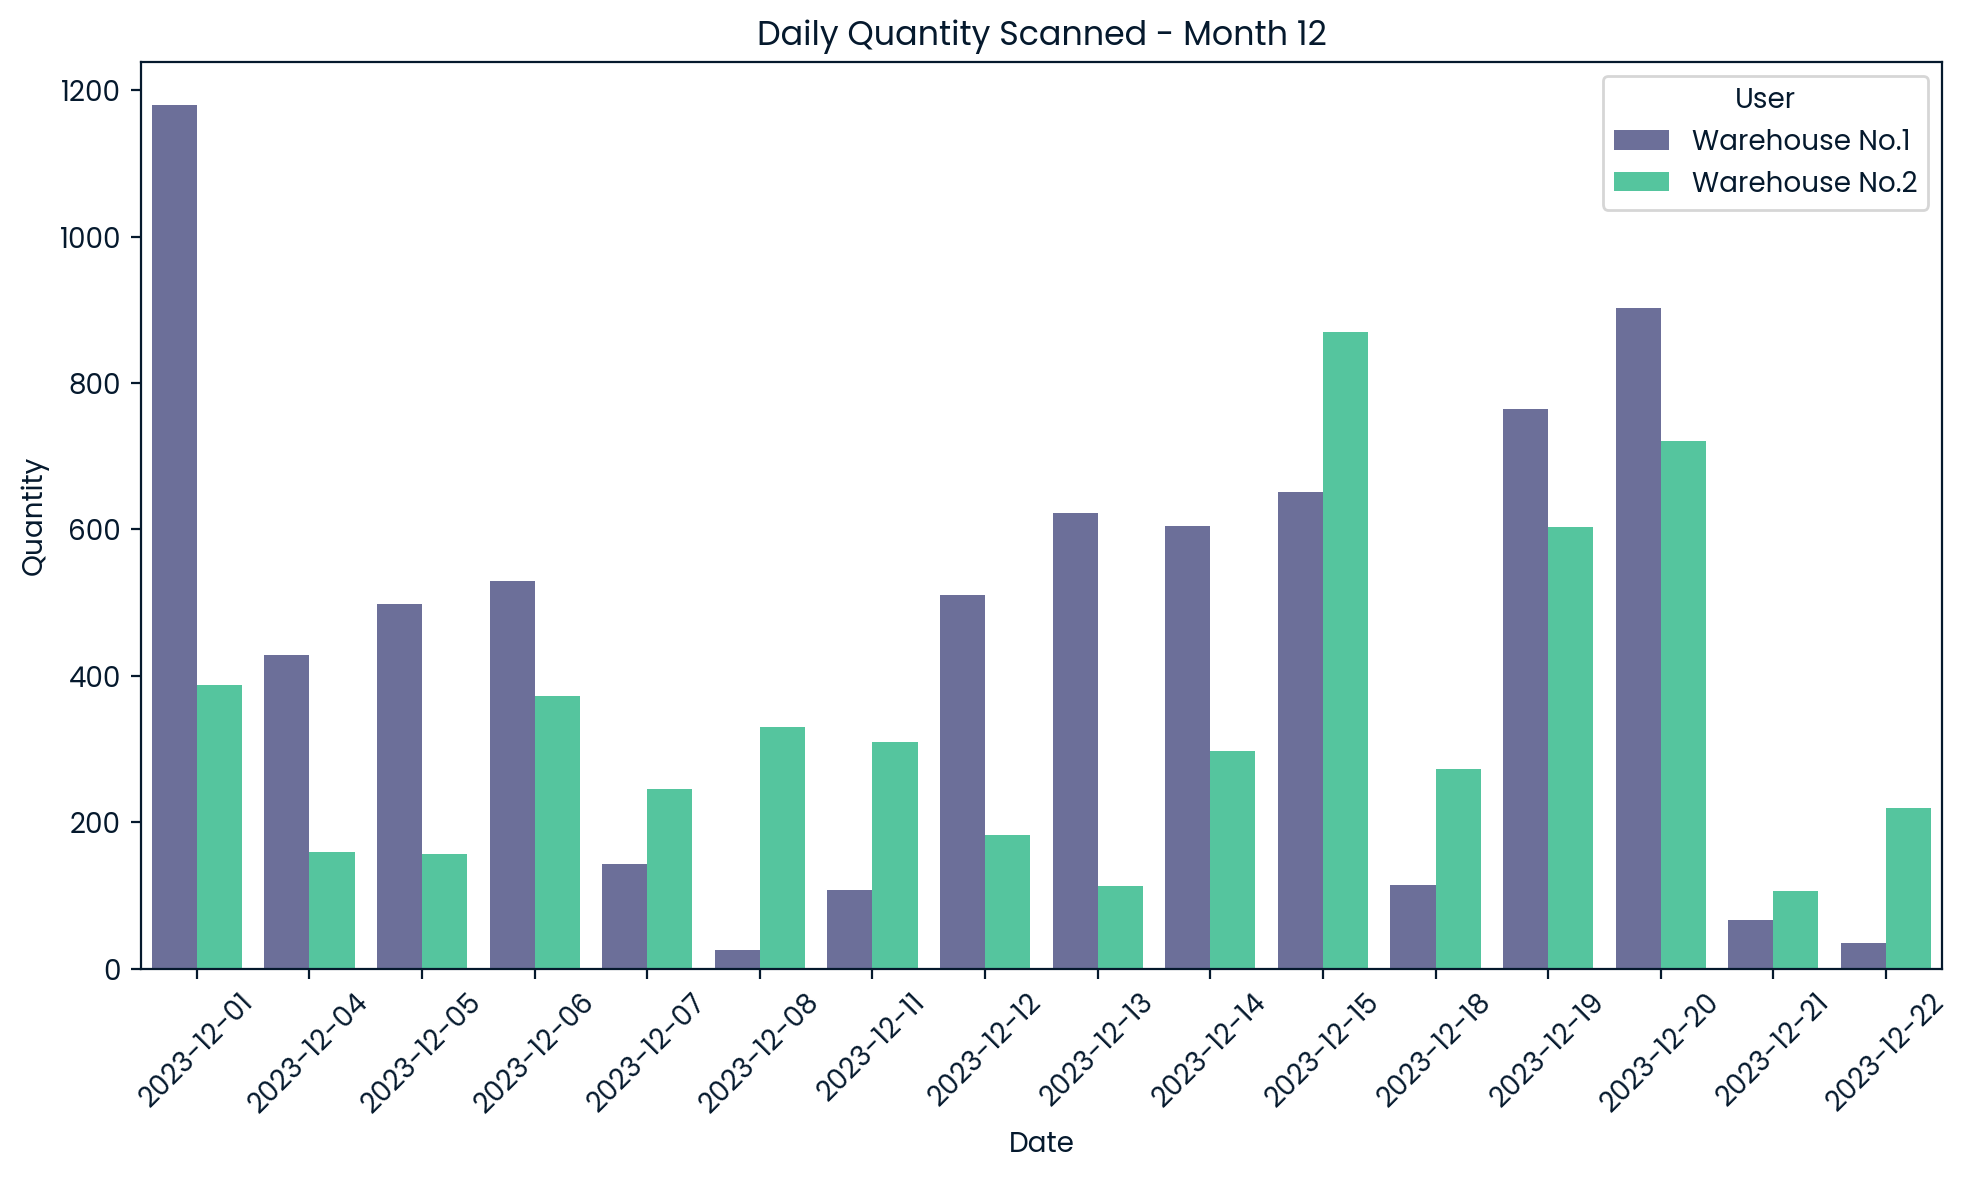

In [7]:
# Plotting Quantity for each month
plot_monthly_metric(merged_data, 'Quantity', unique_months, 'Daily Quantity Scanned')


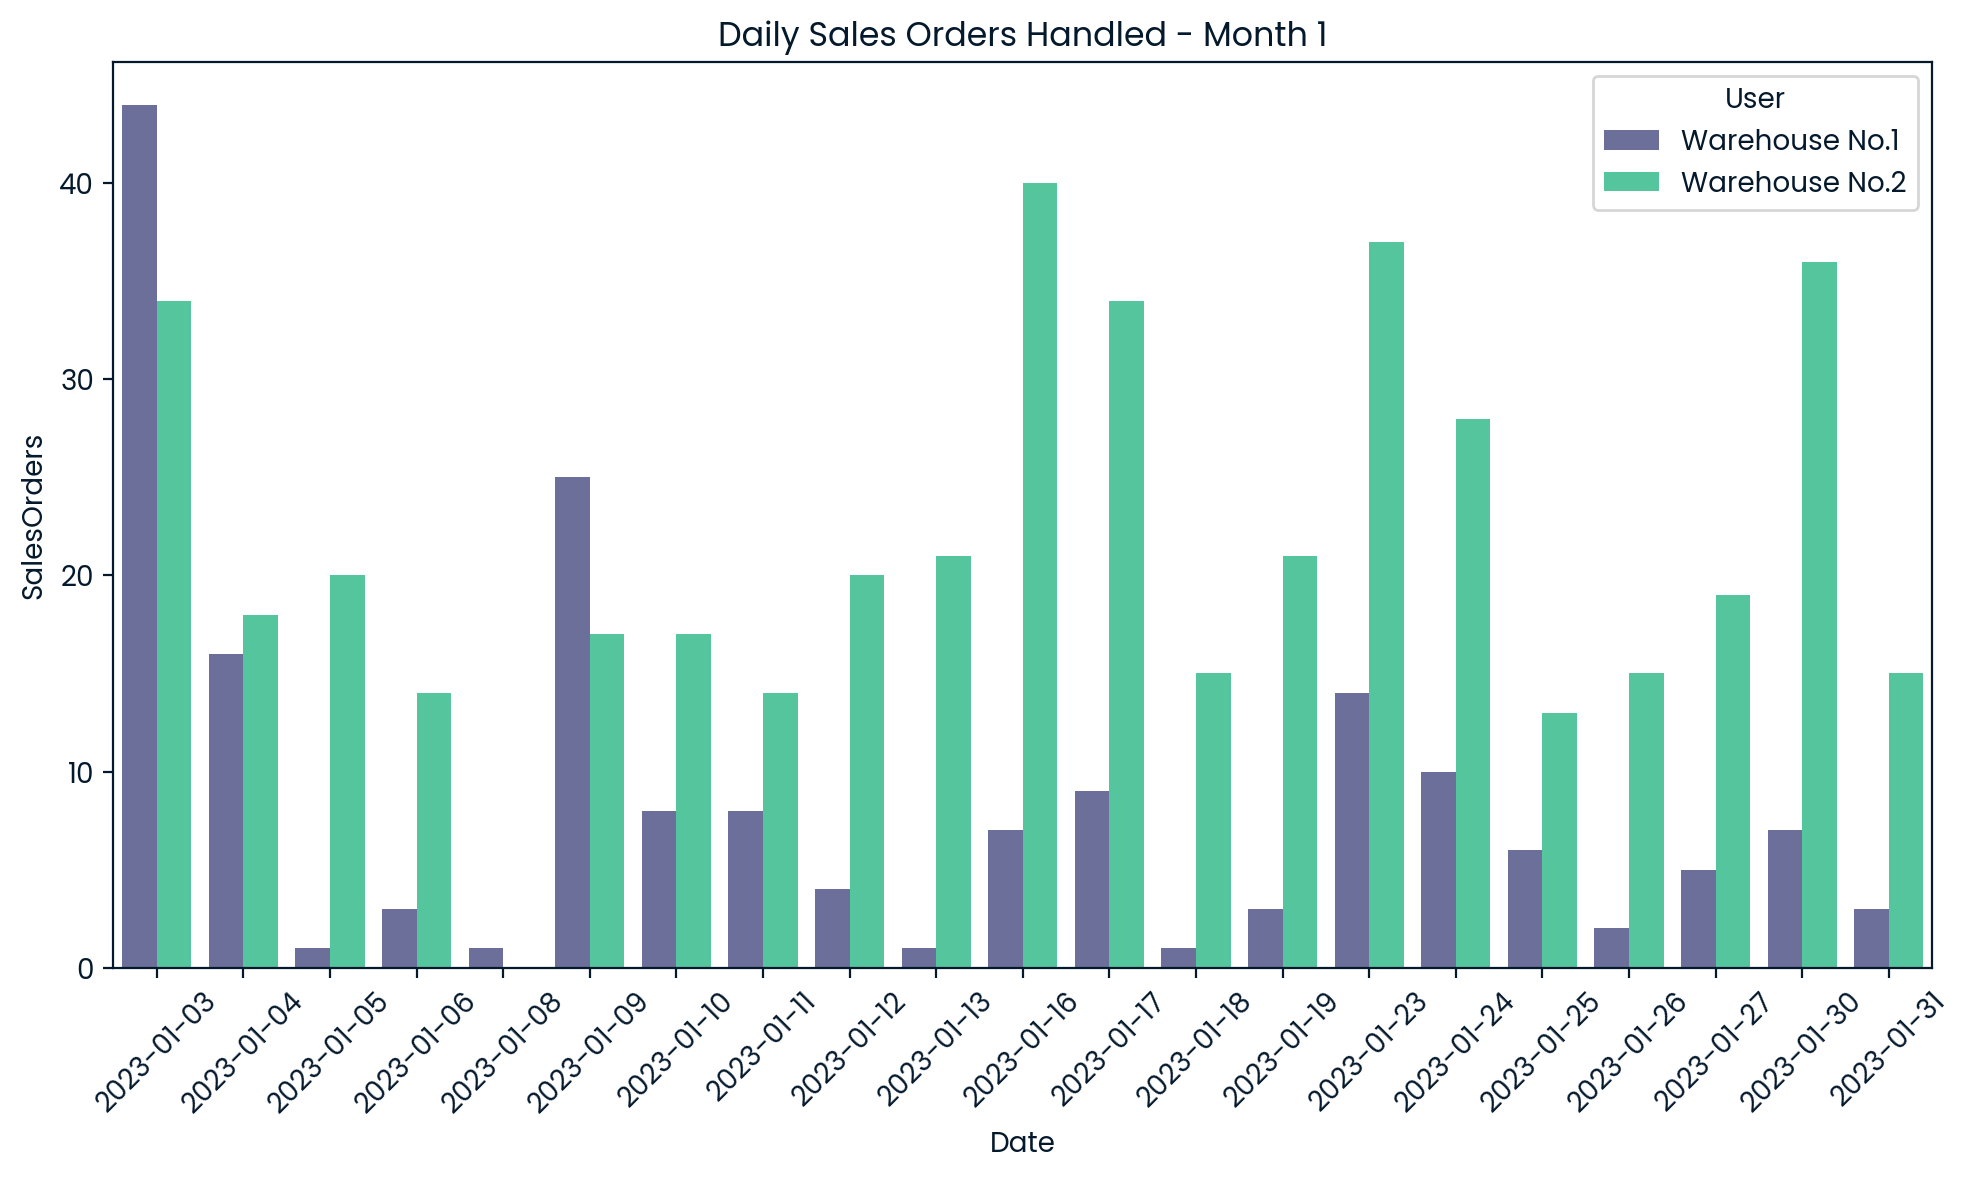

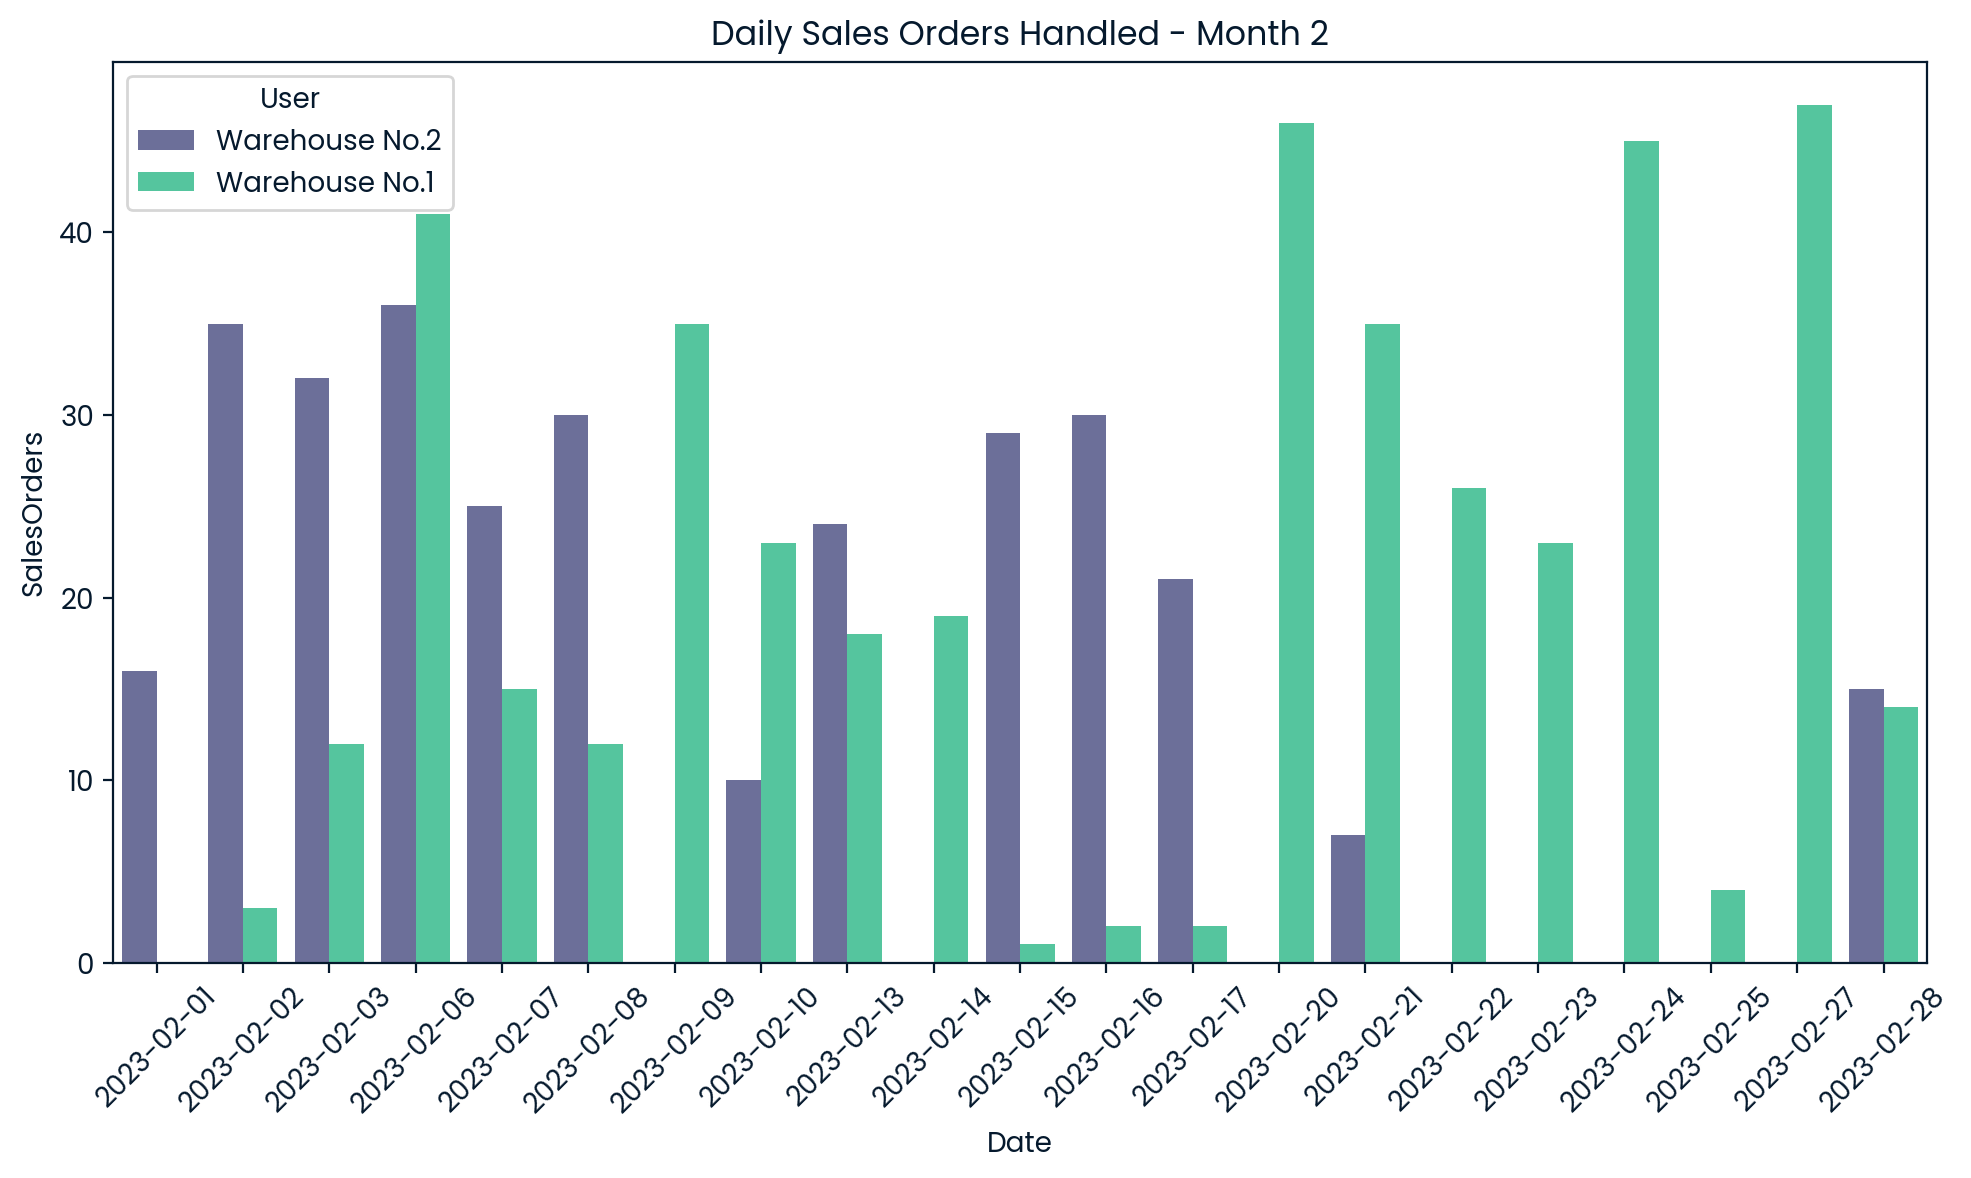

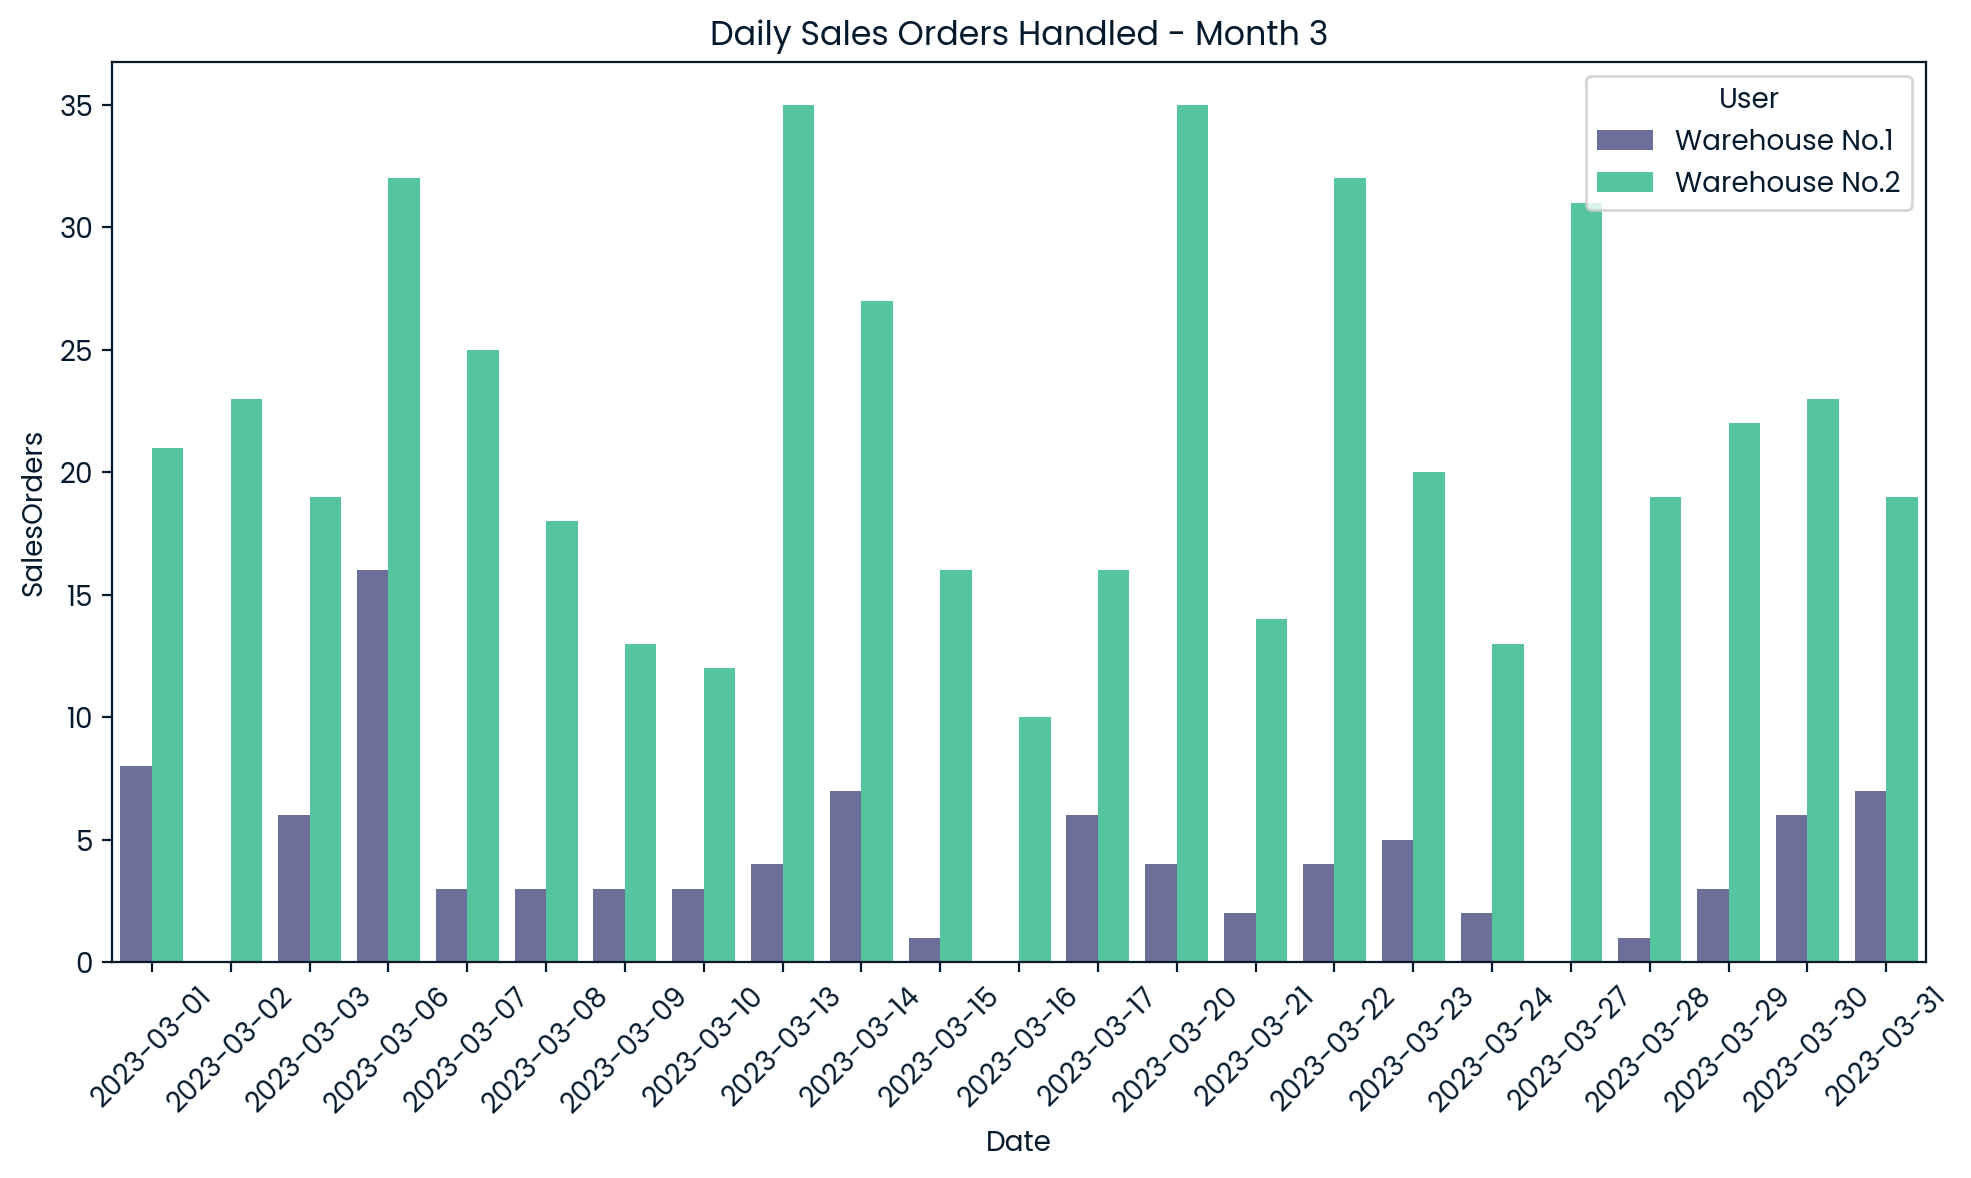

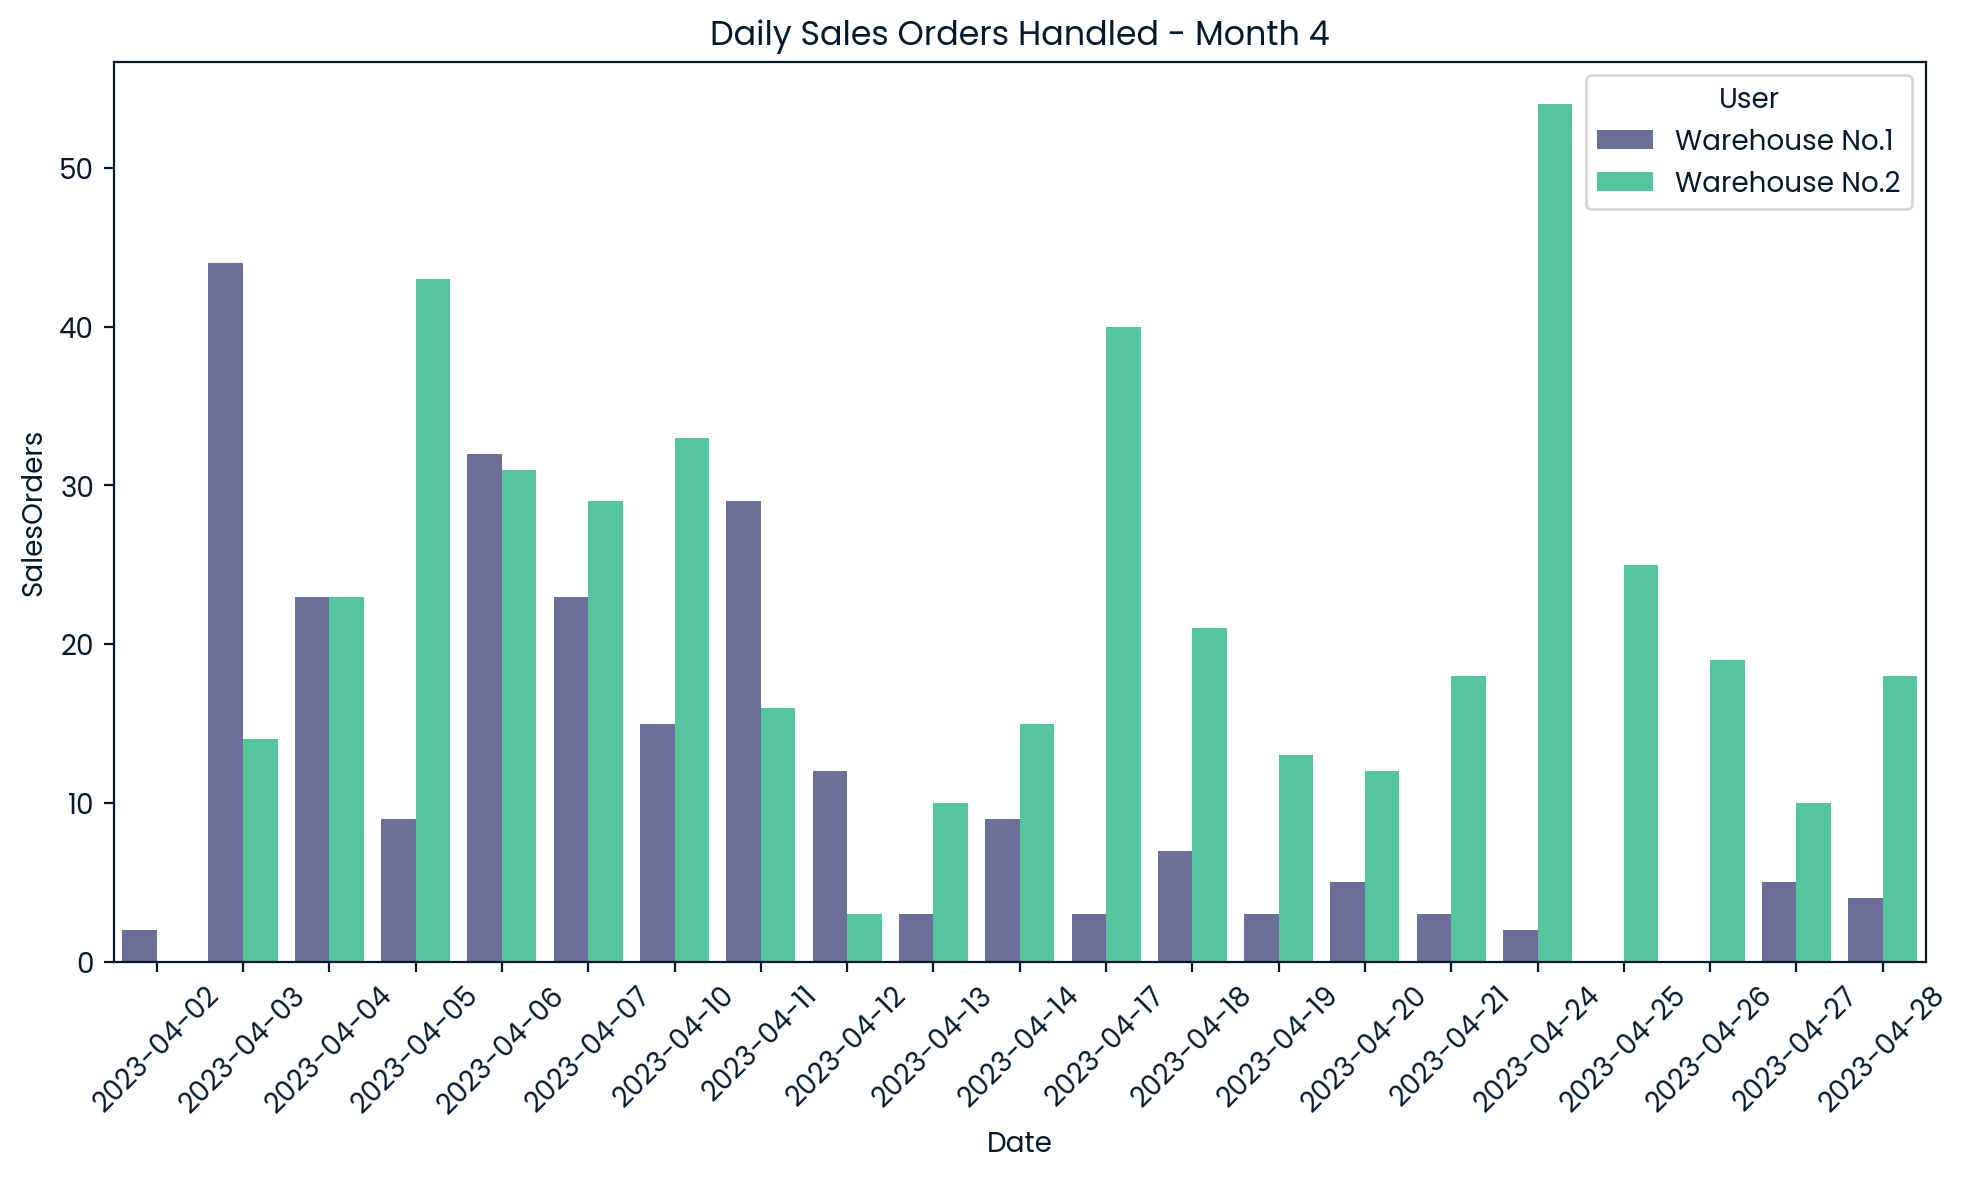

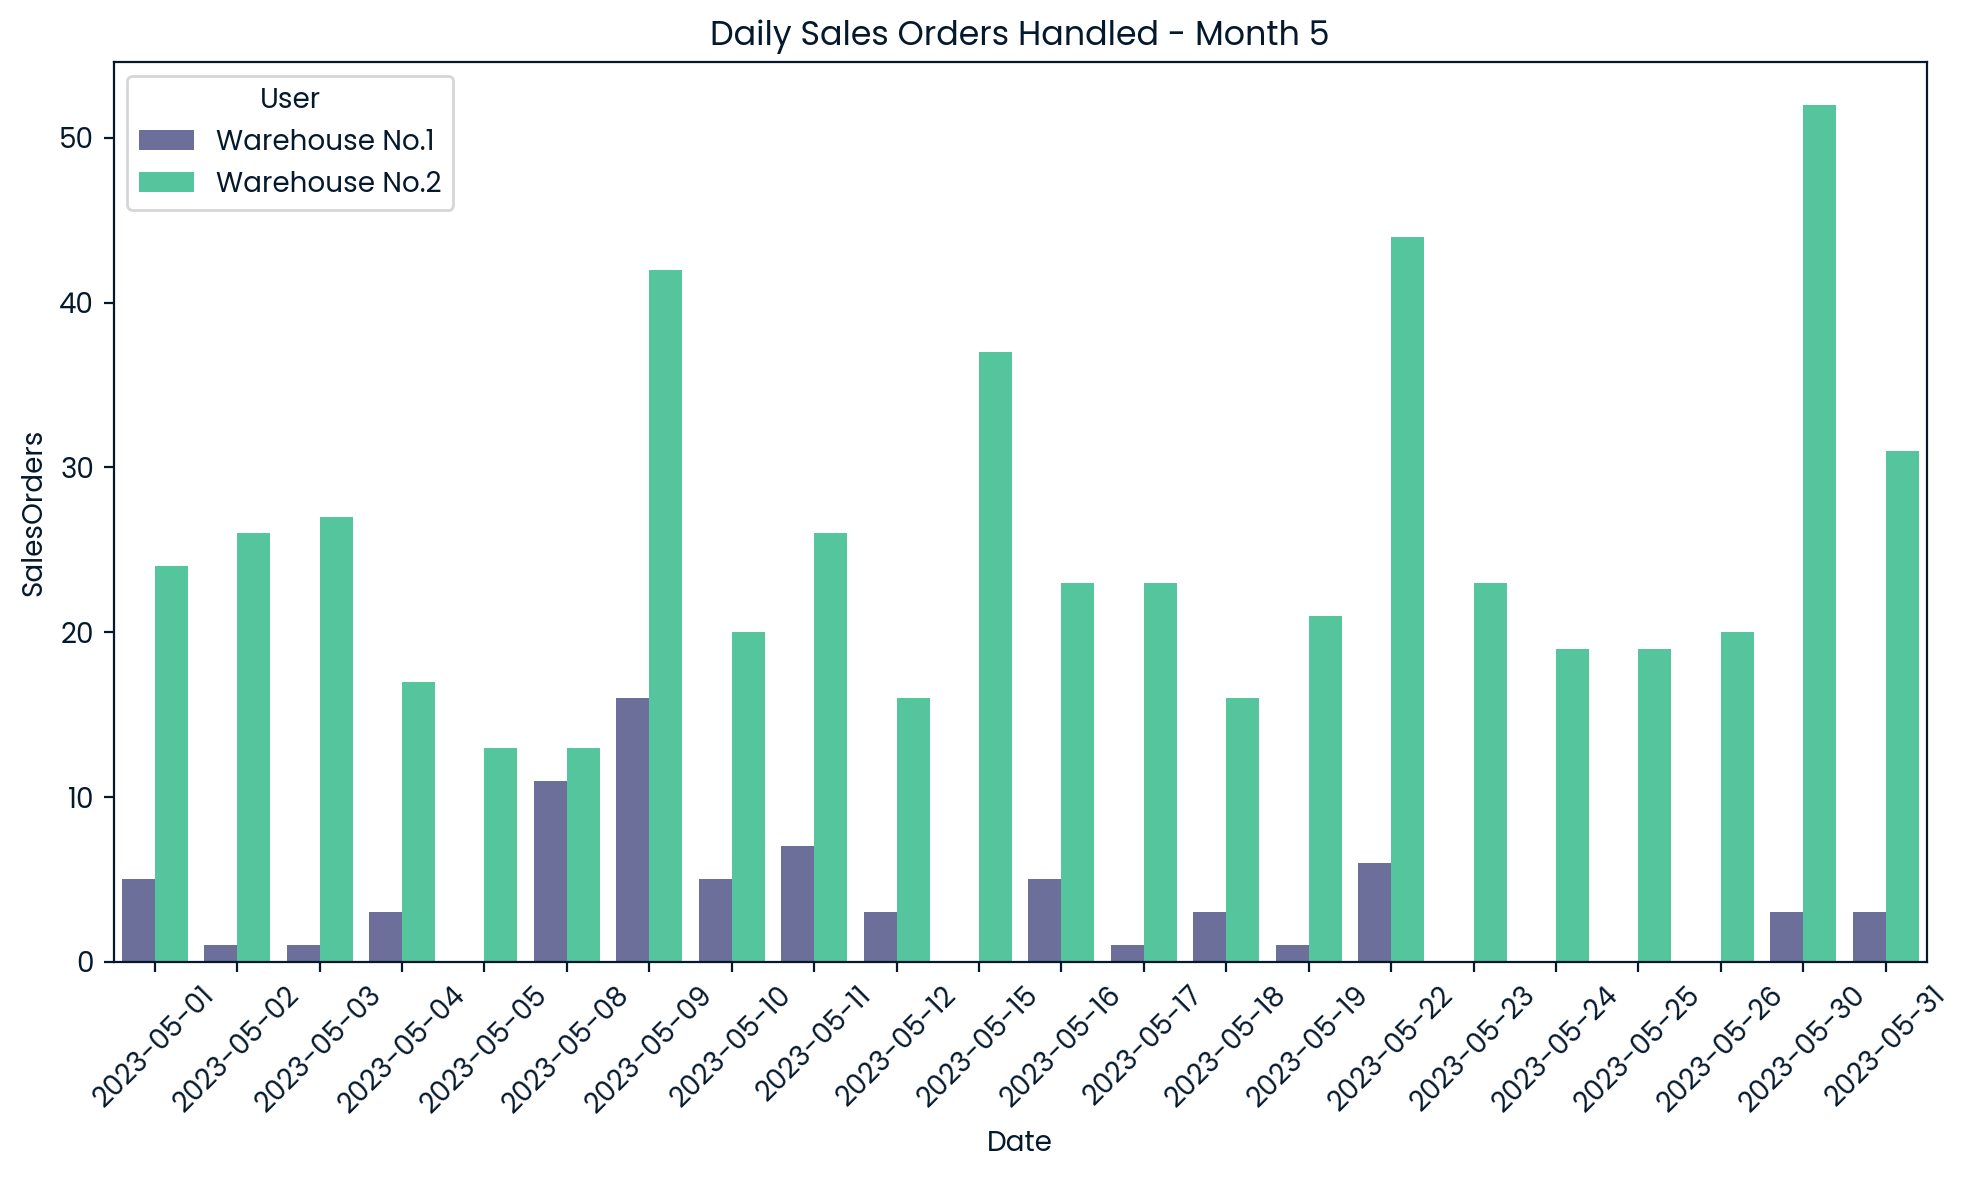

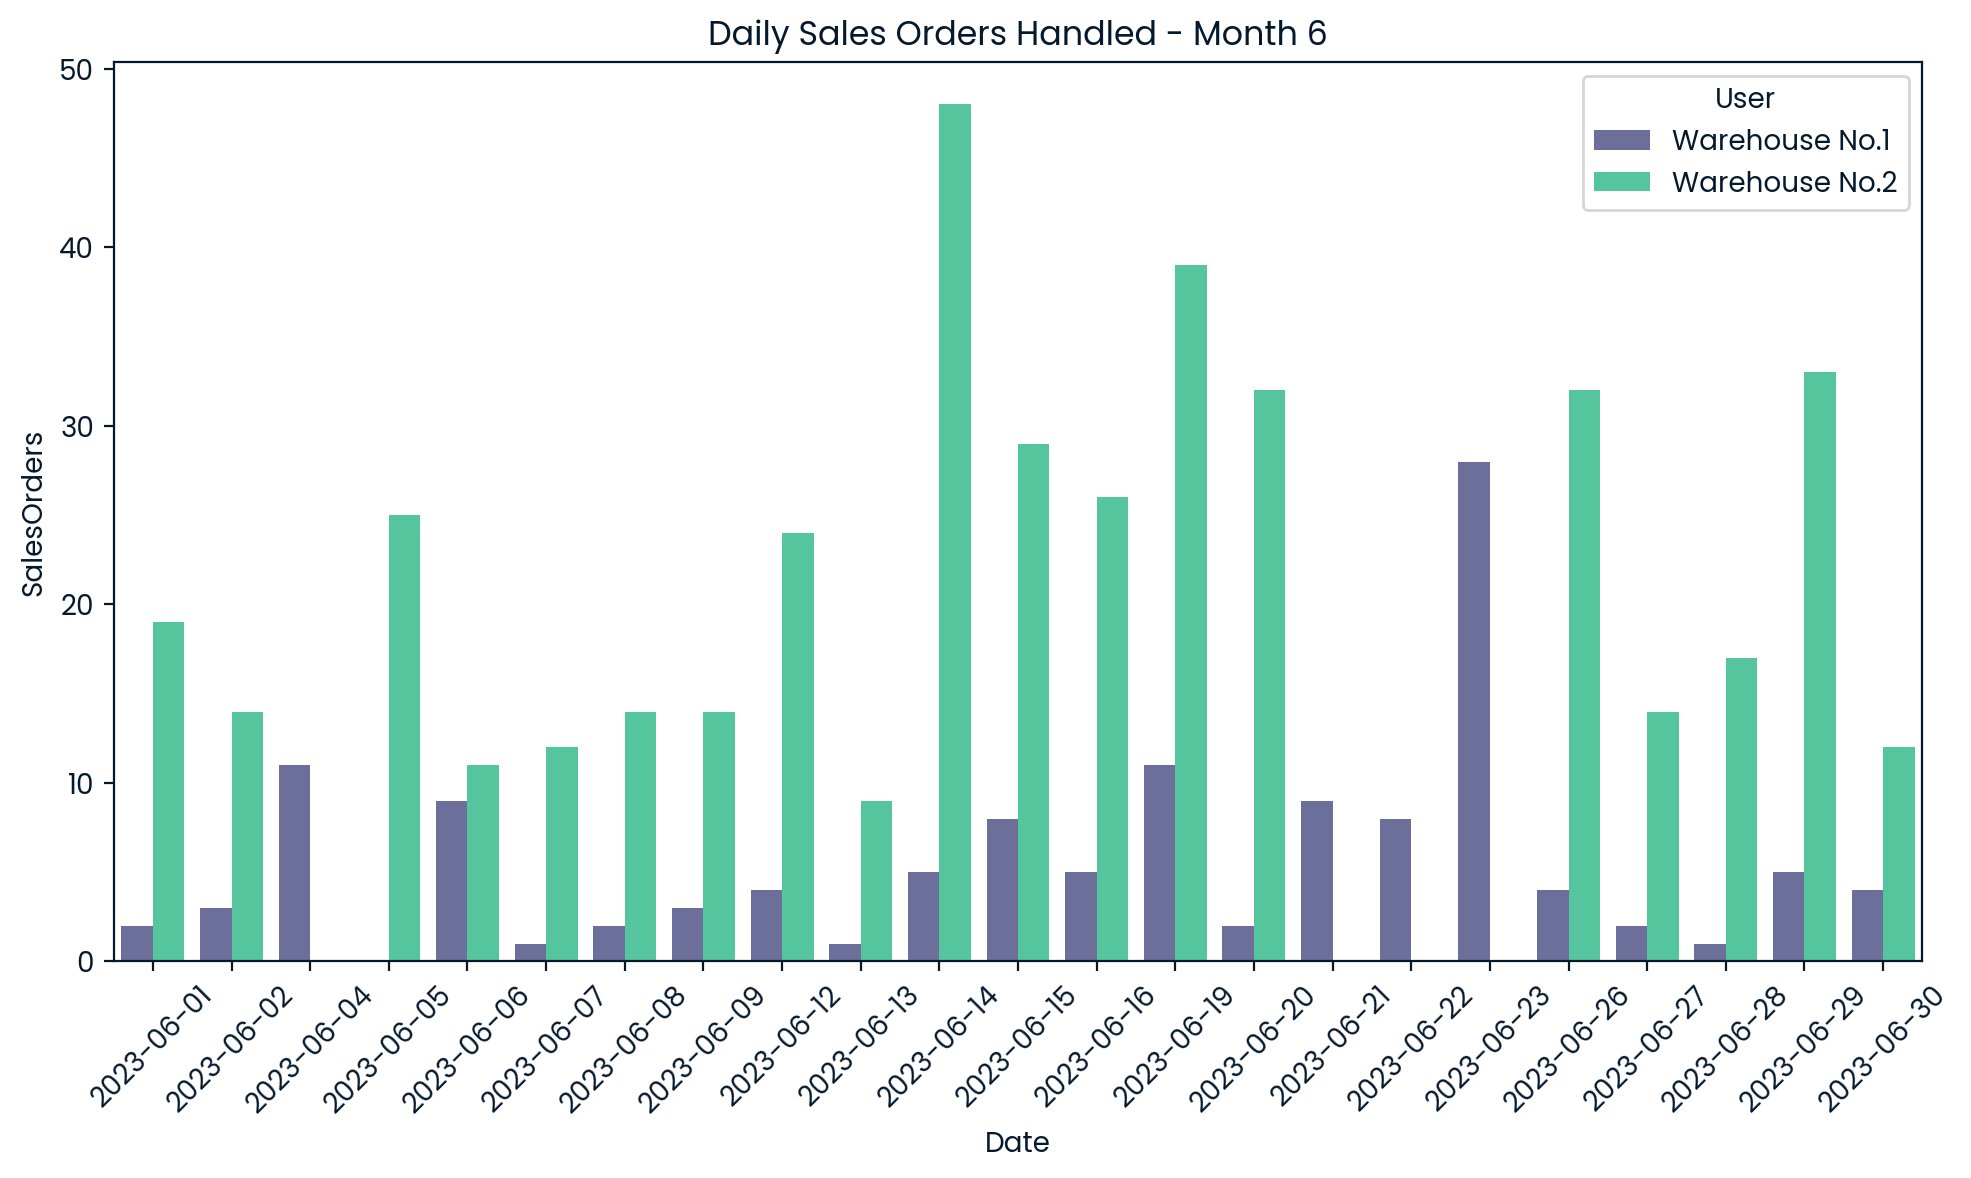

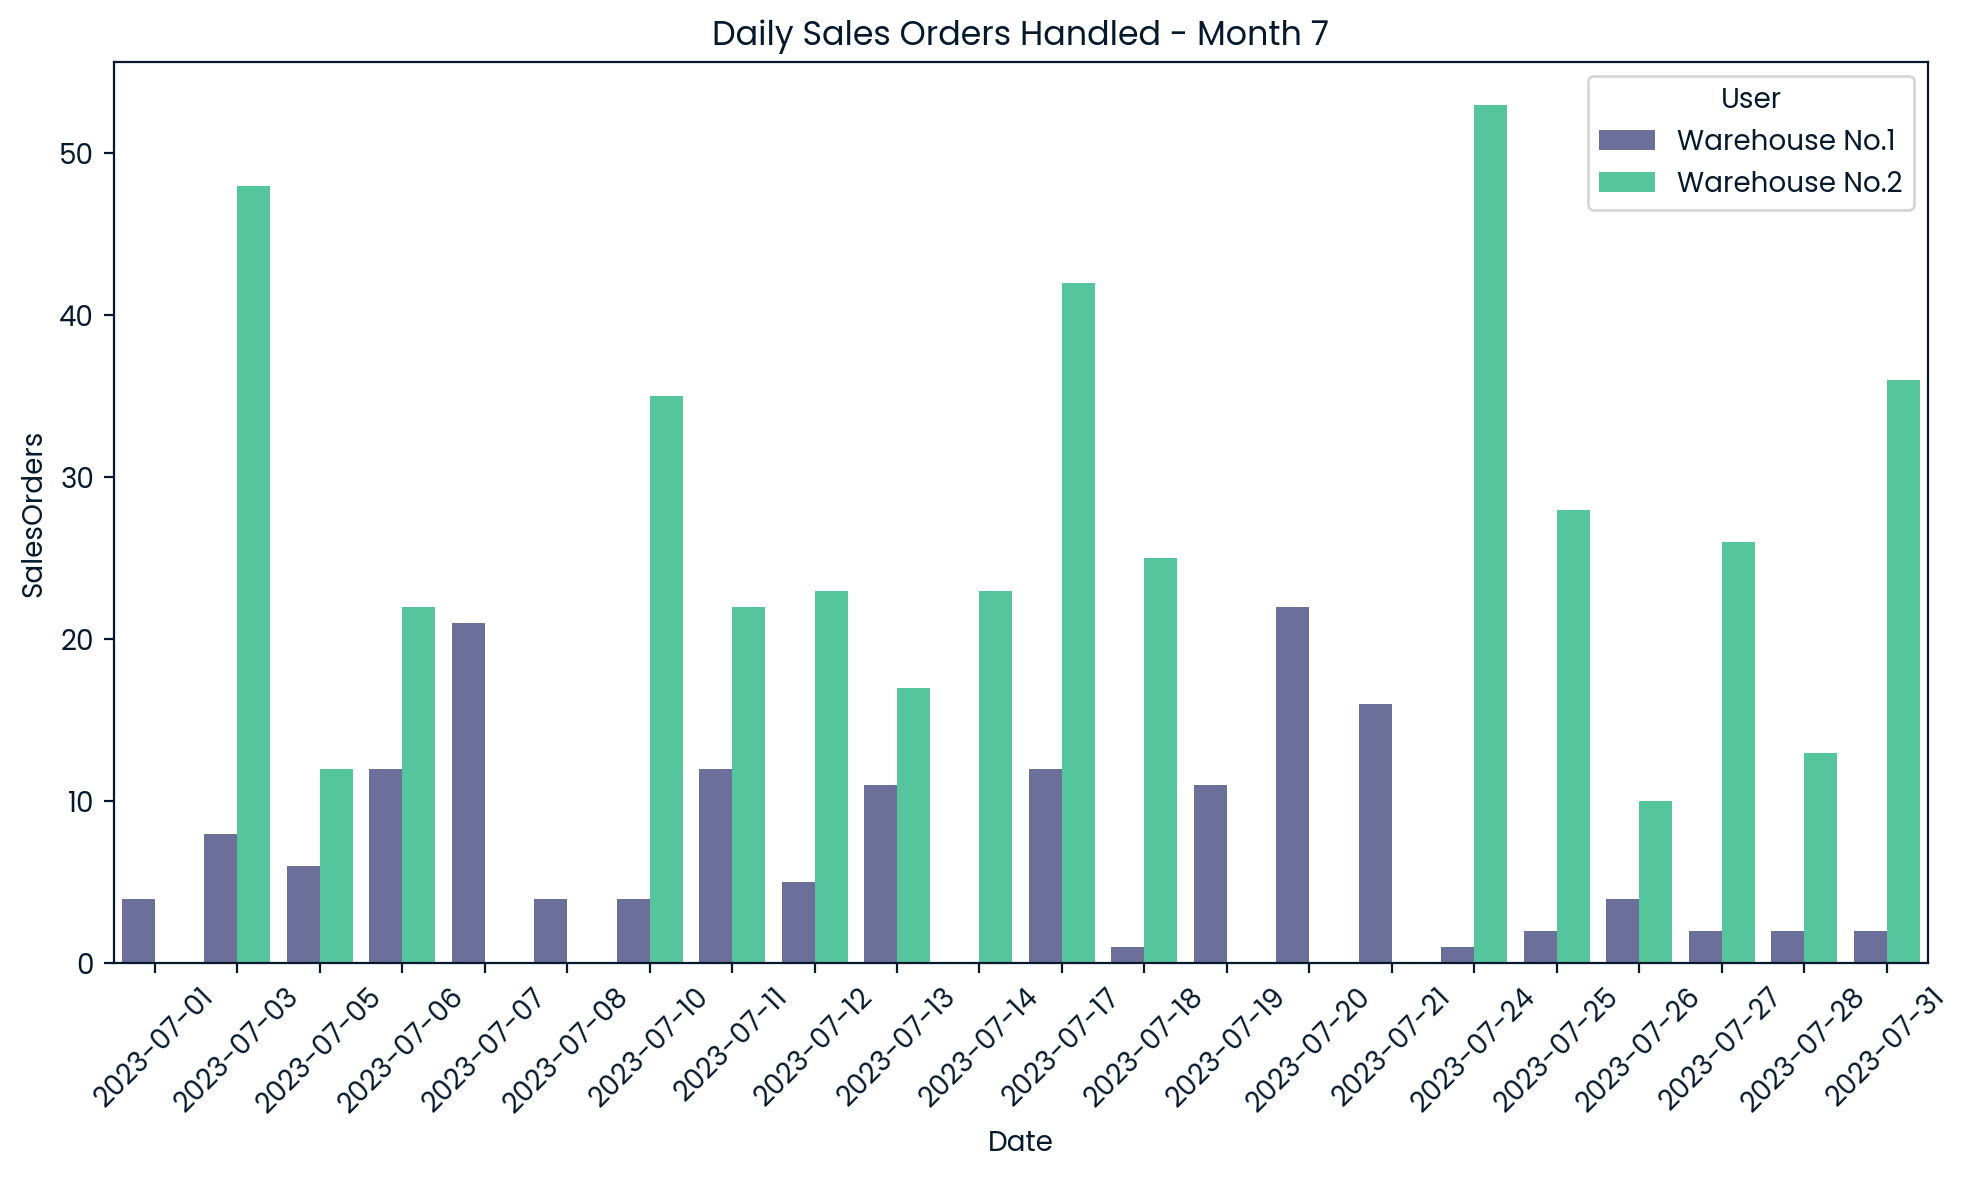

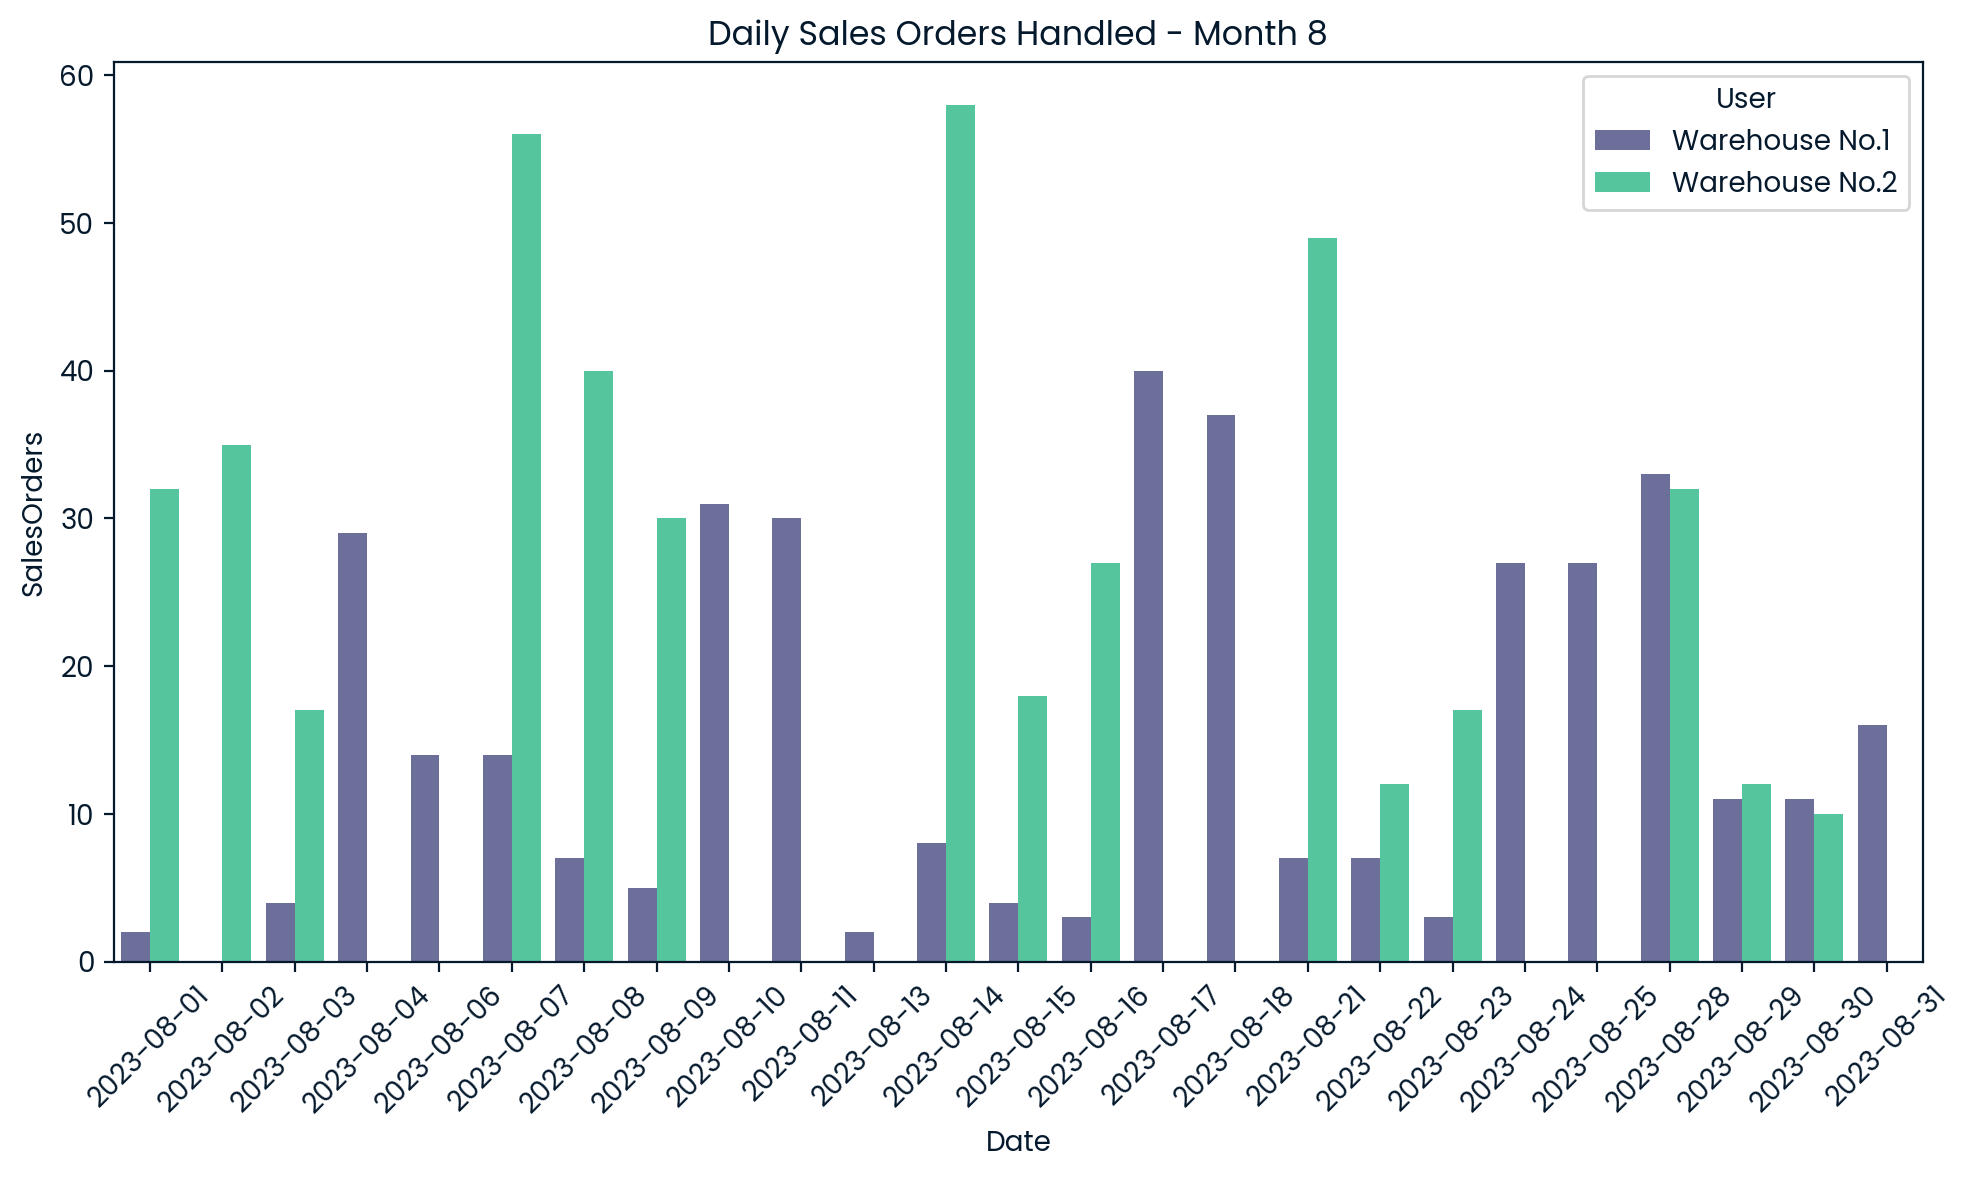

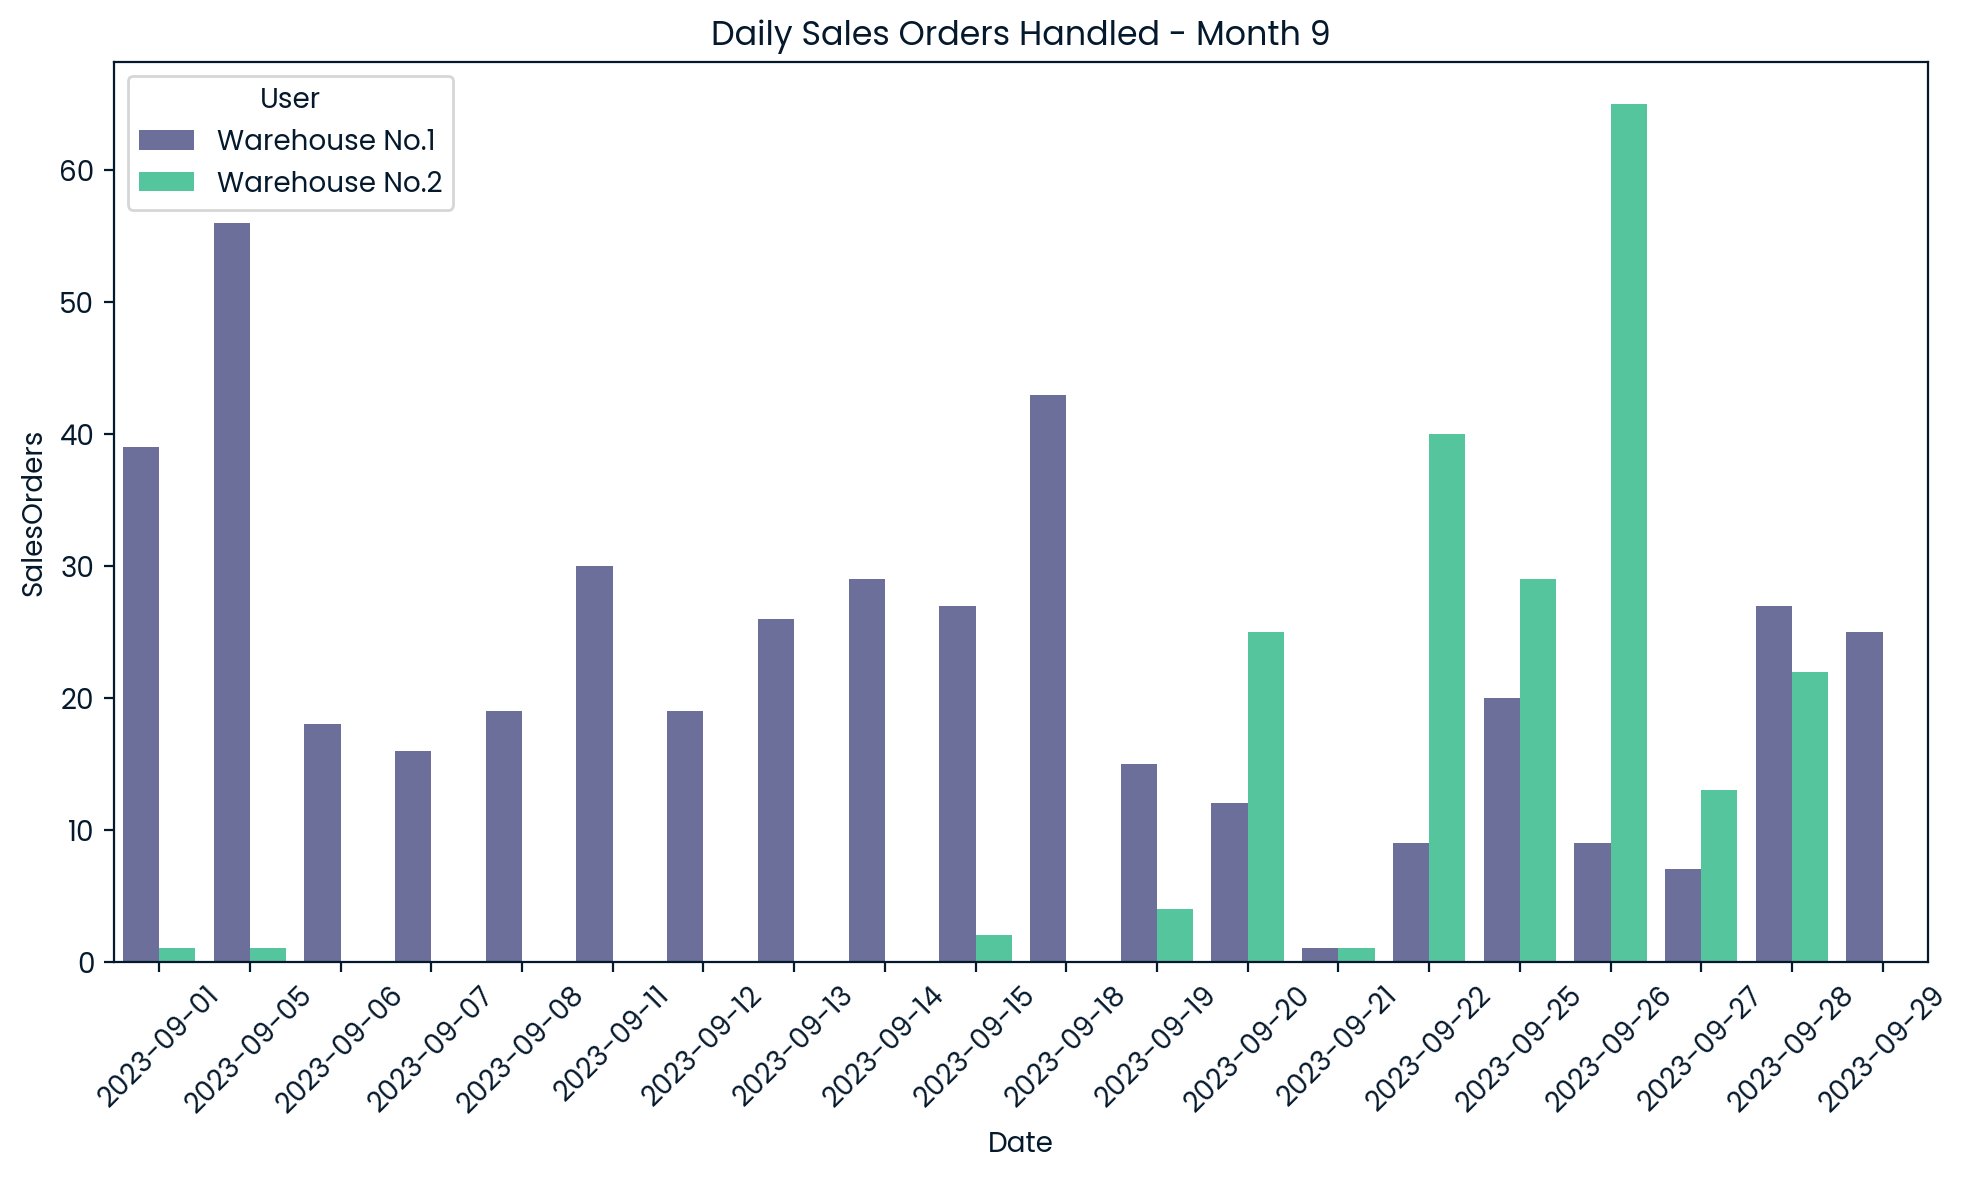

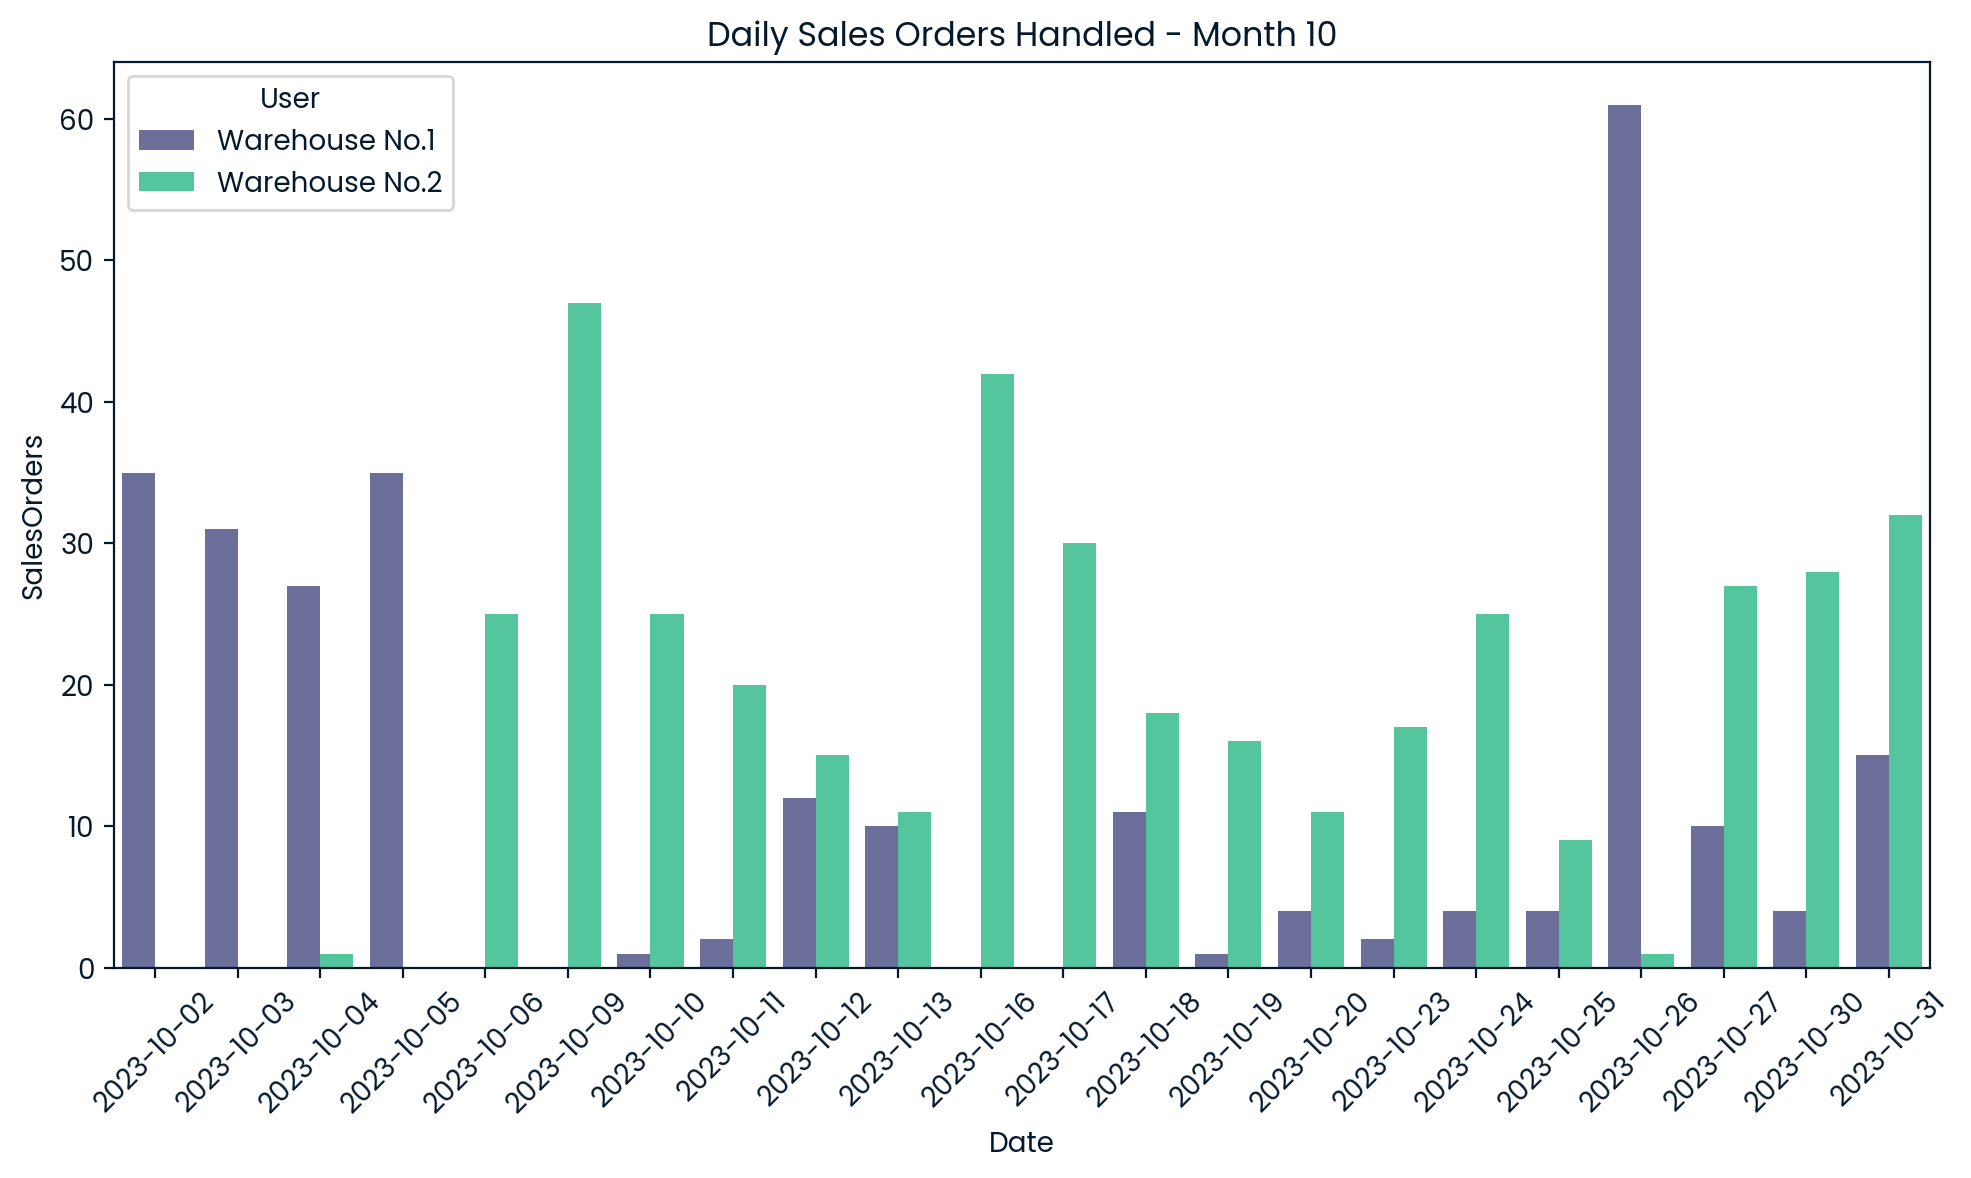

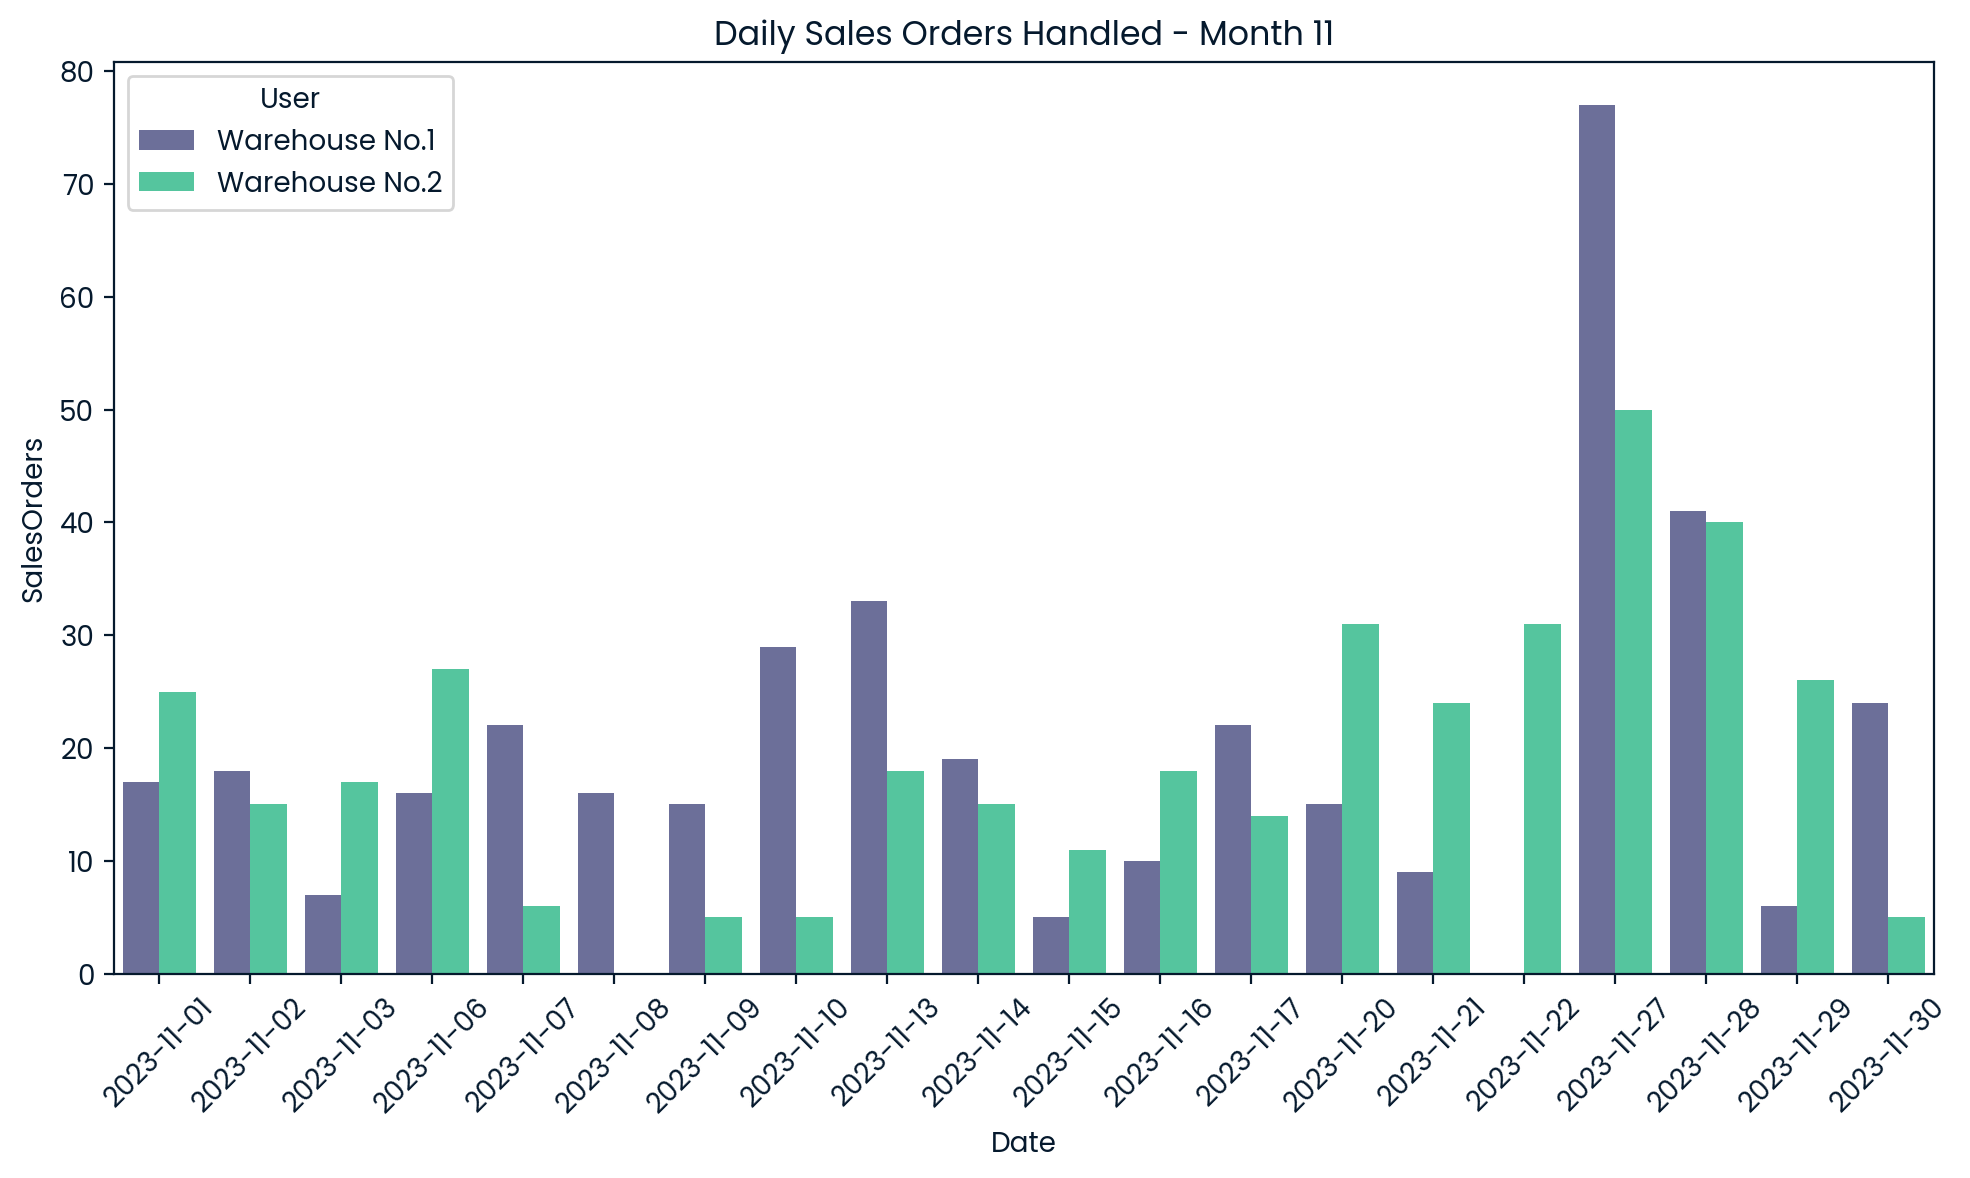

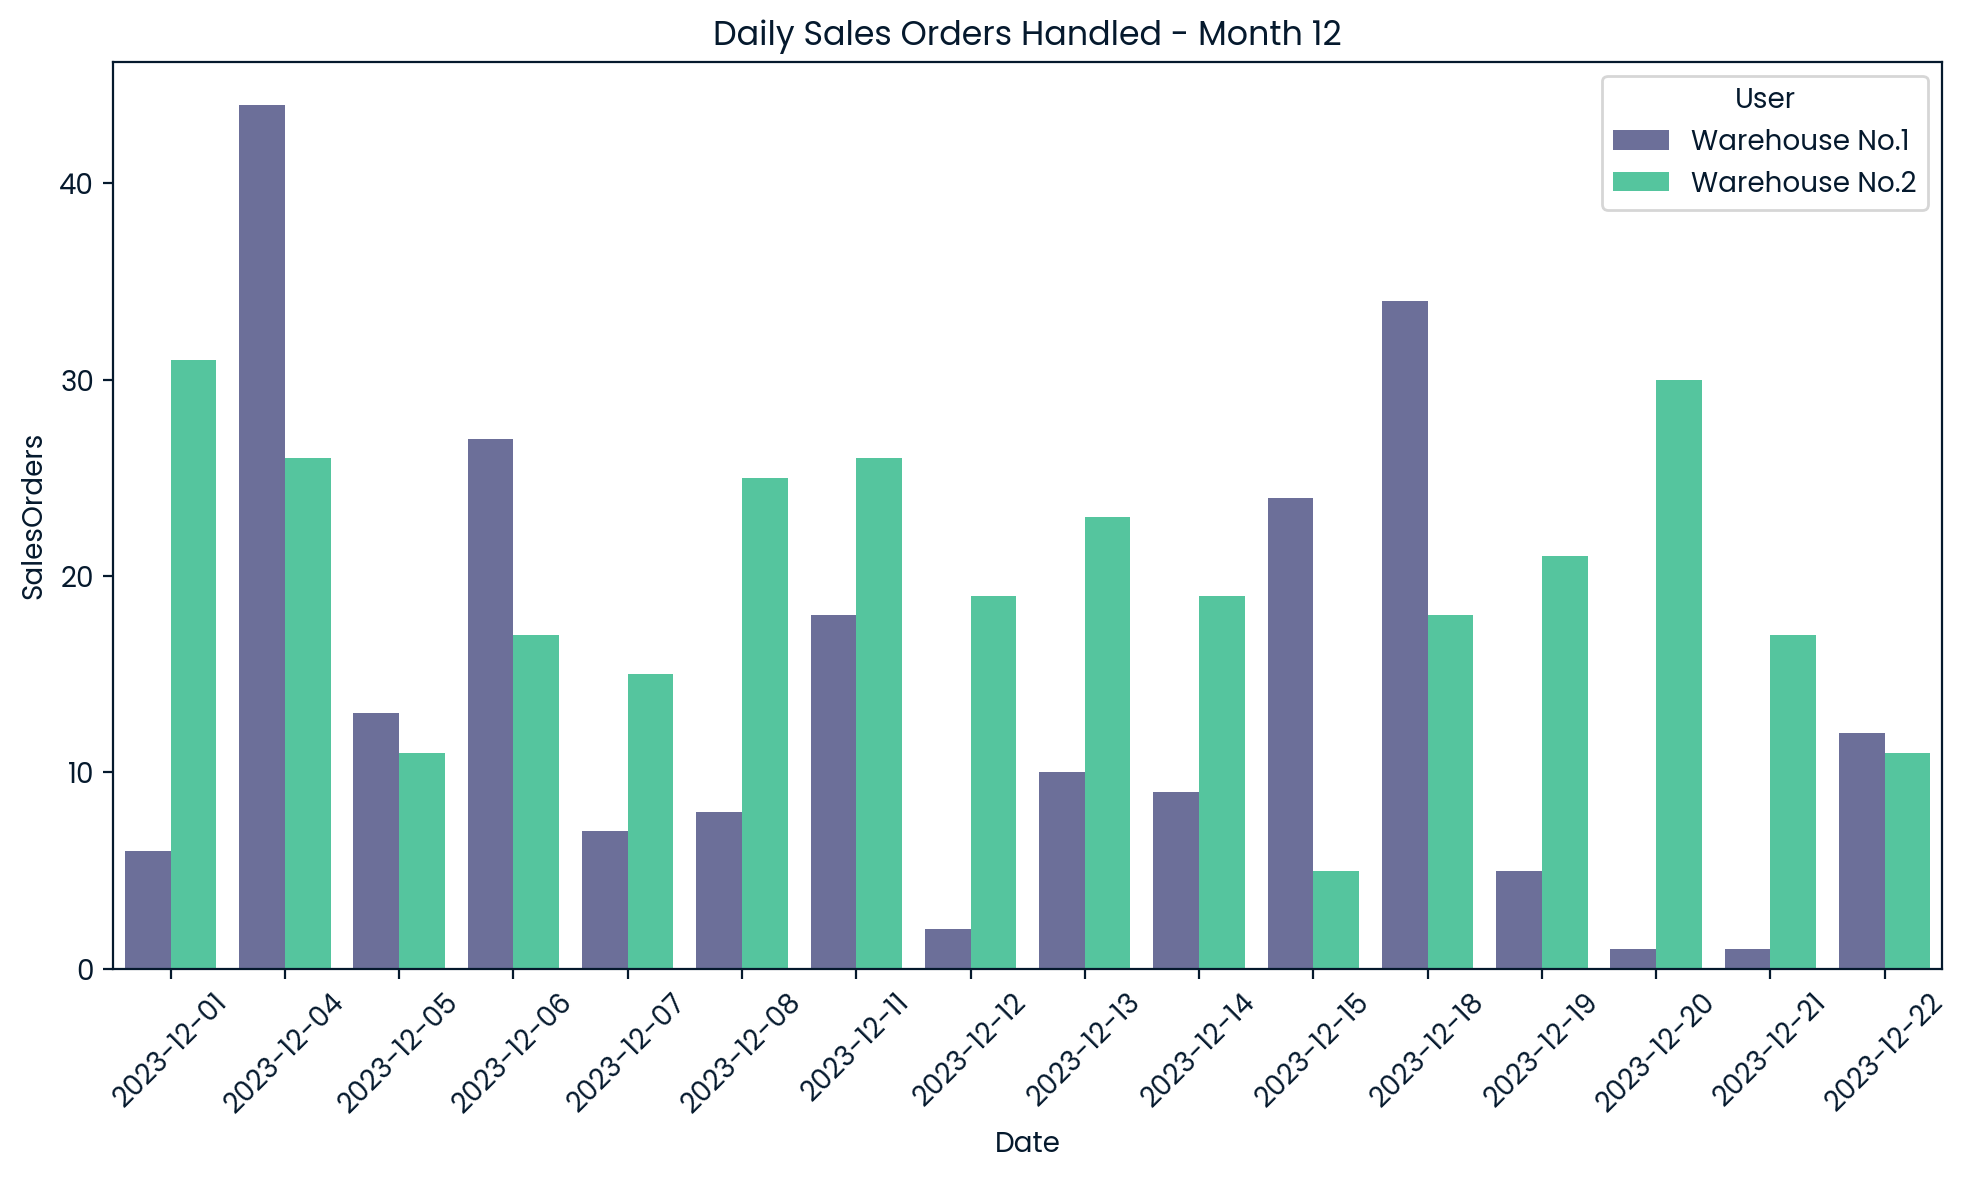

In [8]:
# Plotting Sales Orders for each month
plot_monthly_metric(merged_data, 'SalesOrders', unique_months, 'Daily Sales Orders Handled')


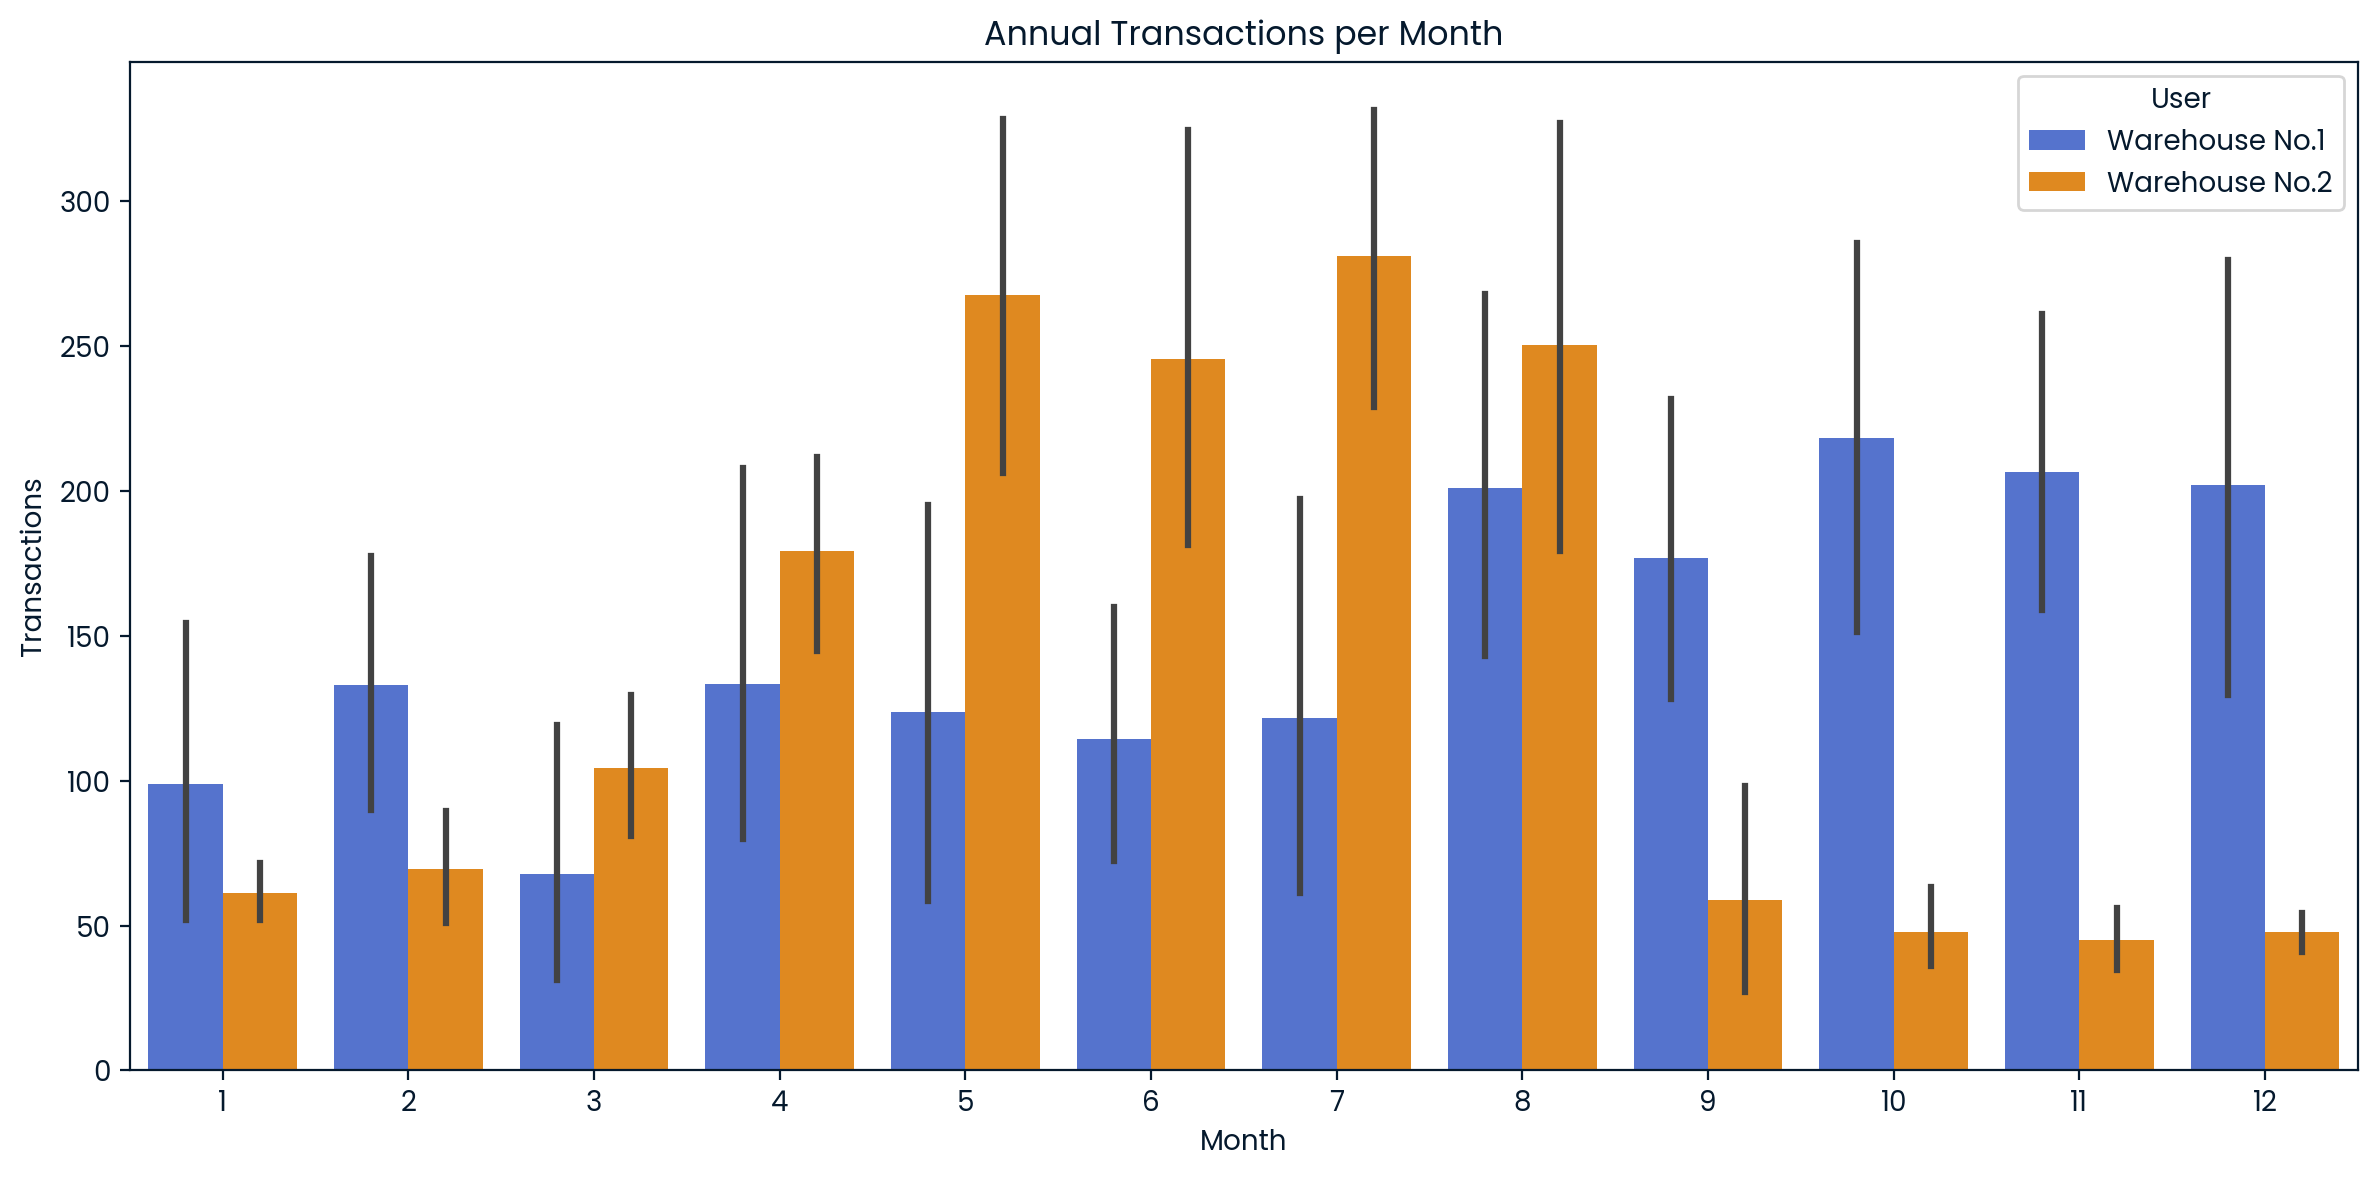

In [9]:
# Function to create annual plots with monthly breakdown for a given metric
def plot_annual_metric(data, metric, title, colors):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Month', y=metric, hue='User', data=data, palette=colors)
    plt.title(f'Annual {title}')
    plt.xlabel('Month')
    plt.ylabel(metric)
    plt.legend(title='User')
    plt.tight_layout()
    plt.show()

# Defining distinct colors for each employee
colors = {"Warehouse No.1": "royalblue", "Warehouse No.2": "darkorange"}

# Plotting Annual Transactions broken down by month
plot_annual_metric(merged_data, 'Transactions', 'Transactions per Month', colors)


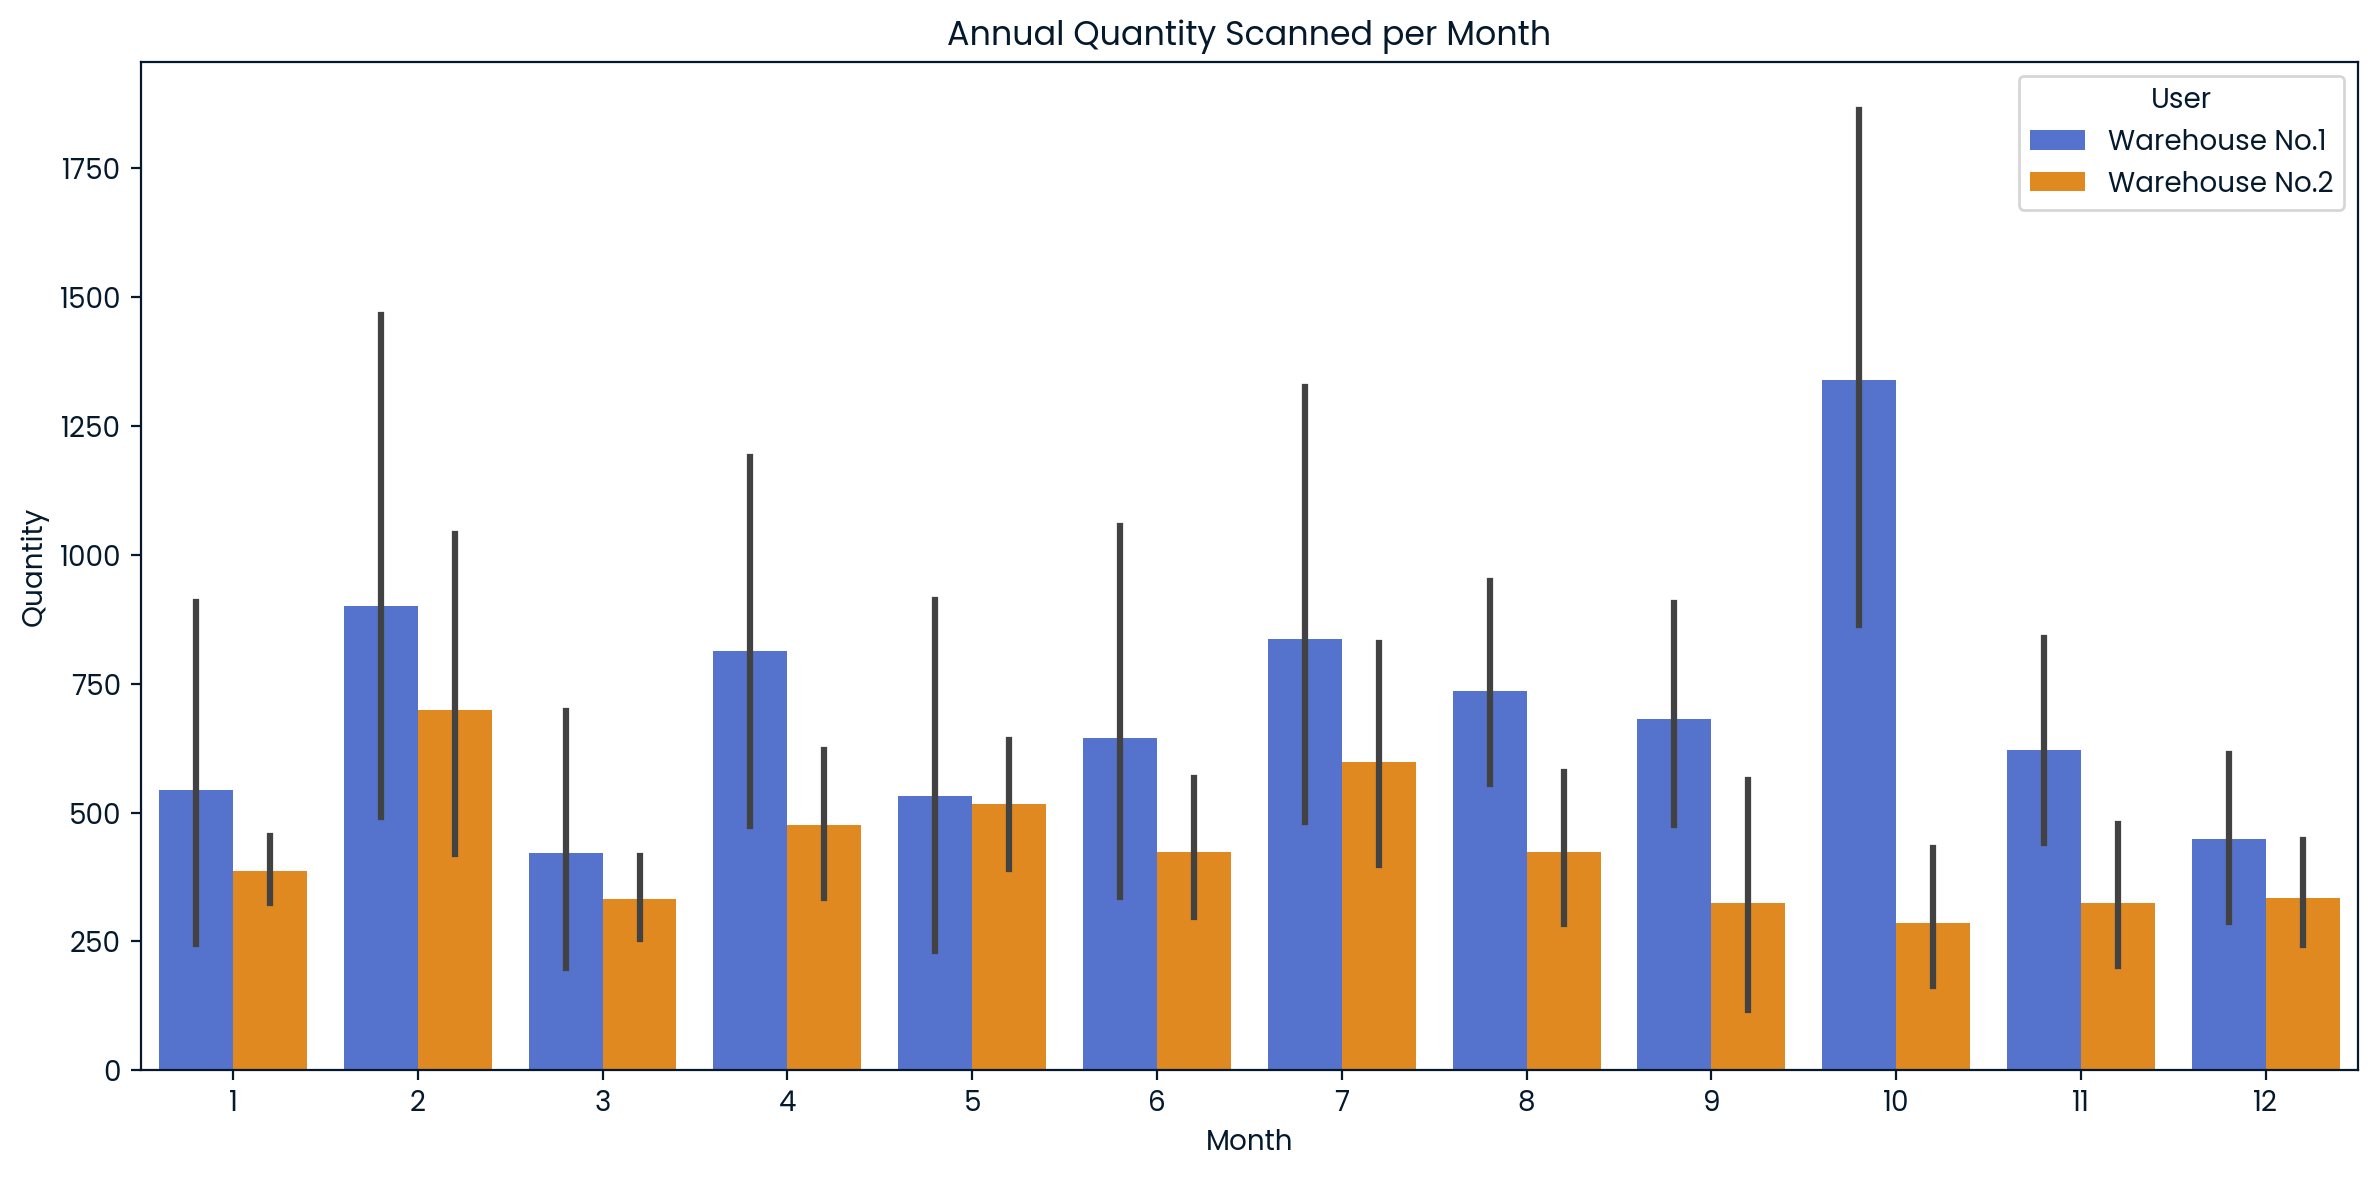

In [10]:
# Plotting Annual Quantity broken down by month
plot_annual_metric(merged_data, 'Quantity', 'Quantity Scanned per Month', colors)


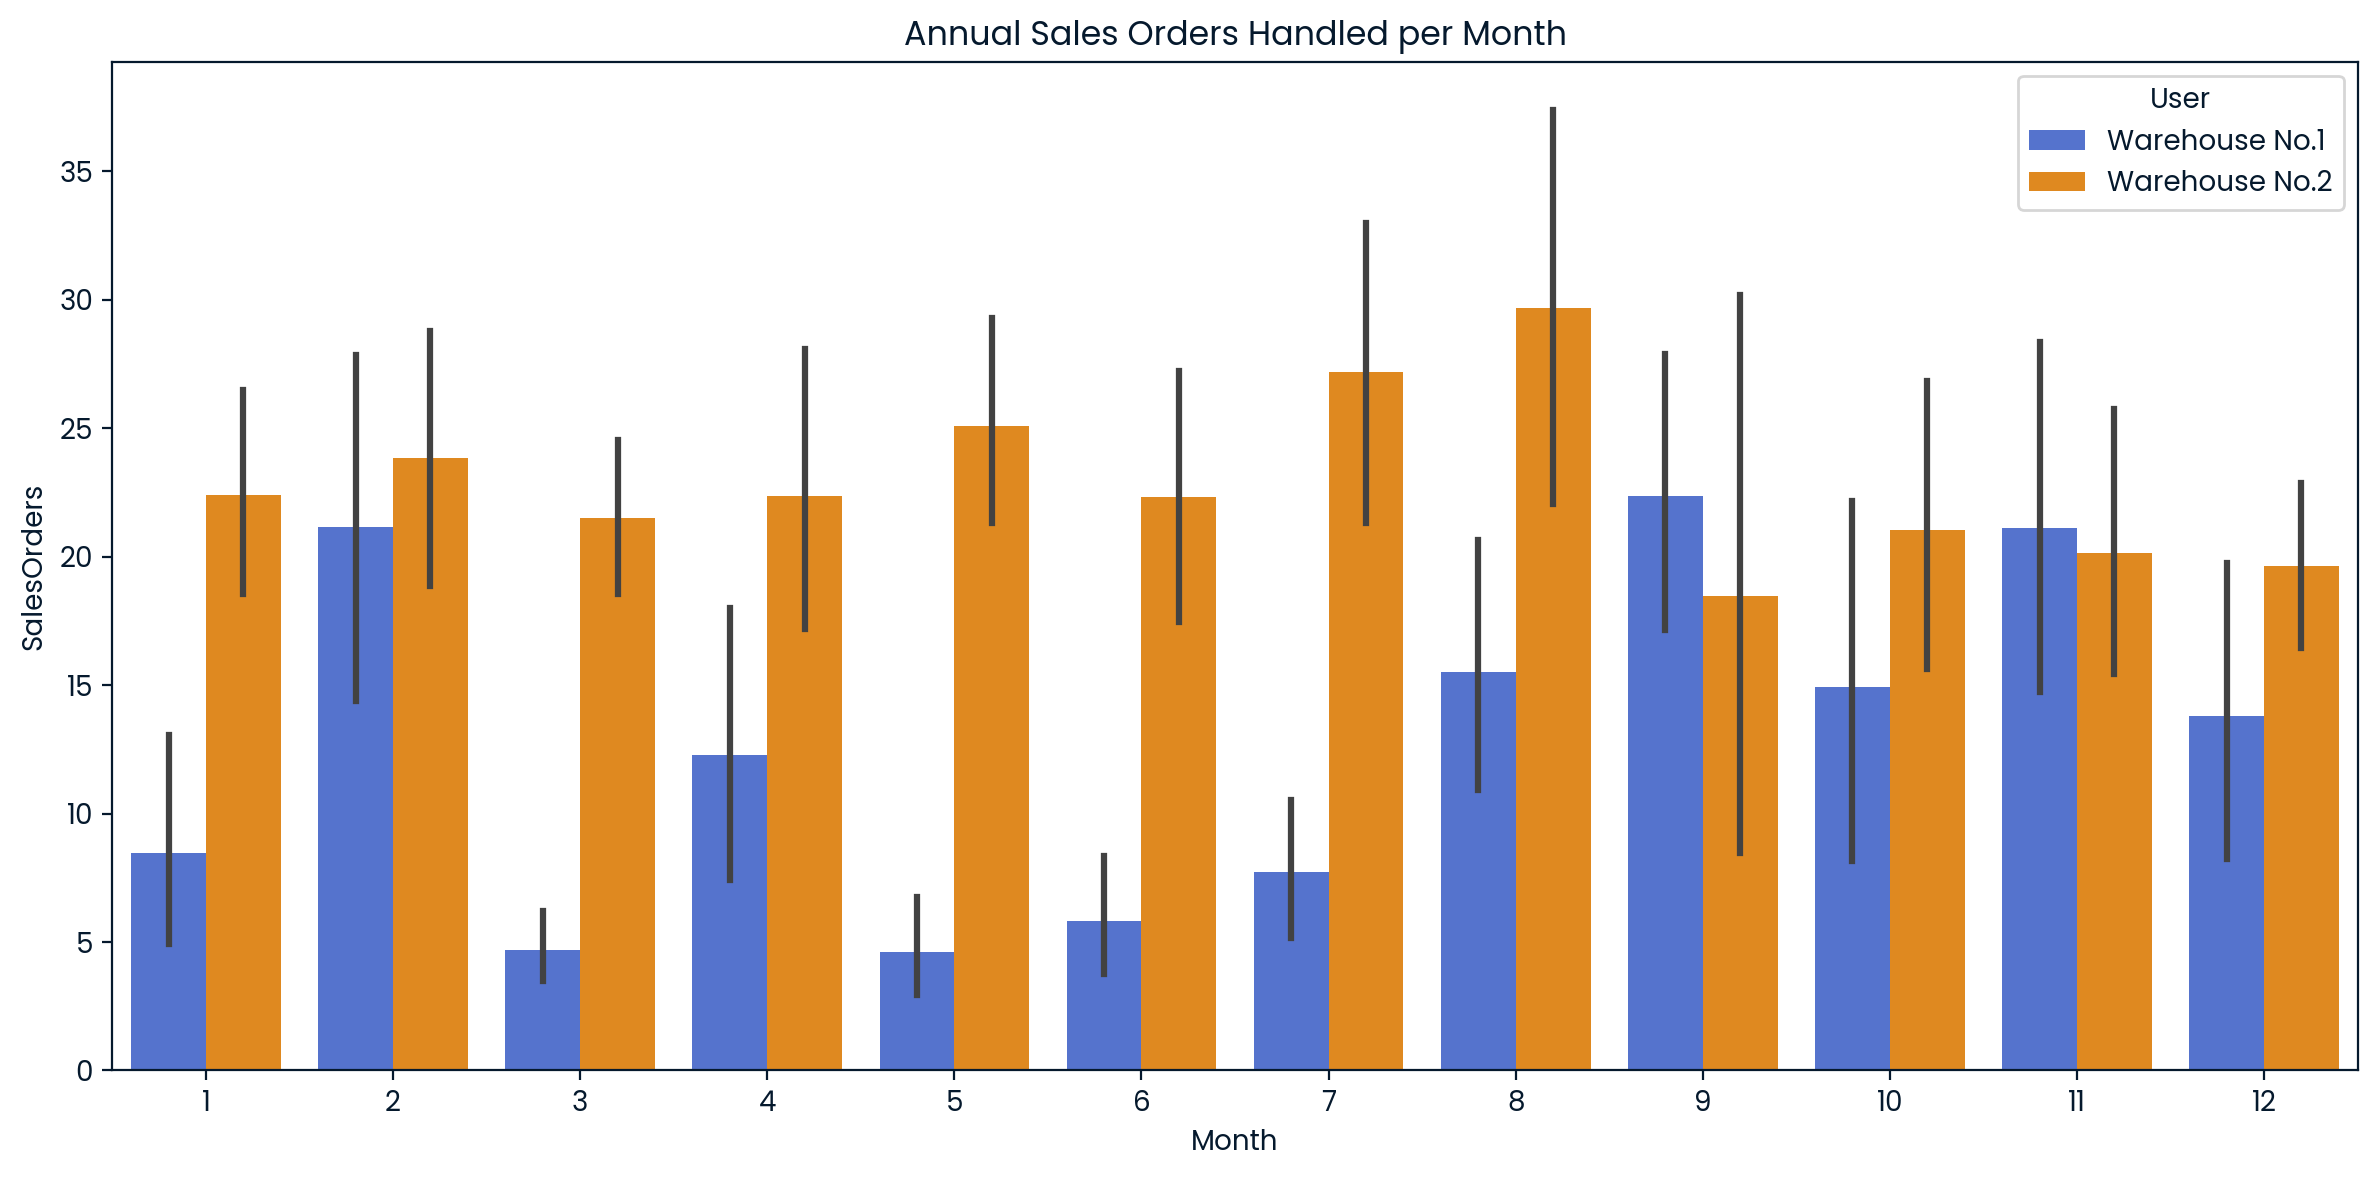

In [11]:
# Plotting Annual Sales Orders broken down by month
plot_annual_metric(merged_data, 'SalesOrders', 'Sales Orders Handled per Month', colors)



# Conclusions from the annual charts for each indicator

1. **Transactions per Month:**
   - Given that Warehouse No.1 deals with large orders with many positions, the number of transactions might not be as high as Warehouse No.2, who handles many small orders. This is because each order, regardless of its size, may count as a single transaction.
   - Warehouse No.2's higher transaction count aligns with the nature of handling many small orders, requiring more frequent individual transactions.

2. **Quantity Scanned per Month:**
   - The large quantity scanned by Warehouse No.1 reflects the handling of bulk orders. Each scan possibly represents a significant quantity of products, explaining the high total quantity despite potentially lower transaction counts.
   - Conversely, Warehouse No.2, dealing with smaller orders, may have a lower total quantity despite a higher number of transactions.

3. **Sales Orders Handled per Month:**
   - The number of sales orders managed by Warehouse No.2 being higher is consistent with the fact that they are responsible for numerous small orders. Each small order counts separately, increasing the total count of sales orders.
   - Warehouse No.1, although dealing with large orders, will have a lower count of sales orders due to the nature of their work focusing on fewer, but larger, orders.

Additional Conclusions:

- **Operational Focus and Efficiency:** Warehouse No.1’s operational focus is on handling fewer, larger orders efficiently, which is crucial for managing bulk transactions and larger quantities of products. In contrast, Warehouse No.2's efficiency is measured by their ability to handle a higher volume of small orders, necessitating quick processing of a greater number of individual sales orders.
  
- **Workload Distribution:** There's a clear distinction in the types of workload handled by each employee. This division of labor could be an intentional strategy to optimize the warehouse's overall efficiency, with each employee specializing in different types of orders.

- **Resource Allocation:** Understanding these operational differences is key for resource allocation. Warehouse No.1 might require more space for bulk orders and might benefit from tools that aid in handling large quantities, whereas Warehouse No.2 might need systems that streamline the processing of a higher volume of smaller orders.

- **Demand Fluctuations:** The data may also reflect how demand fluctuations impact each warehouse employee differently. Seasonal trends, promotional activities, or changes in consumer behavior could differently affect the volume of large versus small orders.

- **Scanning Process Efficiency:** Since employees do not need to scan each unit, the efficiency of the scanning process plays a crucial role. It would be beneficial to analyze if the scanning process is optimally set up for both types of orders (large and small) to ensure time and resource efficiency.

- **Customer Segmentation:** The differences in order handling suggest varying customer segments catered to by each employee – one focusing on bulk, likely B2B orders, and the other on smaller, possibly B2C orders. This segmentation might influence marketing strategies, inventory management, and customer service approaches.

# Determine the most and the less work-consuming months

In [12]:
# Grouping by month to calculate the monthly metrics
monthly_totals = data.groupby('Month').agg({
    'User': 'count',  # Count of transactions
    'Quantity': 'sum',  # Sum of quantities
    'Sale ID': pd.Series.nunique  # Count of unique sales orders
}).rename(columns={'User': 'Transactions', 'Sale ID': 'SalesOrders'})

# Summing up the metrics to get a total workload score for each month
monthly_totals['TotalWorkload'] = monthly_totals['Transactions'] + monthly_totals['Quantity'] + monthly_totals['SalesOrders']

# Sorting by TotalWorkload to find the busiest and least loaded months
sorted_totals = monthly_totals.sort_values(by='TotalWorkload', ascending=False)

# Identifying the three busiest months
busiest_months = sorted_totals.head(3).index.tolist()

# Identifying the three least loaded months
least_loaded_months = sorted_totals.tail(3).index.tolist()

(busiest_months, least_loaded_months)

([10, 7, 8], [9, 3, 12])

Based on the analysis of the total workload (combining Transactions, Quantity, and Sales Orders) for each month:
- The three busiest months during the year are **October (10), July (7), and August (8).**
- The three least loaded months are **September (9), March (3), and December (12)**.
These findings suggest significant seasonal variations in workload, with the peak likely occurring in the late summer and early fall, and the least activity in early spring and late fall.

## Now let's makean analysis focusing only on the Quantity and Sales Orders metrics for each month:

In [13]:
# Re-calculating the monthly totals focusing only on Quantity and Sales Orders
monthly_totals_quantity_sales = data.groupby('Month').agg({
    'Quantity': 'sum',  # Sum of quantities
    'Sale ID': pd.Series.nunique  # Count of unique sales orders
}).rename(columns={'Sale ID': 'SalesOrders'})

# Summing up the metrics to get a total workload score for each month
monthly_totals_quantity_sales['TotalWorkload'] = monthly_totals_quantity_sales['Quantity'] + monthly_totals_quantity_sales['SalesOrders']

# Sorting by TotalWorkload to find the busiest and least loaded months
sorted_totals_quantity_sales = monthly_totals_quantity_sales.sort_values(by='TotalWorkload', ascending=False)

# Identifying the three busiest months based on Quantity and Sales Orders
busiest_months_quantity_sales = sorted_totals_quantity_sales.head(3).index.tolist()

# Identifying the three least loaded months based on Quantity and Sales Orders
least_loaded_months_quantity_sales = sorted_totals_quantity_sales.tail(3).index.tolist()

(busiest_months_quantity_sales, least_loaded_months_quantity_sales)


([10, 2, 7], [9, 3, 12])

Based on the analysis focusing only on the Quantity and Sales Orders metrics for each month:

- The three busiest months during the year, considering the quantity of products scanned and the number of sales orders handled, are **October (10), February (2), and July (7)**.
- The three least loaded months, in terms of these metrics, are **September (9), March (3), and December (12)**.

This refined analysis highlights the key months with the most and least activity in terms of product handling and order processing, excluding the transaction count. This insight can be particularly useful for understanding the demand for product throughput and sales order handling independently of the number of scanning transactions.

Saving results as an image

### Annual Quantity Plot

In [14]:
# Function to create and save annual plots with monthly breakdown for a given metric
def plot_and_save_annual_metric(data, metric, title, colors, file_name):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Month', y=metric, hue='User', data=data, palette=colors)
    plt.title(f'Annual {title}')
    plt.xlabel('Month')
    plt.ylabel(metric)
    plt.legend(title='User')
    plt.tight_layout()
    # Save the plot as an image in the current working directory
    plt.savefig(file_name)
    plt.close()  # Close the plot

# Example usage: Plotting and saving Annual Quantity broken down by month
plot_and_save_annual_metric(merged_data, 'Quantity', 'Quantity Scanned per Month', colors, 'quantity_scanned_per_month.png')



### Annual Transactions Plot

In [15]:
# Plotting and saving Annual Transactions broken down by month
plot_and_save_annual_metric(merged_data, 'Transactions', 'Transactions per Month', colors, 'transactions_per_month.png')


### Annual Sales Orders Plot

In [16]:
# Plotting and saving Annual Sales Orders broken down by month
plot_and_save_annual_metric(merged_data, 'SalesOrders', 'Sales Orders per Month', colors, 'sales_orders_per_month.png')
